# INSTALL

In [1]:
# !pip install -q faiss-cpu sentence-transformers transformers torch torchvision accelerate safetensors networkx

# IMPORTS

In [2]:
import os
import json
import torch
import faiss
import pickle
import warnings
import numpy as np
import igraph as ig
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict, deque
from sentence_transformers import SentenceTransformer
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoTokenizer, AutoModelForCausalLM
)
warnings.filterwarnings('ignore')


/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [3]:
@dataclass
class Config:
    DATASET_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/Dataset'
    DATABASE_JSON: str = f'{DATASET_PATH}/database.json'
    TRAIN_CSV: str = f'{DATASET_PATH}/train_set.csv'
    TEST_CSV: str = f'{DATASET_PATH}/test_public.csv'
    IMAGE_DIR: str = f'{DATASET_PATH}/database_images_compressed90'

    PRECOMPUTED_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/eventa_embeddings_Qwen3'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/database_embeddings_Qwen3.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids_Qwen3.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/database_faiss_index_Qwen3.bin'

    GRAPH_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/entity_graphs_output/graph_entity.pkl'
    NODE_MAPPING_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/entity_graphs_output/node_mapping_entity.json'

    EMBEDDING_MODEL: str = 'Qwen/Qwen3-Embedding-0.6B'
    CLIP_MODEL: str = "openai/clip-vit-large-patch14"

    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    EMBEDDING_BATCH_SIZE: int = 64
    RERANK_BATCH_SIZE: int = 64
    IMG_BATCH: int = 32

    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10

    TOP_K_IMAGES_FAISS: int = 20

    MAX_RERANKER_LENGTH: int = 4096
    MAX_DOC_CHARS: int = 2000
    MAX_CLIP_TOKENS: int = 75

    GRAPH_HOPS: int = 5
    MAX_GRAPH_CANDIDATES: int = 200

    GRAPH_EXPANSION_MODE: str = "weighted_hops"
    PER_NODE_TOPK: int = 20

    TRAIN_VAL_SPLIT: float = 0.999
    RANDOM_SEED: int = 42

config = Config()
print("Device:", config.DEVICE)

Device: cuda


# UTILITY FUNCTIONS

In [4]:
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def train_val_split(df, split_ratio=0.9, seed=42):
    train = df.sample(frac=split_ratio, random_state=seed)
    val = df.drop(train.index)
    return train.reset_index(drop=True), val.reset_index(drop=True)

def normalize_embeddings(E):
    E = E.astype(np.float32)
    faiss.normalize_L2(E)
    return E

def load_graph(graph_path, node_map_path):
    with open(graph_path, 'rb') as f:
        g = pickle.load(f)

    with open(node_map_path, 'r', encoding='utf-8') as f:
        node_map = json.load(f)

    edge_list = g.get('edge_list', [])

    adj = defaultdict(set)

    adj_w = defaultdict(dict)

    for a, b, w in edge_list:
        a_i = int(a)
        b_i = int(b)
        w_f = float(w)
        adj[a_i].add(b_i)
        adj[b_i].add(a_i)

        prev = adj_w[a_i].get(b_i, None)
        if prev is None or w_f > prev:
            adj_w[a_i][b_i] = w_f
        prev = adj_w[b_i].get(a_i, None)
        if prev is None or w_f > prev:
            adj_w[b_i][a_i] = w_f

    if "sorted_index_to_article_id" in node_map:
        node_map = node_map["sorted_index_to_article_id"]

    idx_to_aid = {int(k): v for k, v in node_map.items()}
    aid_to_idx = {v: int(k) for k, v in node_map.items()}

    return adj, adj_w, idx_to_aid, aid_to_idx

def expand_candidates_via_graph(
    seed_article_ids,
    graph_adj,
    aid_to_idx,
    idx_to_aid,
    graph_weights=None,
    mode="bfs",
    hops=1,
    max_candidates=200,
    topk_per_node=None
):
    if topk_per_node is None:
        topk_per_node = config.PER_NODE_TOPK

    seed_idxs = []
    for aid in seed_article_ids:
        if aid in aid_to_idx:
            seed_idxs.append(aid_to_idx[aid])

    if not seed_idxs:
        return []

    if mode == "bfs" or graph_weights is None:
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue
            for nbr in graph_adj.get(node, []):
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_topk":
        score = defaultdict(float)
        for s in seed_idxs:
            nbrs = graph_weights.get(s, {})
            for nbr, w in nbrs.items():
                if nbr in seed_idxs:
                    continue
                score[nbr] += float(w)

        ranked = sorted(score.items(), key=lambda x: x[1], reverse=True)
        selected = [idx for idx, _ in ranked][:max_candidates]

        result = []
        for idx in seed_idxs:
            if idx not in result:
                result.append(idx_to_aid[idx])
        for idx in selected:
            aid = idx_to_aid.get(idx)
            if aid is None:
                continue
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_hops":
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue

            nbr_w = graph_weights.get(node, None)
            if nbr_w:
                nbr_candidates = sorted(nbr_w.items(), key=lambda x: x[1], reverse=True)
                nbr_candidates = [n for n, _ in nbr_candidates[:topk_per_node]]
            else:
                nbr_candidates = list(graph_adj.get(node, []))

            for nbr in nbr_candidates:
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    return expand_candidates_via_graph(seed_article_ids, graph_adj, aid_to_idx, idx_to_aid,
                                       graph_weights=None, mode="bfs", hops=hops, max_candidates=max_candidates)



# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(pred, gt, k):
    hit = sum(1 for p, g in zip(pred, gt) if g in p[:k])
    return hit / len(gt)

def compute_mrr(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def compute_map(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def evaluate_retrieval(pred, gt, name):
    print(f"\n{name} Metrics:")
    metrics = {
        "mAP": compute_map(pred, gt),
        "MRR": compute_mrr(pred, gt),
        "Recall@1": compute_recall_at_k(pred, gt, 1),
        "Recall@5": compute_recall_at_k(pred, gt, 5),
        "Recall@10": compute_recall_at_k(pred, gt, 10),
        "Recall@20": compute_recall_at_k(pred, gt, 20),
        "Recall@50": compute_recall_at_k(pred, gt, 50),
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


# DATALOADER/DATASET

In [6]:
database = load_json(config.DATABASE_JSON)
train_df = pd.read_csv(config.TRAIN_CSV)
train_df, val_df = train_val_split(train_df, config.TRAIN_VAL_SPLIT, config.RANDOM_SEED)

article_image_map = defaultdict(list)
for aid, data in database.items():
    imgs = data.get("images", []) or []
    for img in imgs:
        if isinstance(img, str):
            iid = os.path.splitext(os.path.basename(img))[0]
            article_image_map[aid].append(iid)
            continue
        if isinstance(img, dict):
            for key in ["image_id","id","file_name","filename","path","file"]:
                if key in img:
                    iid = os.path.splitext(os.path.basename(img[key]))[0]
                    article_image_map[aid].append(iid)
                    break

print("Train:", len(train_df), "Val:", len(val_df))

Train: 22018 Val: 22


# ARCHITECTURE

## EMBEDDING & FAISS

In [7]:
def load_embedding_model():
    m = SentenceTransformer(config.EMBEDDING_MODEL, device=config.DEVICE, trust_remote_code=True)
    if config.DEVICE == 'cuda':
        m.half()
    return m

def generate_embeddings(model, texts, batch=64):
    out = []
    for i in tqdm(range(0, len(texts), batch)):
        b = model.encode(texts[i:i+batch], convert_to_numpy=True)
        out.append(b)
    return np.vstack(out)

def search_index(index, Q, k):
    Q = normalize_embeddings(Q)
    dist, idx = index.search(Q, k)
    return dist, idx

## QWEN3 RERANKER

In [8]:
def rerank_articles_graph_only(article_ids, graph_adj_w, aid_to_idx, idx_to_aid):
    scores = {}
    for aid in article_ids:
        if aid not in aid_to_idx:
            continue
        idx = aid_to_idx[aid]
        for nbr, w in graph_adj_w[idx].items():
            aid_nbr = idx_to_aid[nbr]
            scores[aid_nbr] = scores.get(aid_nbr, 0) + w
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [aid for aid, _ in ranked][:config.TOP_K_ARTICLES_RERANK]


## IMAGE RERANKER

In [9]:
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)

def path_for(img_id):
    if "." not in img_id:
        return os.path.join(config.IMAGE_DIR, f"{img_id}.jpg")
    return os.path.join(config.IMAGE_DIR, img_id)

@torch.no_grad()
def rerank_images_clip(query, image_ids, top_k):
    text_inputs = clip_processor.tokenizer(
        query,
        truncation=True,
        max_length=config.MAX_CLIP_TOKENS,
        return_tensors="pt",
    )
    query = clip_processor.tokenizer.decode(text_inputs["input_ids"][0], skip_special_tokens=True)
    images = []
    valid = []
    for iid in image_ids:
        p = path_for(iid)
        try:
            images.append(Image.open(p).convert("RGB"))
            valid.append(iid)
        except:
            pass
    if not images:
        return ["#"] * top_k
    text_inputs = clip_processor(text=[query], return_tensors="pt").to(config.DEVICE)
    text_emb = clip_model.get_text_features(**text_inputs)
    all_embs = []
    for i in range(0, len(images), config.IMG_BATCH):
        batch_imgs = images[i:i+config.IMG_BATCH]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(config.DEVICE)
        img_feats = clip_model.get_image_features(**inputs)
        all_embs.append(img_feats)
    img_emb = torch.cat(all_embs, dim=0)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    sims = (img_emb @ text_emb.T).squeeze(-1).cpu().numpy()
    ranked = sorted(zip(valid, sims), key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in ranked[:top_k]]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# LOAD PRECOMPUTED

In [10]:
database_embeddings = np.load(config.EMBEDDINGS_FILE, mmap_mode='r')
database_article_ids = np.load(config.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
faiss_index = faiss.read_index(config.FAISS_INDEX_FILE, faiss.IO_FLAG_MMAP)
embedding_model = load_embedding_model()

graph_adj, graph_adj_weighted, idx_to_aid, aid_to_idx = load_graph(
    config.GRAPH_PATH,
    config.NODE_MAPPING_PATH
)

# INFERENCE - VALIDATION

In [11]:
val_queries = val_df['caption'].tolist()
val_gt_articles = val_df['retrieved_article_id'].astype(str).tolist()
val_gt_images = val_df['retrieved_image_id'].astype(str).tolist()

Q = generate_embeddings(embedding_model, val_queries, config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)

_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
candidates = [[database_article_ids[i] for i in row] for row in idx]

reranked_articles = []
for i in tqdm(range(0, len(val_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = val_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles_graph_only(expanded, graph_adj_weighted, aid_to_idx, idx_to_aid))
    reranked_articles.extend(batch_results)

final_images = []
for q, arts in tqdm(zip(val_queries, reranked_articles), total=len(val_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    final_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, "Article Retrieval")
image_metrics = evaluate_retrieval(final_images, val_gt_images, "Image Retrieval")

baseline_top1 = [c[0] for c in candidates]
graph_top1 = [r[0] for r in reranked_articles]
agree = [1 if a==b else 0 for a,b in zip(baseline_top1, graph_top1)]

plt.scatter(range(len(agree)), agree, alpha=0.5)
plt.title("Top-1 Agreement: Baseline vs Graph")
plt.savefig("scatter_top1_baseline_vs_graph.png", dpi=150)
plt.close()

neighbor_counts = []
for c in candidates:
    exp = expand_candidates_via_graph(
        c,
        graph_adj,
        aid_to_idx,
        idx_to_aid,
        graph_weights=graph_adj_weighted,
        mode=config.GRAPH_EXPANSION_MODE,
        hops=config.GRAPH_HOPS,
        max_candidates=config.MAX_GRAPH_CANDIDATES,
        topk_per_node=config.PER_NODE_TOPK
    )
    neighbor_counts.append(len(set(exp) - set(c)))

plt.hist(neighbor_counts, bins=40)
plt.title("Graph Neighbor Expansion Counts")
plt.savefig("graph_neighbor_overlap.png", dpi=150)
plt.close()

qual = []
for idx in np.random.choice(len(val_queries), 5, replace=False):
    qual.append({
        "query": val_queries[idx],
        "baseline_top5": candidates[idx][:5],
        "graph_top5": reranked_articles[idx][:5]
    })

pd.DataFrame(qual).to_csv("qualitative_graph_comparison.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 84.90it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:02<00:52,  2.51s/it]

  9%|▉         | 2/22 [00:07<01:20,  4.04s/it]

 14%|█▎        | 3/22 [00:15<01:50,  5.84s/it]

 18%|█▊        | 4/22 [00:18<01:24,  4.72s/it]

 23%|██▎       | 5/22 [00:18<00:52,  3.09s/it]

 27%|██▋       | 6/22 [00:41<02:34,  9.67s/it]

 32%|███▏      | 7/22 [00:57<02:59, 11.99s/it]

 36%|███▋      | 8/22 [00:58<01:55,  8.25s/it]

 41%|████      | 9/22 [01:06<01:48,  8.31s/it]

 45%|████▌     | 10/22 [01:08<01:14,  6.21s/it]

 50%|█████     | 11/22 [01:22<01:35,  8.66s/it]

 55%|█████▍    | 12/22 [01:23<01:04,  6.44s/it]

 59%|█████▉    | 13/22 [01:32<01:04,  7.17s/it]

 64%|██████▎   | 14/22 [01:33<00:42,  5.32s/it]

 68%|██████▊   | 15/22 [01:36<00:31,  4.56s/it]

 73%|███████▎  | 16/22 [01:37<00:20,  3.36s/it]

 77%|███████▋  | 17/22 [01:39<00:15,  3.18s/it]

 82%|████████▏ | 18/22 [01:40<00:09,  2.50s/it]

 86%|████████▋ | 19/22 [01:41<00:05,  1.95s/it]

 91%|█████████ | 20/22 [01:45<00:05,  2.56s/it]

 95%|█████████▌| 21/22 [01:46<00:02,  2.17s/it]

100%|██████████| 22/22 [01:48<00:00,  2.21s/it]

100%|██████████| 22/22 [01:48<00:00,  4.95s/it]


Article Retrieval Metrics:
mAP: 0.0000
MRR: 0.0000
Recall@1: 0.0000
Recall@5: 0.0000
Recall@10: 0.0000
Recall@20: 0.0000
Recall@50: 0.0000

Image Retrieval Metrics:
mAP: 0.0000
MRR: 0.0000
Recall@1: 0.0000
Recall@5: 0.0000
Recall@10: 0.0000
Recall@20: 0.0000
Recall@50: 0.0000


# VISUALIZATION

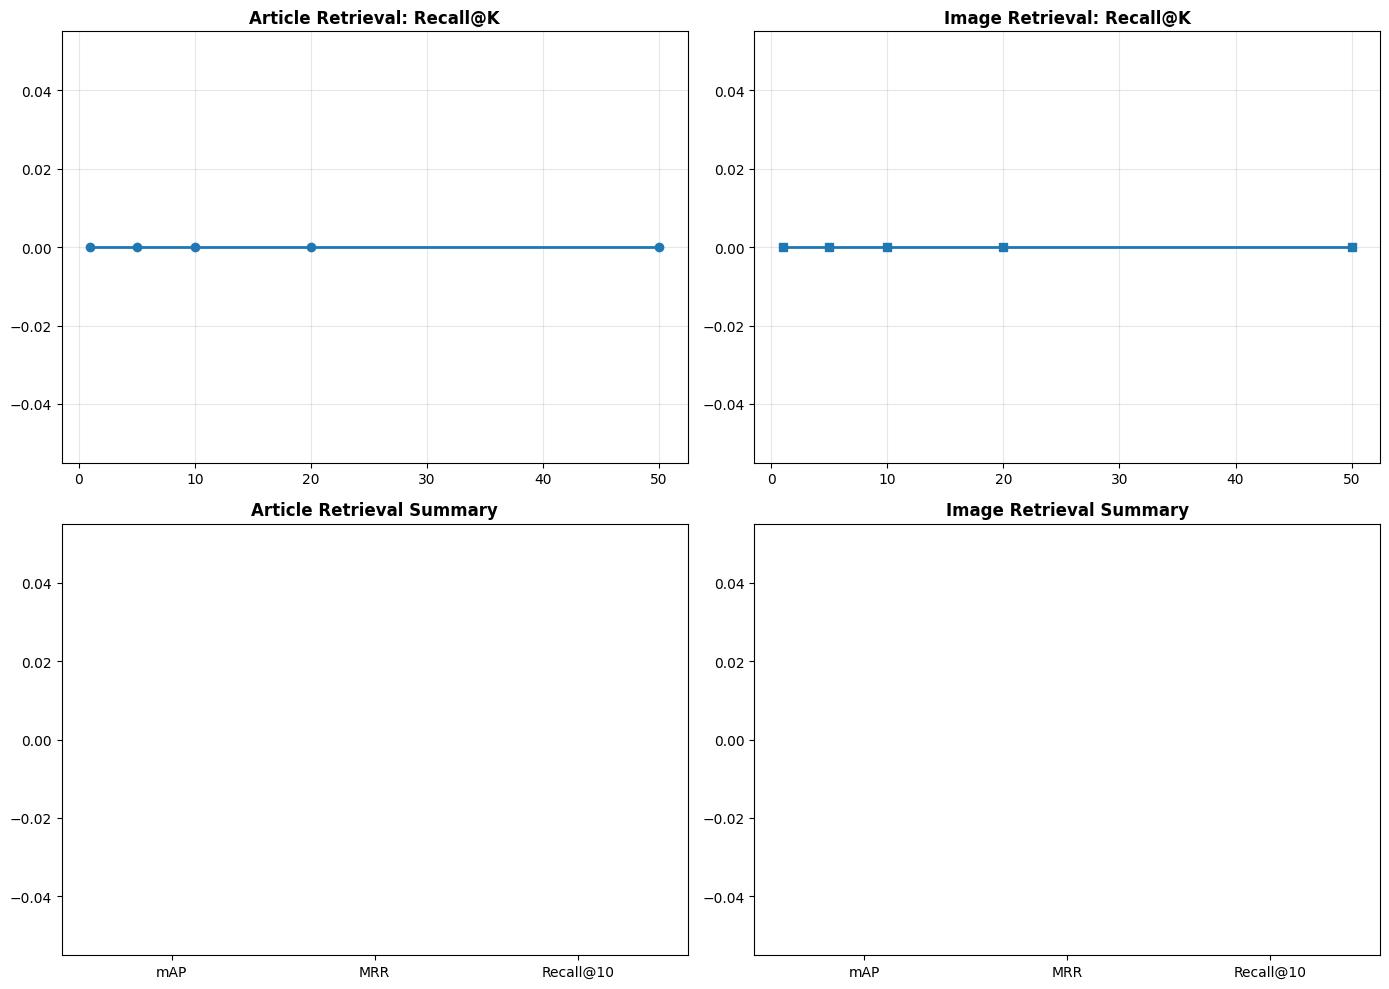

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
k_vals = [1, 5, 10, 20, 50]
article_recalls = [article_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 0].plot(k_vals, article_recalls, marker='o', linewidth=2)
axes[0, 0].set_title("Article Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

image_recalls = [image_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 1].plot(k_vals, image_recalls, marker='s', linewidth=2)
axes[0, 1].set_title("Image Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

article_summary_keys = ["mAP", "MRR", "Recall@10"]
article_summary_vals = [article_metrics[k] for k in article_summary_keys]
axes[1, 0].bar(article_summary_keys, article_summary_vals, alpha=0.7)
axes[1, 0].set_title("Article Retrieval Summary", fontsize=12, fontweight='bold')

image_summary_keys = ["mAP", "MRR", "Recall@10"]
image_summary_vals = [image_metrics[k] for k in image_summary_keys]
axes[1, 1].bar(image_summary_keys, image_summary_vals, alpha=0.7)
axes[1, 1].set_title("Image Retrieval Summary", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("qwen3_results.png", dpi=150)
plt.show()


# TEST INFERENCE & SUBMISSION

In [13]:
test_df = pd.read_csv(config.TEST_CSV)
test_queries = test_df['query_text'].tolist()
test_ids = test_df['query_index'].tolist()

Q = generate_embeddings(embedding_model, test_queries, batch=config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)
_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
test_candidates = [[database_article_ids[i] for i in row] for row in idx]

test_articles = []
for i in tqdm(range(0, len(test_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = test_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = test_candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles_graph_only(expanded, graph_adj_weighted, aid_to_idx, idx_to_aid))
    test_articles.extend(batch_results)

test_images = []
for q, arts in tqdm(zip(test_queries, test_articles), total=len(test_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    test_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

rows = []
for qid, imgs in zip(test_ids, test_images):
    rows.append([qid] + imgs + ["#"]*(config.TOP_K_IMAGES-len(imgs)))

sub = pd.DataFrame(rows, columns=["query_id"]+[f"image_id_{i+1}" for i in range(config.TOP_K_IMAGES)])
sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")


  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:01<01:11,  1.54s/it]

  4%|▍         | 2/47 [00:02<01:01,  1.36s/it]

  6%|▋         | 3/47 [00:04<01:06,  1.50s/it]

  9%|▊         | 4/47 [00:06<01:07,  1.57s/it]

 11%|█         | 5/47 [00:07<01:03,  1.52s/it]

 13%|█▎        | 6/47 [00:09<01:02,  1.53s/it]

 15%|█▍        | 7/47 [00:10<00:56,  1.42s/it]

 17%|█▋        | 8/47 [00:11<00:51,  1.32s/it]

 19%|█▉        | 9/47 [00:12<00:53,  1.40s/it]

 21%|██▏       | 10/47 [00:14<00:57,  1.55s/it]

 23%|██▎       | 11/47 [00:16<00:52,  1.47s/it]

 26%|██▌       | 12/47 [00:17<00:52,  1.51s/it]

 28%|██▊       | 13/47 [00:19<00:49,  1.46s/it]

 30%|██▉       | 14/47 [00:20<00:45,  1.38s/it]

 32%|███▏      | 15/47 [00:21<00:42,  1.33s/it]

 34%|███▍      | 16/47 [00:23<00:42,  1.38s/it]

 36%|███▌      | 17/47 [00:24<00:41,  1.37s/it]

 38%|███▊      | 18/47 [00:25<00:38,  1.34s/it]

 40%|████      | 19/47 [00:27<00:39,  1.42s/it]

 43%|████▎     | 20/47 [00:28<00:37,  1.38s/it]

 45%|████▍     | 21/47 [00:29<00:36,  1.40s/it]

 47%|████▋     | 22/47 [00:31<00:35,  1.43s/it]

 49%|████▉     | 23/47 [00:32<00:32,  1.35s/it]

 51%|█████     | 24/47 [00:33<00:30,  1.34s/it]

 53%|█████▎    | 25/47 [00:34<00:24,  1.12s/it]

 55%|█████▌    | 26/47 [00:34<00:19,  1.10it/s]

 57%|█████▋    | 27/47 [00:35<00:16,  1.23it/s]

 60%|█████▉    | 28/47 [00:36<00:15,  1.20it/s]

 62%|██████▏   | 29/47 [00:36<00:13,  1.38it/s]

 64%|██████▍   | 30/47 [00:37<00:11,  1.51it/s]

 66%|██████▌   | 31/47 [00:37<00:09,  1.69it/s]

 68%|██████▊   | 32/47 [00:38<00:07,  1.93it/s]

 70%|███████   | 33/47 [00:38<00:06,  2.07it/s]

 72%|███████▏  | 34/47 [00:38<00:05,  2.23it/s]

 74%|███████▍  | 35/47 [00:39<00:04,  2.41it/s]

 77%|███████▋  | 36/47 [00:39<00:04,  2.37it/s]

 79%|███████▊  | 37/47 [00:40<00:04,  2.08it/s]

 81%|████████  | 38/47 [00:41<00:04,  1.86it/s]

 83%|████████▎ | 39/47 [00:41<00:04,  1.90it/s]

 85%|████████▌ | 40/47 [00:42<00:03,  1.83it/s]

 87%|████████▋ | 41/47 [00:42<00:03,  1.55it/s]

 89%|████████▉ | 42/47 [00:43<00:03,  1.60it/s]

 91%|█████████▏| 43/47 [00:44<00:02,  1.68it/s]

 94%|█████████▎| 44/47 [00:44<00:01,  1.55it/s]

 96%|█████████▌| 45/47 [00:45<00:01,  1.34it/s]

 98%|█████████▊| 46/47 [00:46<00:00,  1.26it/s]

100%|██████████| 47/47 [00:47<00:00,  1.16it/s]

100%|██████████| 47/47 [00:47<00:00,  1.02s/it]

  0%|          | 0/47 [00:00<?, ?it/s]

  6%|▋         | 3/47 [00:00<00:01, 23.19it/s]

 13%|█▎        | 6/47 [00:00<00:01, 24.13it/s]

 19%|█▉        | 9/47 [00:00<00:01, 23.33it/s]

 26%|██▌       | 12/47 [00:00<00:01, 23.82it/s]

 32%|███▏      | 15/47 [00:00<00:01, 25.20it/s]

 38%|███▊      | 18/47 [00:00<00:01, 26.17it/s]

 45%|████▍     | 21/47 [00:00<00:01, 24.92it/s]

 51%|█████     | 24/47 [00:00<00:00, 25.44it/s]

 57%|█████▋    | 27/47 [00:01<00:00, 25.10it/s]

 64%|██████▍   | 30/47 [00:01<00:00, 24.88it/s]

 70%|███████   | 33/47 [00:01<00:00, 25.18it/s]

 77%|███████▋  | 36/47 [00:01<00:00, 23.60it/s]

 83%|████████▎ | 39/47 [00:01<00:00, 20.57it/s]

 89%|████████▉ | 42/47 [00:01<00:00, 19.18it/s]

 94%|█████████▎| 44/47 [00:01<00:00, 18.09it/s]

 98%|█████████▊| 46/47 [00:02<00:00, 17.45it/s]

100%|██████████| 47/47 [00:02<00:00, 21.77it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:28<24:08:15, 28.97s/it]

  0%|          | 2/3000 [00:31<11:08:27, 13.38s/it]

  0%|          | 3/3000 [00:34<7:23:38,  8.88s/it] 

  0%|          | 5/3000 [00:36<3:36:01,  4.33s/it]

  0%|          | 6/3000 [00:41<3:47:34,  4.56s/it]

  0%|          | 7/3000 [00:45<3:40:50,  4.43s/it]

  0%|          | 8/3000 [01:25<12:21:46, 14.88s/it]

  0%|          | 9/3000 [01:26<8:55:56, 10.75s/it] 

  0%|          | 10/3000 [01:28<6:37:18,  7.97s/it]

  0%|          | 11/3000 [01:28<4:47:52,  5.78s/it]

  0%|          | 12/3000 [01:29<3:36:36,  4.35s/it]

  0%|          | 13/3000 [01:29<2:33:27,  3.08s/it]

  0%|          | 14/3000 [01:30<2:03:26,  2.48s/it]

  0%|          | 15/3000 [01:34<2:12:50,  2.67s/it]

  1%|          | 16/3000 [01:35<1:56:54,  2.35s/it]

  1%|          | 17/3000 [01:35<1:26:35,  1.74s/it]

  1%|          | 18/3000 [01:36<1:10:39,  1.42s/it]

  1%|          | 19/3000 [01:38<1:10:09,  1.41s/it]

  1%|          | 20/3000 [01:38<59:28,  1.20s/it]  

  1%|          | 21/3000 [01:40<1:03:53,  1.29s/it]

  1%|          | 22/3000 [01:40<54:56,  1.11s/it]  

  1%|          | 23/3000 [01:53<3:43:56,  4.51s/it]

  1%|          | 25/3000 [02:33<9:43:00, 11.76s/it]

  1%|          | 26/3000 [02:38<8:17:36, 10.04s/it]

  1%|          | 27/3000 [02:42<7:00:40,  8.49s/it]

  1%|          | 28/3000 [02:43<5:16:11,  6.38s/it]

  1%|          | 30/3000 [02:44<3:13:24,  3.91s/it]

  1%|          | 31/3000 [02:47<2:56:25,  3.57s/it]

  1%|          | 32/3000 [02:57<4:20:17,  5.26s/it]

  1%|          | 34/3000 [03:13<5:11:07,  6.29s/it]

  1%|          | 35/3000 [03:25<6:20:03,  7.69s/it]

  1%|          | 36/3000 [03:26<4:54:38,  5.96s/it]

  1%|          | 37/3000 [03:28<4:00:58,  4.88s/it]

  1%|▏         | 38/3000 [03:29<3:09:36,  3.84s/it]

  1%|▏         | 39/3000 [03:30<2:38:19,  3.21s/it]

  1%|▏         | 40/3000 [03:31<2:06:52,  2.57s/it]

  1%|▏         | 41/3000 [03:32<1:43:24,  2.10s/it]

  1%|▏         | 42/3000 [03:34<1:33:59,  1.91s/it]

  1%|▏         | 43/3000 [03:35<1:34:27,  1.92s/it]

  1%|▏         | 44/3000 [03:37<1:24:42,  1.72s/it]

  2%|▏         | 45/3000 [03:39<1:28:06,  1.79s/it]

  2%|▏         | 46/3000 [03:39<1:10:25,  1.43s/it]

  2%|▏         | 47/3000 [03:40<1:00:39,  1.23s/it]

  2%|▏         | 48/3000 [03:41<56:43,  1.15s/it]  

  2%|▏         | 49/3000 [03:52<3:17:32,  4.02s/it]

  2%|▏         | 50/3000 [03:54<2:47:47,  3.41s/it]

  2%|▏         | 51/3000 [03:56<2:34:22,  3.14s/it]

  2%|▏         | 52/3000 [03:59<2:29:12,  3.04s/it]

  2%|▏         | 54/3000 [03:59<1:25:15,  1.74s/it]

  2%|▏         | 55/3000 [04:02<1:31:30,  1.86s/it]

  2%|▏         | 56/3000 [04:03<1:23:50,  1.71s/it]

  2%|▏         | 57/3000 [04:04<1:11:42,  1.46s/it]

  2%|▏         | 58/3000 [04:04<55:47,  1.14s/it]  

  2%|▏         | 59/3000 [04:06<1:02:58,  1.28s/it]

  2%|▏         | 60/3000 [04:43<9:31:16, 11.66s/it]

  2%|▏         | 61/3000 [04:44<6:54:07,  8.45s/it]

  2%|▏         | 62/3000 [04:44<5:06:09,  6.25s/it]

  2%|▏         | 63/3000 [04:47<4:07:02,  5.05s/it]

  2%|▏         | 64/3000 [04:47<2:56:03,  3.60s/it]

  2%|▏         | 65/3000 [04:48<2:14:14,  2.74s/it]

  2%|▏         | 66/3000 [04:48<1:43:47,  2.12s/it]

  2%|▏         | 67/3000 [04:50<1:38:38,  2.02s/it]

  2%|▏         | 68/3000 [04:55<2:24:09,  2.95s/it]

  2%|▏         | 69/3000 [05:05<4:01:35,  4.95s/it]

  2%|▏         | 70/3000 [05:10<4:06:21,  5.04s/it]

  2%|▏         | 71/3000 [05:11<3:00:23,  3.70s/it]

  2%|▏         | 72/3000 [05:19<4:08:11,  5.09s/it]

  2%|▏         | 73/3000 [05:50<10:28:10, 12.88s/it]

  2%|▏         | 74/3000 [06:16<13:44:04, 16.90s/it]

  2%|▎         | 75/3000 [06:52<18:18:43, 22.54s/it]

  3%|▎         | 76/3000 [07:00<14:47:58, 18.22s/it]

  3%|▎         | 77/3000 [07:01<10:37:49, 13.09s/it]

  3%|▎         | 78/3000 [07:02<7:36:17,  9.37s/it] 

  3%|▎         | 79/3000 [07:02<5:26:43,  6.71s/it]

  3%|▎         | 81/3000 [07:03<2:58:37,  3.67s/it]

  3%|▎         | 82/3000 [07:03<2:22:23,  2.93s/it]

  3%|▎         | 83/3000 [07:03<1:46:36,  2.19s/it]

  3%|▎         | 84/3000 [07:04<1:29:29,  1.84s/it]

  3%|▎         | 85/3000 [07:18<4:04:33,  5.03s/it]

  3%|▎         | 86/3000 [07:19<3:14:22,  4.00s/it]

  3%|▎         | 87/3000 [07:23<3:06:49,  3.85s/it]

  3%|▎         | 88/3000 [07:29<3:46:16,  4.66s/it]

  3%|▎         | 89/3000 [07:29<2:44:35,  3.39s/it]

  3%|▎         | 90/3000 [07:30<2:01:55,  2.51s/it]

  3%|▎         | 91/3000 [07:31<1:36:52,  2.00s/it]

  3%|▎         | 92/3000 [07:32<1:29:47,  1.85s/it]

  3%|▎         | 93/3000 [07:37<2:09:58,  2.68s/it]

  3%|▎         | 94/3000 [07:38<1:52:18,  2.32s/it]

  3%|▎         | 95/3000 [07:39<1:35:26,  1.97s/it]

  3%|▎         | 96/3000 [07:40<1:10:46,  1.46s/it]

  3%|▎         | 97/3000 [07:41<1:07:12,  1.39s/it]

  3%|▎         | 98/3000 [07:50<3:03:10,  3.79s/it]

  3%|▎         | 99/3000 [07:51<2:17:36,  2.85s/it]

  3%|▎         | 100/3000 [07:54<2:13:54,  2.77s/it]

  3%|▎         | 101/3000 [07:57<2:22:23,  2.95s/it]

  3%|▎         | 102/3000 [11:45<56:40:42, 70.41s/it]

  3%|▎         | 103/3000 [11:48<40:27:04, 50.27s/it]

  3%|▎         | 104/3000 [11:48<28:22:52, 35.28s/it]

  4%|▎         | 105/3000 [11:49<20:06:20, 25.00s/it]

  4%|▎         | 106/3000 [11:51<14:25:14, 17.94s/it]

  4%|▎         | 107/3000 [11:58<11:46:41, 14.66s/it]

  4%|▎         | 108/3000 [11:58<8:18:06, 10.33s/it] 

  4%|▎         | 109/3000 [11:58<5:51:02,  7.29s/it]

  4%|▎         | 110/3000 [12:01<4:38:29,  5.78s/it]

  4%|▎         | 111/3000 [12:03<3:46:25,  4.70s/it]

  4%|▎         | 112/3000 [12:06<3:32:14,  4.41s/it]

  4%|▍         | 113/3000 [12:07<2:33:59,  3.20s/it]

  4%|▍         | 114/3000 [12:10<2:27:12,  3.06s/it]

  4%|▍         | 115/3000 [12:15<3:05:44,  3.86s/it]

  4%|▍         | 116/3000 [12:16<2:15:17,  2.81s/it]

  4%|▍         | 118/3000 [12:17<1:25:15,  1.78s/it]

  4%|▍         | 119/3000 [12:19<1:26:59,  1.81s/it]

  4%|▍         | 120/3000 [12:19<1:13:10,  1.52s/it]

  4%|▍         | 121/3000 [12:28<2:47:19,  3.49s/it]

  4%|▍         | 122/3000 [12:30<2:27:39,  3.08s/it]

  4%|▍         | 124/3000 [12:32<1:36:16,  2.01s/it]

  4%|▍         | 125/3000 [12:34<1:46:16,  2.22s/it]

  4%|▍         | 126/3000 [12:36<1:40:42,  2.10s/it]

  4%|▍         | 127/3000 [12:38<1:36:52,  2.02s/it]

  4%|▍         | 128/3000 [12:47<3:14:07,  4.06s/it]

  4%|▍         | 129/3000 [13:12<7:58:40, 10.00s/it]

  4%|▍         | 130/3000 [13:40<11:58:34, 15.02s/it]

  4%|▍         | 131/3000 [13:44<9:32:47, 11.98s/it] 

  4%|▍         | 132/3000 [13:45<6:58:53,  8.76s/it]

  4%|▍         | 133/3000 [14:00<8:13:44, 10.33s/it]

  4%|▍         | 134/3000 [14:00<5:56:09,  7.46s/it]

  4%|▍         | 135/3000 [14:01<4:16:40,  5.38s/it]

  5%|▍         | 136/3000 [14:01<3:07:51,  3.94s/it]

  5%|▍         | 137/3000 [14:02<2:15:56,  2.85s/it]

  5%|▍         | 138/3000 [14:02<1:44:21,  2.19s/it]

  5%|▍         | 139/3000 [14:04<1:45:45,  2.22s/it]

  5%|▍         | 140/3000 [14:07<1:51:36,  2.34s/it]

  5%|▍         | 141/3000 [14:11<2:16:29,  2.86s/it]

  5%|▍         | 142/3000 [14:16<2:45:20,  3.47s/it]

  5%|▍         | 143/3000 [14:17<2:07:44,  2.68s/it]

  5%|▍         | 144/3000 [14:17<1:32:17,  1.94s/it]

  5%|▍         | 145/3000 [14:17<1:09:32,  1.46s/it]

  5%|▍         | 146/3000 [14:19<1:12:02,  1.51s/it]

  5%|▍         | 147/3000 [14:21<1:12:50,  1.53s/it]

  5%|▍         | 148/3000 [14:24<1:46:01,  2.23s/it]

  5%|▍         | 149/3000 [14:33<3:10:01,  4.00s/it]

  5%|▌         | 150/3000 [14:34<2:32:25,  3.21s/it]

  5%|▌         | 151/3000 [14:43<4:01:50,  5.09s/it]

  5%|▌         | 153/3000 [14:44<2:14:28,  2.83s/it]

  5%|▌         | 154/3000 [14:57<4:21:11,  5.51s/it]

  5%|▌         | 155/3000 [15:04<4:29:56,  5.69s/it]

  5%|▌         | 156/3000 [15:04<3:18:17,  4.18s/it]

  5%|▌         | 157/3000 [15:04<2:25:36,  3.07s/it]

  5%|▌         | 158/3000 [15:08<2:33:28,  3.24s/it]

  5%|▌         | 159/3000 [15:09<2:12:06,  2.79s/it]

  5%|▌         | 160/3000 [15:10<1:37:31,  2.06s/it]

  5%|▌         | 161/3000 [15:20<3:38:31,  4.62s/it]

  5%|▌         | 163/3000 [15:24<2:41:54,  3.42s/it]

  5%|▌         | 164/3000 [15:25<2:05:32,  2.66s/it]

  6%|▌         | 165/3000 [15:25<1:37:29,  2.06s/it]

  6%|▌         | 166/3000 [15:29<1:59:16,  2.53s/it]

  6%|▌         | 167/3000 [15:33<2:22:54,  3.03s/it]

  6%|▌         | 168/3000 [15:41<3:31:42,  4.49s/it]

  6%|▌         | 169/3000 [15:52<4:58:09,  6.32s/it]

  6%|▌         | 170/3000 [15:53<3:40:08,  4.67s/it]

  6%|▌         | 171/3000 [15:53<2:38:40,  3.37s/it]

  6%|▌         | 172/3000 [15:54<1:57:04,  2.48s/it]

  6%|▌         | 173/3000 [15:59<2:35:02,  3.29s/it]

  6%|▌         | 174/3000 [16:39<11:09:02, 14.20s/it]

  6%|▌         | 175/3000 [16:48<10:06:07, 12.87s/it]

  6%|▌         | 176/3000 [17:01<10:02:35, 12.80s/it]

  6%|▌         | 177/3000 [17:33<14:33:19, 18.56s/it]

  6%|▌         | 178/3000 [18:04<17:21:50, 22.15s/it]

  6%|▌         | 179/3000 [18:06<12:41:06, 16.19s/it]

  6%|▌         | 180/3000 [19:24<27:20:03, 34.89s/it]

  6%|▌         | 181/3000 [19:34<21:24:48, 27.35s/it]

  6%|▌         | 182/3000 [19:52<19:17:35, 24.65s/it]

  6%|▌         | 183/3000 [20:08<17:04:36, 21.82s/it]

  6%|▌         | 184/3000 [20:34<18:11:41, 23.26s/it]

  6%|▌         | 185/3000 [20:35<12:54:47, 16.51s/it]

  6%|▌         | 186/3000 [20:36<9:10:06, 11.73s/it] 

  6%|▌         | 187/3000 [20:38<7:00:26,  8.97s/it]

  6%|▋         | 188/3000 [20:39<5:01:01,  6.42s/it]

  6%|▋         | 189/3000 [20:39<3:37:16,  4.64s/it]

  6%|▋         | 190/3000 [20:42<3:16:37,  4.20s/it]

  6%|▋         | 191/3000 [20:43<2:25:09,  3.10s/it]

  6%|▋         | 192/3000 [20:46<2:24:50,  3.09s/it]

  6%|▋         | 193/3000 [20:46<1:49:12,  2.33s/it]

  6%|▋         | 194/3000 [20:49<1:52:13,  2.40s/it]

  6%|▋         | 195/3000 [20:54<2:33:39,  3.29s/it]

  7%|▋         | 196/3000 [20:59<2:57:54,  3.81s/it]

  7%|▋         | 197/3000 [21:04<3:14:52,  4.17s/it]

  7%|▋         | 198/3000 [21:16<5:02:37,  6.48s/it]

  7%|▋         | 199/3000 [21:17<3:38:57,  4.69s/it]

  7%|▋         | 200/3000 [21:34<6:29:04,  8.34s/it]

  7%|▋         | 201/3000 [21:49<8:05:56, 10.42s/it]

  7%|▋         | 202/3000 [21:55<6:58:31,  8.97s/it]

  7%|▋         | 203/3000 [21:55<5:00:42,  6.45s/it]

  7%|▋         | 204/3000 [21:59<4:25:51,  5.71s/it]

  7%|▋         | 205/3000 [22:03<4:02:52,  5.21s/it]

  7%|▋         | 206/3000 [22:22<7:06:27,  9.16s/it]

  7%|▋         | 207/3000 [22:28<6:22:32,  8.22s/it]

  7%|▋         | 208/3000 [22:37<6:33:53,  8.46s/it]

  7%|▋         | 209/3000 [22:44<6:20:10,  8.17s/it]

  7%|▋         | 210/3000 [22:51<6:08:56,  7.93s/it]

  7%|▋         | 211/3000 [22:59<6:08:05,  7.92s/it]

  7%|▋         | 212/3000 [23:07<6:03:55,  7.83s/it]

  7%|▋         | 213/3000 [23:07<4:20:01,  5.60s/it]

  7%|▋         | 214/3000 [23:08<3:04:13,  3.97s/it]

  7%|▋         | 215/3000 [23:12<3:07:35,  4.04s/it]

  7%|▋         | 216/3000 [23:12<2:13:01,  2.87s/it]

  7%|▋         | 217/3000 [23:50<10:19:42, 13.36s/it]

  7%|▋         | 218/3000 [24:16<13:20:24, 17.26s/it]

  7%|▋         | 219/3000 [24:21<10:26:41, 13.52s/it]

  7%|▋         | 220/3000 [25:03<17:05:01, 22.12s/it]

  7%|▋         | 221/3000 [25:04<12:11:50, 15.80s/it]

  7%|▋         | 222/3000 [25:05<8:40:18, 11.24s/it] 

  7%|▋         | 223/3000 [25:05<6:12:13,  8.04s/it]

  7%|▋         | 224/3000 [25:06<4:27:37,  5.78s/it]

  8%|▊         | 225/3000 [25:08<3:36:13,  4.68s/it]

  8%|▊         | 226/3000 [25:11<3:17:35,  4.27s/it]

  8%|▊         | 227/3000 [25:15<3:10:41,  4.13s/it]

  8%|▊         | 228/3000 [25:36<7:09:32,  9.30s/it]

  8%|▊         | 229/3000 [25:37<5:04:56,  6.60s/it]

  8%|▊         | 230/3000 [25:37<3:37:59,  4.72s/it]

  8%|▊         | 231/3000 [25:41<3:28:13,  4.51s/it]

  8%|▊         | 233/3000 [25:43<2:12:49,  2.88s/it]

  8%|▊         | 234/3000 [25:48<2:34:05,  3.34s/it]

  8%|▊         | 235/3000 [25:49<2:03:50,  2.69s/it]

  8%|▊         | 236/3000 [26:01<4:02:05,  5.26s/it]

  8%|▊         | 237/3000 [26:03<3:27:00,  4.50s/it]

  8%|▊         | 238/3000 [26:35<9:20:45, 12.18s/it]

  8%|▊         | 239/3000 [27:07<13:52:08, 18.08s/it]

  8%|▊         | 240/3000 [27:09<10:13:18, 13.33s/it]

  8%|▊         | 241/3000 [27:09<7:15:53,  9.48s/it] 

  8%|▊         | 242/3000 [27:10<5:12:35,  6.80s/it]

  8%|▊         | 243/3000 [27:10<3:47:03,  4.94s/it]

  8%|▊         | 244/3000 [27:11<2:42:25,  3.54s/it]

  8%|▊         | 245/3000 [27:13<2:27:19,  3.21s/it]

  8%|▊         | 246/3000 [27:25<4:27:09,  5.82s/it]

  8%|▊         | 247/3000 [27:34<5:08:31,  6.72s/it]

  8%|▊         | 248/3000 [27:44<6:02:53,  7.91s/it]

  8%|▊         | 249/3000 [27:49<5:20:43,  6.99s/it]

  8%|▊         | 250/3000 [27:53<4:37:31,  6.06s/it]

  8%|▊         | 251/3000 [28:10<7:03:09,  9.24s/it]

  8%|▊         | 252/3000 [28:10<5:04:18,  6.64s/it]

  8%|▊         | 253/3000 [28:20<5:50:53,  7.66s/it]

  8%|▊         | 254/3000 [28:38<8:04:03, 10.58s/it]

  8%|▊         | 255/3000 [28:50<8:28:30, 11.12s/it]

  9%|▊         | 256/3000 [28:51<6:06:33,  8.02s/it]

  9%|▊         | 257/3000 [28:52<4:28:09,  5.87s/it]

  9%|▊         | 258/3000 [29:13<8:00:07, 10.51s/it]

  9%|▊         | 259/3000 [29:27<8:51:18, 11.63s/it]

  9%|▊         | 260/3000 [30:04<14:39:29, 19.26s/it]

  9%|▊         | 261/3000 [30:17<13:09:46, 17.30s/it]

  9%|▊         | 262/3000 [30:20<9:54:51, 13.04s/it] 

  9%|▉         | 263/3000 [31:04<16:55:25, 22.26s/it]

  9%|▉         | 264/3000 [31:11<13:24:35, 17.64s/it]

  9%|▉         | 265/3000 [31:28<13:09:55, 17.33s/it]

  9%|▉         | 266/3000 [31:34<10:41:14, 14.07s/it]

  9%|▉         | 267/3000 [31:55<12:10:21, 16.03s/it]

  9%|▉         | 268/3000 [32:42<19:21:30, 25.51s/it]

  9%|▉         | 269/3000 [32:43<13:46:31, 18.16s/it]

  9%|▉         | 270/3000 [32:44<9:51:09, 12.99s/it] 

  9%|▉         | 272/3000 [32:45<5:27:03,  7.19s/it]

  9%|▉         | 273/3000 [32:46<4:18:13,  5.68s/it]

  9%|▉         | 274/3000 [32:58<5:33:18,  7.34s/it]

  9%|▉         | 275/3000 [32:59<4:18:30,  5.69s/it]

  9%|▉         | 276/3000 [33:47<13:11:39, 17.44s/it]

  9%|▉         | 277/3000 [33:48<9:31:41, 12.60s/it] 

  9%|▉         | 278/3000 [33:55<8:24:28, 11.12s/it]

  9%|▉         | 279/3000 [34:31<13:56:40, 18.45s/it]

  9%|▉         | 280/3000 [34:54<14:51:39, 19.67s/it]

  9%|▉         | 281/3000 [35:03<12:29:32, 16.54s/it]

  9%|▉         | 282/3000 [35:06<9:26:40, 12.51s/it] 

  9%|▉         | 283/3000 [35:10<7:39:00, 10.14s/it]

  9%|▉         | 284/3000 [35:11<5:31:34,  7.32s/it]

 10%|▉         | 285/3000 [35:25<6:58:15,  9.24s/it]

 10%|▉         | 286/3000 [35:32<6:31:43,  8.66s/it]

 10%|▉         | 287/3000 [35:34<4:56:42,  6.56s/it]

 10%|▉         | 288/3000 [35:47<6:30:12,  8.63s/it]

 10%|▉         | 289/3000 [36:13<10:21:02, 13.75s/it]

 10%|▉         | 290/3000 [36:13<7:16:38,  9.67s/it] 

 10%|▉         | 291/3000 [36:27<8:15:01, 10.96s/it]

 10%|▉         | 292/3000 [36:39<8:22:43, 11.14s/it]

 10%|▉         | 293/3000 [37:01<10:58:45, 14.60s/it]

 10%|▉         | 294/3000 [37:06<8:43:53, 11.62s/it] 

 10%|▉         | 296/3000 [37:09<5:16:25,  7.02s/it]

 10%|▉         | 297/3000 [37:13<4:37:07,  6.15s/it]

 10%|▉         | 298/3000 [37:29<6:30:51,  8.68s/it]

 10%|▉         | 299/3000 [37:33<5:30:53,  7.35s/it]

 10%|█         | 300/3000 [37:52<8:07:02, 10.82s/it]

 10%|█         | 301/3000 [37:53<6:01:47,  8.04s/it]

 10%|█         | 302/3000 [37:59<5:35:50,  7.47s/it]

 10%|█         | 303/3000 [38:05<5:11:47,  6.94s/it]

 10%|█         | 304/3000 [38:10<4:51:10,  6.48s/it]

 10%|█         | 305/3000 [38:11<3:32:18,  4.73s/it]

 10%|█         | 306/3000 [38:12<2:37:28,  3.51s/it]

 10%|█         | 307/3000 [38:33<6:38:26,  8.88s/it]

 10%|█         | 308/3000 [38:57<9:53:23, 13.23s/it]

 10%|█         | 310/3000 [39:05<6:50:49,  9.16s/it]

 10%|█         | 311/3000 [39:06<5:17:16,  7.08s/it]

 10%|█         | 312/3000 [39:07<4:02:02,  5.40s/it]

 10%|█         | 313/3000 [39:07<3:03:47,  4.10s/it]

 10%|█         | 314/3000 [39:08<2:18:50,  3.10s/it]

 10%|█         | 315/3000 [39:11<2:12:43,  2.97s/it]

 11%|█         | 316/3000 [39:30<5:51:10,  7.85s/it]

 11%|█         | 317/3000 [39:40<6:10:37,  8.29s/it]

 11%|█         | 318/3000 [39:41<4:31:40,  6.08s/it]

 11%|█         | 319/3000 [39:57<6:45:57,  9.09s/it]

 11%|█         | 320/3000 [40:01<5:34:48,  7.50s/it]

 11%|█         | 321/3000 [40:01<4:02:27,  5.43s/it]

 11%|█         | 322/3000 [40:02<3:02:08,  4.08s/it]

 11%|█         | 323/3000 [40:05<2:43:55,  3.67s/it]

 11%|█         | 324/3000 [40:06<2:12:48,  2.98s/it]

 11%|█         | 325/3000 [40:16<3:50:43,  5.18s/it]

 11%|█         | 326/3000 [40:21<3:48:16,  5.12s/it]

 11%|█         | 327/3000 [40:22<2:44:36,  3.70s/it]

 11%|█         | 328/3000 [40:25<2:38:31,  3.56s/it]

 11%|█         | 329/3000 [40:26<2:03:50,  2.78s/it]

 11%|█         | 330/3000 [40:26<1:33:50,  2.11s/it]

 11%|█         | 331/3000 [40:27<1:07:59,  1.53s/it]

 11%|█         | 332/3000 [40:27<57:24,  1.29s/it]  

 11%|█         | 333/3000 [40:52<6:01:52,  8.14s/it]

 11%|█         | 334/3000 [40:55<4:56:55,  6.68s/it]

 11%|█         | 335/3000 [40:55<3:33:02,  4.80s/it]

 11%|█         | 336/3000 [40:56<2:34:42,  3.48s/it]

 11%|█         | 337/3000 [40:56<1:54:09,  2.57s/it]

 11%|█▏        | 338/3000 [40:56<1:25:20,  1.92s/it]

 11%|█▏        | 339/3000 [41:00<1:43:54,  2.34s/it]

 11%|█▏        | 340/3000 [41:04<2:09:48,  2.93s/it]

 11%|█▏        | 341/3000 [41:07<2:09:25,  2.92s/it]

 11%|█▏        | 342/3000 [41:07<1:34:20,  2.13s/it]

 11%|█▏        | 343/3000 [41:08<1:08:56,  1.56s/it]

 11%|█▏        | 344/3000 [41:11<1:38:19,  2.22s/it]

 12%|█▏        | 345/3000 [41:19<2:57:01,  4.00s/it]

 12%|█▏        | 346/3000 [41:25<3:22:46,  4.58s/it]

 12%|█▏        | 347/3000 [41:26<2:23:36,  3.25s/it]

 12%|█▏        | 348/3000 [41:32<3:07:48,  4.25s/it]

 12%|█▏        | 349/3000 [41:33<2:28:49,  3.37s/it]

 12%|█▏        | 350/3000 [41:46<4:29:21,  6.10s/it]

 12%|█▏        | 351/3000 [41:47<3:20:38,  4.54s/it]

 12%|█▏        | 352/3000 [41:49<2:52:02,  3.90s/it]

 12%|█▏        | 354/3000 [41:50<1:36:42,  2.19s/it]

 12%|█▏        | 355/3000 [41:51<1:28:41,  2.01s/it]

 12%|█▏        | 356/3000 [41:52<1:11:31,  1.62s/it]

 12%|█▏        | 357/3000 [41:52<54:42,  1.24s/it]  

 12%|█▏        | 358/3000 [41:52<41:36,  1.06it/s]

 12%|█▏        | 359/3000 [41:54<57:53,  1.32s/it]

 12%|█▏        | 360/3000 [42:03<2:35:06,  3.53s/it]

 12%|█▏        | 361/3000 [42:04<1:55:37,  2.63s/it]

 12%|█▏        | 362/3000 [42:09<2:35:48,  3.54s/it]

 12%|█▏        | 363/3000 [42:10<1:54:09,  2.60s/it]

 12%|█▏        | 364/3000 [42:10<1:25:38,  1.95s/it]

 12%|█▏        | 365/3000 [42:15<2:02:08,  2.78s/it]

 12%|█▏        | 366/3000 [42:17<1:51:41,  2.54s/it]

 12%|█▏        | 367/3000 [42:18<1:38:55,  2.25s/it]

 12%|█▏        | 368/3000 [42:20<1:32:19,  2.10s/it]

 12%|█▏        | 369/3000 [42:21<1:11:16,  1.63s/it]

 12%|█▏        | 370/3000 [42:21<56:20,  1.29s/it]  

 12%|█▏        | 371/3000 [42:25<1:35:21,  2.18s/it]

 12%|█▏        | 372/3000 [42:27<1:21:58,  1.87s/it]

 12%|█▏        | 373/3000 [42:29<1:29:25,  2.04s/it]

 12%|█▏        | 374/3000 [42:33<1:49:46,  2.51s/it]

 12%|█▎        | 375/3000 [42:37<2:17:11,  3.14s/it]

 13%|█▎        | 376/3000 [43:04<7:30:00, 10.29s/it]

 13%|█▎        | 377/3000 [43:05<5:21:56,  7.36s/it]

 13%|█▎        | 378/3000 [43:06<4:01:31,  5.53s/it]

 13%|█▎        | 379/3000 [43:19<5:38:26,  7.75s/it]

 13%|█▎        | 380/3000 [43:42<9:00:18, 12.37s/it]

 13%|█▎        | 381/3000 [43:54<8:55:58, 12.28s/it]

 13%|█▎        | 382/3000 [44:18<11:33:38, 15.90s/it]

 13%|█▎        | 383/3000 [44:32<11:05:18, 15.25s/it]

 13%|█▎        | 384/3000 [44:33<7:50:34, 10.79s/it] 

 13%|█▎        | 385/3000 [44:33<5:39:29,  7.79s/it]

 13%|█▎        | 386/3000 [44:34<4:07:14,  5.67s/it]

 13%|█▎        | 387/3000 [44:35<3:08:00,  4.32s/it]

 13%|█▎        | 388/3000 [44:38<2:49:27,  3.89s/it]

 13%|█▎        | 389/3000 [44:47<3:50:19,  5.29s/it]

 13%|█▎        | 390/3000 [45:38<13:45:03, 18.97s/it]

 13%|█▎        | 391/3000 [45:38<9:46:34, 13.49s/it] 

 13%|█▎        | 392/3000 [45:45<8:10:58, 11.30s/it]

 13%|█▎        | 393/3000 [45:46<6:00:37,  8.30s/it]

 13%|█▎        | 394/3000 [45:47<4:32:24,  6.27s/it]

 13%|█▎        | 395/3000 [45:53<4:26:07,  6.13s/it]

 13%|█▎        | 396/3000 [45:57<3:51:36,  5.34s/it]

 13%|█▎        | 397/3000 [45:58<2:55:30,  4.05s/it]

 13%|█▎        | 398/3000 [45:58<2:11:52,  3.04s/it]

 13%|█▎        | 399/3000 [45:59<1:46:46,  2.46s/it]

 13%|█▎        | 400/3000 [46:00<1:20:47,  1.86s/it]

 13%|█▎        | 401/3000 [46:00<59:16,  1.37s/it]  

 13%|█▎        | 402/3000 [46:00<42:56,  1.01it/s]

 13%|█▎        | 403/3000 [46:17<4:02:53,  5.61s/it]

 13%|█▎        | 404/3000 [46:33<6:27:27,  8.96s/it]

 14%|█▎        | 405/3000 [46:35<4:55:07,  6.82s/it]

 14%|█▎        | 406/3000 [46:38<3:55:47,  5.45s/it]

 14%|█▎        | 407/3000 [46:38<2:56:33,  4.09s/it]

 14%|█▎        | 408/3000 [47:02<7:07:42,  9.90s/it]

 14%|█▎        | 409/3000 [47:38<12:44:12, 17.70s/it]

 14%|█▎        | 410/3000 [47:39<9:12:46, 12.81s/it] 

 14%|█▎        | 411/3000 [47:40<6:37:25,  9.21s/it]

 14%|█▎        | 412/3000 [47:56<8:02:32, 11.19s/it]

 14%|█▍        | 413/3000 [48:03<7:06:11,  9.88s/it]

 14%|█▍        | 414/3000 [48:25<9:52:16, 13.74s/it]

 14%|█▍        | 415/3000 [48:31<8:06:24, 11.29s/it]

 14%|█▍        | 416/3000 [48:42<8:03:46, 11.23s/it]

 14%|█▍        | 417/3000 [48:47<6:39:14,  9.27s/it]

 14%|█▍        | 418/3000 [48:51<5:33:09,  7.74s/it]

 14%|█▍        | 419/3000 [48:52<4:05:32,  5.71s/it]

 14%|█▍        | 420/3000 [48:53<2:59:49,  4.18s/it]

 14%|█▍        | 421/3000 [49:22<8:19:34, 11.62s/it]

 14%|█▍        | 422/3000 [49:22<5:56:21,  8.29s/it]

 14%|█▍        | 423/3000 [49:33<6:31:15,  9.11s/it]

 14%|█▍        | 424/3000 [49:49<8:03:37, 11.26s/it]

 14%|█▍        | 425/3000 [50:33<15:01:07, 21.00s/it]

 14%|█▍        | 426/3000 [50:34<10:40:28, 14.93s/it]

 14%|█▍        | 427/3000 [50:42<9:17:08, 12.99s/it] 

 14%|█▍        | 428/3000 [50:43<6:40:06,  9.33s/it]

 14%|█▍        | 429/3000 [50:48<5:44:42,  8.04s/it]

 14%|█▍        | 430/3000 [50:49<4:11:11,  5.86s/it]

 14%|█▍        | 431/3000 [50:49<3:01:19,  4.23s/it]

 14%|█▍        | 432/3000 [51:07<5:48:31,  8.14s/it]

 14%|█▍        | 433/3000 [51:26<8:14:41, 11.56s/it]

 14%|█▍        | 434/3000 [51:27<5:59:00,  8.39s/it]

 14%|█▍        | 435/3000 [51:28<4:21:27,  6.12s/it]

 15%|█▍        | 436/3000 [51:42<6:02:02,  8.47s/it]

 15%|█▍        | 437/3000 [51:57<7:29:01, 10.51s/it]

 15%|█▍        | 438/3000 [51:57<5:16:53,  7.42s/it]

 15%|█▍        | 439/3000 [52:22<9:02:36, 12.71s/it]

 15%|█▍        | 440/3000 [52:24<6:33:58,  9.23s/it]

 15%|█▍        | 441/3000 [52:27<5:15:30,  7.40s/it]

 15%|█▍        | 442/3000 [54:07<25:08:30, 35.38s/it]

 15%|█▍        | 443/3000 [55:34<36:04:18, 50.79s/it]

 15%|█▍        | 444/3000 [56:25<36:05:43, 50.84s/it]

 15%|█▍        | 445/3000 [57:21<37:04:10, 52.23s/it]

 15%|█▍        | 446/3000 [59:16<50:25:41, 71.08s/it]

 15%|█▍        | 447/3000 [59:18<35:49:01, 50.51s/it]

 15%|█▍        | 448/3000 [59:22<25:53:00, 36.51s/it]

 15%|█▍        | 449/3000 [59:24<18:37:12, 26.28s/it]

 15%|█▌        | 450/3000 [59:26<13:18:26, 18.79s/it]

 15%|█▌        | 451/3000 [59:30<10:14:47, 14.47s/it]

 15%|█▌        | 452/3000 [59:31<7:22:36, 10.42s/it] 

 15%|█▌        | 453/3000 [59:32<5:21:13,  7.57s/it]

 15%|█▌        | 454/3000 [59:33<4:02:51,  5.72s/it]

 15%|█▌        | 455/3000 [59:34<3:00:23,  4.25s/it]

 15%|█▌        | 456/3000 [59:34<2:07:35,  3.01s/it]

 15%|█▌        | 457/3000 [59:35<1:35:54,  2.26s/it]

 15%|█▌        | 458/3000 [59:35<1:09:20,  1.64s/it]

 15%|█▌        | 459/3000 [59:35<53:27,  1.26s/it]  

 15%|█▌        | 460/3000 [59:36<43:36,  1.03s/it]

 15%|█▌        | 461/3000 [59:36<35:35,  1.19it/s]

 15%|█▌        | 462/3000 [59:39<1:00:39,  1.43s/it]

 15%|█▌        | 463/3000 [59:40<48:28,  1.15s/it]  

 15%|█▌        | 464/3000 [1:00:16<8:16:11, 11.74s/it]

 16%|█▌        | 465/3000 [1:00:16<5:49:45,  8.28s/it]

 16%|█▌        | 466/3000 [1:00:24<5:49:45,  8.28s/it]

 16%|█▌        | 467/3000 [1:00:42<7:52:42, 11.20s/it]

 16%|█▌        | 468/3000 [1:00:43<5:35:11,  7.94s/it]

 16%|█▌        | 469/3000 [1:00:43<3:57:18,  5.63s/it]

 16%|█▌        | 470/3000 [1:00:48<3:45:15,  5.34s/it]

 16%|█▌        | 471/3000 [1:01:54<16:31:49, 23.53s/it]

 16%|█▌        | 472/3000 [1:01:56<12:05:33, 17.22s/it]

 16%|█▌        | 473/3000 [1:02:02<9:39:50, 13.77s/it] 

 16%|█▌        | 474/3000 [1:02:02<6:48:08,  9.69s/it]

 16%|█▌        | 475/3000 [1:02:35<11:34:27, 16.50s/it]

 16%|█▌        | 476/3000 [1:02:35<8:12:04, 11.70s/it] 

 16%|█▌        | 477/3000 [1:03:08<12:40:48, 18.09s/it]

 16%|█▌        | 479/3000 [1:03:15<7:59:44, 11.42s/it] 

 16%|█▌        | 480/3000 [1:03:22<7:06:03, 10.14s/it]

 16%|█▌        | 481/3000 [1:03:22<5:15:55,  7.53s/it]

 16%|█▌        | 482/3000 [1:03:22<3:51:25,  5.51s/it]

 16%|█▌        | 483/3000 [1:03:28<3:59:09,  5.70s/it]

 16%|█▌        | 484/3000 [1:03:31<3:24:42,  4.88s/it]

 16%|█▌        | 485/3000 [1:03:32<2:36:35,  3.74s/it]

 16%|█▌        | 486/3000 [1:03:33<2:06:46,  3.03s/it]

 16%|█▌        | 487/3000 [1:03:35<1:51:48,  2.67s/it]

 16%|█▋        | 488/3000 [1:04:02<6:52:26,  9.85s/it]

 16%|█▋        | 489/3000 [1:04:17<8:01:16, 11.50s/it]

 16%|█▋        | 490/3000 [1:04:18<5:44:47,  8.24s/it]

 16%|█▋        | 491/3000 [1:04:20<4:26:12,  6.37s/it]

 16%|█▋        | 492/3000 [1:04:21<3:18:53,  4.76s/it]

 16%|█▋        | 493/3000 [1:04:26<3:30:28,  5.04s/it]

 16%|█▋        | 494/3000 [1:04:28<2:48:06,  4.02s/it]

 16%|█▋        | 495/3000 [1:04:32<2:46:53,  4.00s/it]

 17%|█▋        | 496/3000 [1:04:32<2:02:34,  2.94s/it]

 17%|█▋        | 497/3000 [1:04:49<4:54:35,  7.06s/it]

 17%|█▋        | 498/3000 [1:04:50<3:40:56,  5.30s/it]

 17%|█▋        | 499/3000 [1:04:52<2:51:20,  4.11s/it]

 17%|█▋        | 500/3000 [1:04:54<2:35:05,  3.72s/it]

 17%|█▋        | 501/3000 [1:05:06<4:16:53,  6.17s/it]

 17%|█▋        | 503/3000 [1:05:08<2:32:19,  3.66s/it]

 17%|█▋        | 504/3000 [1:05:08<1:58:56,  2.86s/it]

 17%|█▋        | 505/3000 [1:05:09<1:30:49,  2.18s/it]

 17%|█▋        | 506/3000 [1:05:10<1:21:15,  1.95s/it]

 17%|█▋        | 508/3000 [1:05:10<47:56,  1.15s/it]  

 17%|█▋        | 509/3000 [1:05:14<1:12:46,  1.75s/it]

 17%|█▋        | 510/3000 [1:05:17<1:23:57,  2.02s/it]

 17%|█▋        | 511/3000 [1:05:19<1:22:40,  1.99s/it]

 17%|█▋        | 512/3000 [1:05:19<1:08:11,  1.64s/it]

 17%|█▋        | 513/3000 [1:05:22<1:26:37,  2.09s/it]

 17%|█▋        | 514/3000 [1:05:23<1:06:20,  1.60s/it]

 17%|█▋        | 515/3000 [1:05:24<1:00:54,  1.47s/it]

 17%|█▋        | 516/3000 [1:05:24<47:30,  1.15s/it]  

 17%|█▋        | 517/3000 [1:05:29<1:29:54,  2.17s/it]

 17%|█▋        | 518/3000 [1:05:29<1:07:33,  1.63s/it]

 17%|█▋        | 519/3000 [1:05:36<2:11:37,  3.18s/it]

 17%|█▋        | 520/3000 [1:05:41<2:32:23,  3.69s/it]

 17%|█▋        | 521/3000 [1:05:43<2:07:36,  3.09s/it]

 17%|█▋        | 522/3000 [1:05:52<3:24:25,  4.95s/it]

 17%|█▋        | 523/3000 [1:05:54<2:47:37,  4.06s/it]

 17%|█▋        | 524/3000 [1:05:55<2:09:02,  3.13s/it]

 18%|█▊        | 525/3000 [1:05:56<1:47:49,  2.61s/it]

 18%|█▊        | 526/3000 [1:05:58<1:33:39,  2.27s/it]

 18%|█▊        | 527/3000 [1:05:59<1:21:57,  1.99s/it]

 18%|█▊        | 528/3000 [1:06:02<1:30:05,  2.19s/it]

 18%|█▊        | 529/3000 [1:06:03<1:20:59,  1.97s/it]

 18%|█▊        | 530/3000 [1:06:06<1:28:20,  2.15s/it]

 18%|█▊        | 531/3000 [1:06:06<1:07:01,  1.63s/it]

 18%|█▊        | 532/3000 [1:06:08<1:04:10,  1.56s/it]

 18%|█▊        | 533/3000 [1:06:09<1:00:49,  1.48s/it]

 18%|█▊        | 534/3000 [1:06:09<46:47,  1.14s/it]  

 18%|█▊        | 535/3000 [1:06:10<46:26,  1.13s/it]

 18%|█▊        | 536/3000 [1:06:11<44:05,  1.07s/it]

 18%|█▊        | 537/3000 [1:06:11<32:15,  1.27it/s]

 18%|█▊        | 538/3000 [1:06:15<1:00:53,  1.48s/it]

 18%|█▊        | 539/3000 [1:06:15<47:03,  1.15s/it]  

 18%|█▊        | 540/3000 [1:06:32<4:04:57,  5.97s/it]

 18%|█▊        | 541/3000 [1:06:33<3:00:49,  4.41s/it]

 18%|█▊        | 542/3000 [1:06:35<2:37:44,  3.85s/it]

 18%|█▊        | 543/3000 [1:06:37<2:04:29,  3.04s/it]

 18%|█▊        | 544/3000 [1:06:45<3:12:13,  4.70s/it]

 18%|█▊        | 545/3000 [1:07:01<5:25:11,  7.95s/it]

 18%|█▊        | 546/3000 [1:07:03<4:13:30,  6.20s/it]

 18%|█▊        | 547/3000 [1:07:03<3:00:58,  4.43s/it]

 18%|█▊        | 548/3000 [1:07:04<2:11:16,  3.21s/it]

 18%|█▊        | 549/3000 [1:07:08<2:26:46,  3.59s/it]

 18%|█▊        | 551/3000 [1:07:09<1:25:00,  2.08s/it]

 18%|█▊        | 552/3000 [1:07:10<1:14:16,  1.82s/it]

 18%|█▊        | 553/3000 [1:07:10<1:01:09,  1.50s/it]

 18%|█▊        | 554/3000 [1:07:13<1:13:35,  1.81s/it]

 18%|█▊        | 555/3000 [1:07:13<59:44,  1.47s/it]  

 19%|█▊        | 556/3000 [1:07:15<1:04:32,  1.58s/it]

 19%|█▊        | 557/3000 [1:07:16<55:57,  1.37s/it]  

 19%|█▊        | 558/3000 [1:07:17<45:41,  1.12s/it]

 19%|█▊        | 559/3000 [1:07:17<41:14,  1.01s/it]

 19%|█▊        | 560/3000 [1:07:18<31:51,  1.28it/s]

 19%|█▊        | 561/3000 [1:07:21<1:03:00,  1.55s/it]

 19%|█▊        | 562/3000 [1:07:27<1:54:25,  2.82s/it]

 19%|█▉        | 563/3000 [1:07:31<2:05:39,  3.09s/it]

 19%|█▉        | 564/3000 [1:07:31<1:33:20,  2.30s/it]

 19%|█▉        | 565/3000 [1:07:36<2:11:04,  3.23s/it]

 19%|█▉        | 566/3000 [1:07:40<2:15:51,  3.35s/it]

 19%|█▉        | 567/3000 [1:07:40<1:39:08,  2.44s/it]

 19%|█▉        | 569/3000 [1:07:41<55:28,  1.37s/it]  

 19%|█▉        | 570/3000 [1:07:41<48:09,  1.19s/it]

 19%|█▉        | 571/3000 [1:07:57<3:23:48,  5.03s/it]

 19%|█▉        | 572/3000 [1:08:07<4:18:50,  6.40s/it]

 19%|█▉        | 573/3000 [1:08:12<3:54:36,  5.80s/it]

 19%|█▉        | 574/3000 [1:08:12<2:54:28,  4.31s/it]

 19%|█▉        | 575/3000 [1:08:13<2:12:08,  3.27s/it]

 19%|█▉        | 576/3000 [1:08:13<1:36:03,  2.38s/it]

 19%|█▉        | 577/3000 [1:08:14<1:14:08,  1.84s/it]

 19%|█▉        | 578/3000 [1:08:14<1:00:35,  1.50s/it]

 19%|█▉        | 579/3000 [1:08:21<1:59:48,  2.97s/it]

 19%|█▉        | 580/3000 [1:08:22<1:34:34,  2.34s/it]

 19%|█▉        | 581/3000 [1:08:22<1:14:44,  1.85s/it]

 19%|█▉        | 582/3000 [1:08:25<1:24:53,  2.11s/it]

 19%|█▉        | 583/3000 [1:08:26<1:06:10,  1.64s/it]

 19%|█▉        | 584/3000 [1:08:27<57:47,  1.44s/it]  

 20%|█▉        | 585/3000 [1:08:27<46:25,  1.15s/it]

 20%|█▉        | 586/3000 [1:08:27<36:44,  1.10it/s]

 20%|█▉        | 587/3000 [1:08:29<48:36,  1.21s/it]

 20%|█▉        | 588/3000 [1:08:31<50:08,  1.25s/it]

 20%|█▉        | 589/3000 [1:08:32<55:26,  1.38s/it]

 20%|█▉        | 590/3000 [1:08:34<54:02,  1.35s/it]

 20%|█▉        | 591/3000 [1:08:35<54:35,  1.36s/it]

 20%|█▉        | 592/3000 [1:08:35<42:19,  1.05s/it]

 20%|█▉        | 593/3000 [1:08:53<4:01:06,  6.01s/it]

 20%|█▉        | 594/3000 [1:08:53<2:56:22,  4.40s/it]

 20%|█▉        | 595/3000 [1:09:15<6:19:46,  9.47s/it]

 20%|█▉        | 596/3000 [1:09:15<4:28:25,  6.70s/it]

 20%|█▉        | 597/3000 [1:09:16<3:15:13,  4.87s/it]

 20%|█▉        | 598/3000 [1:09:28<4:50:02,  7.24s/it]

 20%|█▉        | 599/3000 [1:09:39<5:26:44,  8.17s/it]

 20%|██        | 600/3000 [1:09:46<5:17:48,  7.95s/it]

 20%|██        | 601/3000 [1:09:52<4:47:46,  7.20s/it]

 20%|██        | 602/3000 [1:09:55<4:03:34,  6.09s/it]

 20%|██        | 603/3000 [1:09:58<3:23:37,  5.10s/it]

 20%|██        | 604/3000 [1:09:59<2:31:54,  3.80s/it]

 20%|██        | 605/3000 [1:09:59<1:55:45,  2.90s/it]

 20%|██        | 606/3000 [1:10:00<1:25:36,  2.15s/it]

 20%|██        | 607/3000 [1:10:07<2:26:29,  3.67s/it]

 20%|██        | 608/3000 [1:10:19<4:02:14,  6.08s/it]

 20%|██        | 609/3000 [1:10:20<2:59:29,  4.50s/it]

 20%|██        | 610/3000 [1:10:33<4:41:56,  7.08s/it]

 20%|██        | 611/3000 [1:10:39<4:37:39,  6.97s/it]

 20%|██        | 612/3000 [1:10:43<3:55:31,  5.92s/it]

 20%|██        | 613/3000 [1:10:48<3:40:04,  5.53s/it]

 20%|██        | 614/3000 [1:10:52<3:29:32,  5.27s/it]

 20%|██        | 615/3000 [1:11:14<6:50:13, 10.32s/it]

 21%|██        | 616/3000 [1:11:14<4:48:31,  7.26s/it]

 21%|██        | 617/3000 [1:11:17<3:49:08,  5.77s/it]

 21%|██        | 618/3000 [1:11:21<3:31:07,  5.32s/it]

 21%|██        | 619/3000 [1:11:48<7:54:00, 11.94s/it]

 21%|██        | 620/3000 [1:11:53<6:23:55,  9.68s/it]

 21%|██        | 621/3000 [1:11:59<5:36:58,  8.50s/it]

 21%|██        | 622/3000 [1:12:05<5:16:39,  7.99s/it]

 21%|██        | 623/3000 [1:12:11<4:52:12,  7.38s/it]

 21%|██        | 624/3000 [1:12:13<3:41:42,  5.60s/it]

 21%|██        | 625/3000 [1:12:32<6:20:53,  9.62s/it]

 21%|██        | 626/3000 [1:12:33<4:37:55,  7.02s/it]

 21%|██        | 627/3000 [1:12:34<3:26:37,  5.22s/it]

 21%|██        | 628/3000 [1:12:48<5:13:02,  7.92s/it]

 21%|██        | 629/3000 [1:13:10<8:01:50, 12.19s/it]

 21%|██        | 630/3000 [1:13:22<7:52:31, 11.96s/it]

 21%|██        | 631/3000 [1:13:22<5:34:49,  8.48s/it]

 21%|██        | 632/3000 [1:13:23<4:04:32,  6.20s/it]

 21%|██        | 633/3000 [1:13:56<9:19:24, 14.18s/it]

 21%|██        | 634/3000 [1:14:02<7:44:23, 11.78s/it]

 21%|██        | 635/3000 [1:14:37<12:19:50, 18.77s/it]

 21%|██        | 636/3000 [1:14:47<10:38:09, 16.20s/it]

 21%|██        | 637/3000 [1:14:52<8:30:51, 12.97s/it] 

 21%|██▏       | 638/3000 [1:14:53<6:08:08,  9.35s/it]

 21%|██▏       | 639/3000 [1:15:02<5:56:58,  9.07s/it]

 21%|██▏       | 640/3000 [1:15:22<8:14:24, 12.57s/it]

 21%|██▏       | 641/3000 [1:15:30<7:15:44, 11.08s/it]

 21%|██▏       | 642/3000 [1:15:38<6:41:52, 10.23s/it]

 21%|██▏       | 643/3000 [1:16:02<9:24:24, 14.37s/it]

 21%|██▏       | 644/3000 [1:16:03<6:39:40, 10.18s/it]

 22%|██▏       | 645/3000 [1:16:04<4:54:40,  7.51s/it]

 22%|██▏       | 646/3000 [1:16:10<4:32:51,  6.95s/it]

 22%|██▏       | 647/3000 [1:16:10<3:14:56,  4.97s/it]

 22%|██▏       | 648/3000 [1:16:41<8:18:15, 12.71s/it]

 22%|██▏       | 649/3000 [1:17:00<9:35:03, 14.68s/it]

 22%|██▏       | 650/3000 [1:17:00<6:45:34, 10.36s/it]

 22%|██▏       | 651/3000 [1:17:01<4:53:12,  7.49s/it]

 22%|██▏       | 652/3000 [1:17:03<3:42:19,  5.68s/it]

 22%|██▏       | 653/3000 [1:17:06<3:10:27,  4.87s/it]

 22%|██▏       | 654/3000 [1:17:17<4:24:31,  6.77s/it]

 22%|██▏       | 655/3000 [1:17:17<3:10:26,  4.87s/it]

 22%|██▏       | 656/3000 [1:17:18<2:17:54,  3.53s/it]

 22%|██▏       | 657/3000 [1:17:18<1:40:35,  2.58s/it]

 22%|██▏       | 658/3000 [1:17:26<2:43:06,  4.18s/it]

 22%|██▏       | 659/3000 [1:17:26<1:57:45,  3.02s/it]

 22%|██▏       | 660/3000 [1:17:26<1:24:27,  2.17s/it]

 22%|██▏       | 661/3000 [1:17:28<1:13:01,  1.87s/it]

 22%|██▏       | 662/3000 [1:17:29<1:03:58,  1.64s/it]

 22%|██▏       | 663/3000 [1:17:41<3:12:13,  4.94s/it]

 22%|██▏       | 664/3000 [1:17:44<2:48:57,  4.34s/it]

 22%|██▏       | 665/3000 [1:17:47<2:31:15,  3.89s/it]

 22%|██▏       | 666/3000 [1:17:48<1:53:35,  2.92s/it]

 22%|██▏       | 667/3000 [1:17:48<1:24:05,  2.16s/it]

 22%|██▏       | 668/3000 [1:17:49<1:03:25,  1.63s/it]

 22%|██▏       | 669/3000 [1:18:01<3:12:55,  4.97s/it]

 22%|██▏       | 670/3000 [1:18:08<3:35:45,  5.56s/it]

 22%|██▏       | 671/3000 [1:18:10<2:57:18,  4.57s/it]

 22%|██▏       | 672/3000 [1:18:36<7:06:28, 10.99s/it]

 22%|██▏       | 673/3000 [1:18:37<5:00:42,  7.75s/it]

 22%|██▏       | 674/3000 [1:18:37<3:32:30,  5.48s/it]

 22%|██▎       | 675/3000 [1:18:37<2:35:15,  4.01s/it]

 23%|██▎       | 676/3000 [1:18:38<2:00:12,  3.10s/it]

 23%|██▎       | 677/3000 [1:18:39<1:27:21,  2.26s/it]

 23%|██▎       | 678/3000 [1:18:39<1:04:43,  1.67s/it]

 23%|██▎       | 679/3000 [1:18:41<1:08:18,  1.77s/it]

 23%|██▎       | 680/3000 [1:18:46<1:46:04,  2.74s/it]

 23%|██▎       | 681/3000 [1:18:47<1:24:43,  2.19s/it]

 23%|██▎       | 682/3000 [1:18:48<1:10:18,  1.82s/it]

 23%|██▎       | 683/3000 [1:18:59<2:54:30,  4.52s/it]

 23%|██▎       | 684/3000 [1:18:59<2:05:11,  3.24s/it]

 23%|██▎       | 685/3000 [1:19:01<1:56:12,  3.01s/it]

 23%|██▎       | 686/3000 [1:19:12<3:20:19,  5.19s/it]

 23%|██▎       | 687/3000 [1:19:16<3:15:43,  5.08s/it]

 23%|██▎       | 688/3000 [1:19:22<3:17:01,  5.11s/it]

 23%|██▎       | 689/3000 [1:19:24<2:44:17,  4.27s/it]

 23%|██▎       | 690/3000 [1:19:27<2:28:17,  3.85s/it]

 23%|██▎       | 691/3000 [1:19:30<2:16:03,  3.54s/it]

 23%|██▎       | 692/3000 [1:19:31<1:55:57,  3.01s/it]

 23%|██▎       | 693/3000 [1:19:37<2:28:20,  3.86s/it]

 23%|██▎       | 694/3000 [1:19:42<2:36:04,  4.06s/it]

 23%|██▎       | 695/3000 [1:19:43<2:01:23,  3.16s/it]

 23%|██▎       | 696/3000 [1:19:48<2:18:18,  3.60s/it]

 23%|██▎       | 697/3000 [1:19:52<2:29:16,  3.89s/it]

 23%|██▎       | 698/3000 [1:20:05<4:09:17,  6.50s/it]

 23%|██▎       | 699/3000 [1:20:17<5:19:09,  8.32s/it]

 23%|██▎       | 700/3000 [1:20:29<6:01:49,  9.44s/it]

 23%|██▎       | 701/3000 [1:20:50<8:15:36, 12.93s/it]

 23%|██▎       | 702/3000 [1:20:59<7:25:58, 11.64s/it]

 23%|██▎       | 703/3000 [1:21:06<6:26:38, 10.10s/it]

 23%|██▎       | 704/3000 [1:21:09<5:13:26,  8.19s/it]

 24%|██▎       | 705/3000 [1:21:26<6:48:27, 10.68s/it]

 24%|██▎       | 706/3000 [1:21:33<6:09:35,  9.67s/it]

 24%|██▎       | 707/3000 [1:21:39<5:25:19,  8.51s/it]

 24%|██▎       | 708/3000 [1:21:44<4:45:43,  7.48s/it]

 24%|██▎       | 709/3000 [1:21:46<3:42:32,  5.83s/it]

 24%|██▎       | 710/3000 [1:21:46<2:40:08,  4.20s/it]

 24%|██▎       | 711/3000 [1:21:47<1:57:27,  3.08s/it]

 24%|██▎       | 712/3000 [1:21:47<1:30:32,  2.37s/it]

 24%|██▍       | 713/3000 [1:21:51<1:47:23,  2.82s/it]

 24%|██▍       | 714/3000 [1:21:52<1:24:03,  2.21s/it]

 24%|██▍       | 715/3000 [1:21:52<1:01:38,  1.62s/it]

 24%|██▍       | 716/3000 [1:21:54<1:01:05,  1.60s/it]

 24%|██▍       | 717/3000 [1:22:04<2:36:10,  4.10s/it]

 24%|██▍       | 718/3000 [1:22:06<2:11:26,  3.46s/it]

 24%|██▍       | 719/3000 [1:22:10<2:25:20,  3.82s/it]

 24%|██▍       | 720/3000 [1:22:11<1:51:11,  2.93s/it]

 24%|██▍       | 721/3000 [1:22:11<1:19:40,  2.10s/it]

 24%|██▍       | 722/3000 [1:22:14<1:21:24,  2.14s/it]

 24%|██▍       | 723/3000 [1:22:14<58:06,  1.53s/it]  

 24%|██▍       | 725/3000 [1:22:30<2:48:56,  4.46s/it]

 24%|██▍       | 727/3000 [1:22:30<1:43:45,  2.74s/it]

 24%|██▍       | 728/3000 [1:22:32<1:36:17,  2.54s/it]

 24%|██▍       | 729/3000 [1:22:33<1:21:33,  2.15s/it]

 24%|██▍       | 730/3000 [1:22:50<3:50:54,  6.10s/it]

 24%|██▍       | 731/3000 [1:23:06<5:31:56,  8.78s/it]

 24%|██▍       | 733/3000 [1:23:07<3:09:34,  5.02s/it]

 24%|██▍       | 734/3000 [1:23:07<2:26:57,  3.89s/it]

 24%|██▍       | 735/3000 [1:23:16<3:21:45,  5.34s/it]

 25%|██▍       | 736/3000 [1:23:23<3:36:07,  5.73s/it]

 25%|██▍       | 737/3000 [1:23:38<5:14:11,  8.33s/it]

 25%|██▍       | 738/3000 [1:23:53<6:25:11, 10.22s/it]

 25%|██▍       | 739/3000 [1:23:54<4:35:49,  7.32s/it]

 25%|██▍       | 740/3000 [1:23:54<3:23:56,  5.41s/it]

 25%|██▍       | 741/3000 [1:23:55<2:32:40,  4.05s/it]

 25%|██▍       | 742/3000 [1:24:15<5:25:09,  8.64s/it]

 25%|██▍       | 743/3000 [1:24:17<4:12:53,  6.72s/it]

 25%|██▍       | 744/3000 [1:24:17<2:58:45,  4.75s/it]

 25%|██▍       | 745/3000 [1:24:18<2:12:55,  3.54s/it]

 25%|██▍       | 747/3000 [1:24:27<2:31:07,  4.02s/it]

 25%|██▍       | 748/3000 [1:24:28<1:59:39,  3.19s/it]

 25%|██▍       | 749/3000 [1:24:47<4:39:34,  7.45s/it]

 25%|██▌       | 750/3000 [1:25:08<6:59:15, 11.18s/it]

 25%|██▌       | 751/3000 [1:25:12<5:44:37,  9.19s/it]

 25%|██▌       | 752/3000 [1:25:16<4:48:39,  7.70s/it]

 25%|██▌       | 753/3000 [1:25:18<3:44:52,  6.00s/it]

 25%|██▌       | 754/3000 [1:25:19<2:50:36,  4.56s/it]

 25%|██▌       | 755/3000 [1:25:26<3:18:42,  5.31s/it]

 25%|██▌       | 756/3000 [1:25:34<3:48:48,  6.12s/it]

 25%|██▌       | 757/3000 [1:25:37<3:05:51,  4.97s/it]

 25%|██▌       | 758/3000 [1:25:37<2:19:29,  3.73s/it]

 25%|██▌       | 759/3000 [1:25:53<4:26:26,  7.13s/it]

 25%|██▌       | 760/3000 [1:25:53<3:11:12,  5.12s/it]

 25%|██▌       | 761/3000 [1:26:02<3:58:36,  6.39s/it]

 25%|██▌       | 762/3000 [1:26:04<3:02:39,  4.90s/it]

 25%|██▌       | 763/3000 [1:26:05<2:17:24,  3.69s/it]

 25%|██▌       | 764/3000 [1:26:06<1:57:00,  3.14s/it]

 26%|██▌       | 765/3000 [1:26:12<2:27:19,  3.96s/it]

 26%|██▌       | 766/3000 [1:26:27<4:33:10,  7.34s/it]

 26%|██▌       | 767/3000 [1:26:45<6:30:06, 10.48s/it]

 26%|██▌       | 768/3000 [1:26:47<4:51:47,  7.84s/it]

 26%|██▌       | 769/3000 [1:26:47<3:26:56,  5.57s/it]

 26%|██▌       | 770/3000 [1:26:48<2:31:03,  4.06s/it]

 26%|██▌       | 771/3000 [1:26:49<2:02:34,  3.30s/it]

 26%|██▌       | 772/3000 [1:26:51<1:42:37,  2.76s/it]

 26%|██▌       | 773/3000 [1:26:52<1:29:17,  2.41s/it]

 26%|██▌       | 774/3000 [1:26:53<1:05:07,  1.76s/it]

 26%|██▌       | 775/3000 [1:27:11<4:13:51,  6.85s/it]

 26%|██▌       | 776/3000 [1:27:12<3:02:47,  4.93s/it]

 26%|██▌       | 777/3000 [1:27:19<3:28:20,  5.62s/it]

 26%|██▌       | 778/3000 [1:27:20<2:41:00,  4.35s/it]

 26%|██▌       | 779/3000 [1:27:23<2:22:43,  3.86s/it]

 26%|██▌       | 780/3000 [1:27:26<2:11:34,  3.56s/it]

 26%|██▌       | 781/3000 [1:27:45<5:01:37,  8.16s/it]

 26%|██▌       | 782/3000 [1:27:45<3:37:21,  5.88s/it]

 26%|██▌       | 783/3000 [1:27:46<2:41:13,  4.36s/it]

 26%|██▌       | 784/3000 [1:27:49<2:18:41,  3.76s/it]

 26%|██▌       | 785/3000 [1:28:02<4:10:21,  6.78s/it]

 26%|██▌       | 786/3000 [1:28:04<3:15:24,  5.30s/it]

 26%|██▌       | 787/3000 [1:28:06<2:36:15,  4.24s/it]

 26%|██▋       | 788/3000 [1:28:08<2:10:25,  3.54s/it]

 26%|██▋       | 789/3000 [1:28:10<1:52:11,  3.04s/it]

 26%|██▋       | 790/3000 [1:28:10<1:24:25,  2.29s/it]

 26%|██▋       | 791/3000 [1:28:14<1:43:28,  2.81s/it]

 26%|██▋       | 792/3000 [1:28:37<5:18:18,  8.65s/it]

 26%|██▋       | 793/3000 [1:28:43<4:54:51,  8.02s/it]

 26%|██▋       | 794/3000 [1:28:44<3:31:43,  5.76s/it]

 26%|██▋       | 795/3000 [1:28:44<2:34:58,  4.22s/it]

 27%|██▋       | 796/3000 [1:28:46<2:01:45,  3.31s/it]

 27%|██▋       | 797/3000 [1:28:46<1:27:05,  2.37s/it]

 27%|██▋       | 798/3000 [1:28:51<2:02:47,  3.35s/it]

 27%|██▋       | 799/3000 [1:28:52<1:30:22,  2.46s/it]

 27%|██▋       | 800/3000 [1:29:17<5:38:39,  9.24s/it]

 27%|██▋       | 801/3000 [1:29:24<5:12:16,  8.52s/it]

 27%|██▋       | 803/3000 [1:29:24<2:48:53,  4.61s/it]

 27%|██▋       | 804/3000 [1:29:24<2:08:47,  3.52s/it]

 27%|██▋       | 805/3000 [1:29:24<1:36:44,  2.64s/it]

 27%|██▋       | 806/3000 [1:29:49<5:18:34,  8.71s/it]

 27%|██▋       | 807/3000 [1:29:57<5:08:25,  8.44s/it]

 27%|██▋       | 808/3000 [1:30:24<8:25:21, 13.83s/it]

 27%|██▋       | 809/3000 [1:30:30<7:01:47, 11.55s/it]

 27%|██▋       | 810/3000 [1:30:51<8:42:41, 14.32s/it]

 27%|██▋       | 811/3000 [1:30:58<7:18:08, 12.01s/it]

 27%|██▋       | 812/3000 [1:31:15<8:20:06, 13.71s/it]

 27%|██▋       | 813/3000 [1:31:15<5:52:52,  9.68s/it]

 27%|██▋       | 814/3000 [1:31:45<9:33:29, 15.74s/it]

 27%|██▋       | 815/3000 [1:32:07<10:33:05, 17.38s/it]

 27%|██▋       | 816/3000 [1:32:12<8:22:10, 13.80s/it] 

 27%|██▋       | 817/3000 [1:32:29<8:58:04, 14.79s/it]

 27%|██▋       | 818/3000 [1:32:30<6:27:20, 10.65s/it]

 27%|██▋       | 819/3000 [1:33:15<12:43:53, 21.01s/it]

 27%|██▋       | 820/3000 [1:33:39<13:05:55, 21.63s/it]

 27%|██▋       | 821/3000 [1:33:58<12:42:11, 20.99s/it]

 27%|██▋       | 822/3000 [1:34:20<12:56:38, 21.40s/it]

 27%|██▋       | 823/3000 [1:34:47<13:49:50, 22.87s/it]

 27%|██▋       | 824/3000 [1:34:47<9:43:56, 16.10s/it] 

 28%|██▊       | 825/3000 [1:35:11<11:12:37, 18.56s/it]

 28%|██▊       | 826/3000 [1:35:12<8:02:03, 13.30s/it] 

 28%|██▊       | 827/3000 [1:35:13<5:47:35,  9.60s/it]

 28%|██▊       | 828/3000 [1:35:44<9:35:03, 15.89s/it]

 28%|██▊       | 829/3000 [1:35:45<6:50:33, 11.35s/it]

 28%|██▊       | 830/3000 [1:36:06<8:34:45, 14.23s/it]

 28%|██▊       | 831/3000 [1:36:07<6:12:16, 10.30s/it]

 28%|██▊       | 832/3000 [1:36:31<8:43:29, 14.49s/it]

 28%|██▊       | 833/3000 [1:36:37<7:14:02, 12.02s/it]

 28%|██▊       | 834/3000 [1:36:38<5:11:36,  8.63s/it]

 28%|██▊       | 835/3000 [1:36:58<7:10:41, 11.94s/it]

 28%|██▊       | 836/3000 [1:37:04<6:12:46, 10.34s/it]

 28%|██▊       | 837/3000 [1:37:08<5:06:28,  8.50s/it]

 28%|██▊       | 838/3000 [1:37:09<3:45:46,  6.27s/it]

 28%|██▊       | 839/3000 [1:37:21<4:42:08,  7.83s/it]

 28%|██▊       | 840/3000 [1:37:22<3:23:58,  5.67s/it]

 28%|██▊       | 841/3000 [1:37:34<4:40:47,  7.80s/it]

 28%|██▊       | 842/3000 [1:37:35<3:19:12,  5.54s/it]

 28%|██▊       | 843/3000 [1:37:49<4:54:00,  8.18s/it]

 28%|██▊       | 844/3000 [1:37:50<3:32:49,  5.92s/it]

 28%|██▊       | 845/3000 [1:37:50<2:37:05,  4.37s/it]

 28%|██▊       | 846/3000 [1:37:51<1:54:02,  3.18s/it]

 28%|██▊       | 847/3000 [1:38:07<4:18:02,  7.19s/it]

 28%|██▊       | 849/3000 [1:38:09<2:36:51,  4.38s/it]

 28%|██▊       | 850/3000 [1:38:17<3:02:59,  5.11s/it]

 28%|██▊       | 851/3000 [1:38:17<2:20:35,  3.93s/it]

 28%|██▊       | 852/3000 [1:38:39<5:09:25,  8.64s/it]

 28%|██▊       | 853/3000 [1:38:39<3:49:15,  6.41s/it]

 28%|██▊       | 854/3000 [1:38:53<5:07:42,  8.60s/it]

 28%|██▊       | 855/3000 [1:39:07<6:01:11, 10.10s/it]

 29%|██▊       | 856/3000 [1:39:08<4:18:57,  7.25s/it]

 29%|██▊       | 857/3000 [1:39:14<4:05:57,  6.89s/it]

 29%|██▊       | 858/3000 [1:39:34<6:30:24, 10.94s/it]

 29%|██▊       | 859/3000 [1:40:02<9:34:41, 16.11s/it]

 29%|██▊       | 860/3000 [1:40:29<11:28:27, 19.30s/it]

 29%|██▊       | 861/3000 [1:40:30<8:11:10, 13.78s/it] 

 29%|██▊       | 862/3000 [1:40:32<5:59:57, 10.10s/it]

 29%|██▉       | 863/3000 [1:41:22<13:12:44, 22.26s/it]

 29%|██▉       | 864/3000 [1:41:43<12:58:33, 21.87s/it]

 29%|██▉       | 865/3000 [1:41:49<10:04:14, 16.98s/it]

 29%|██▉       | 866/3000 [1:41:59<8:52:48, 14.98s/it] 

 29%|██▉       | 867/3000 [1:41:59<6:15:45, 10.57s/it]

 29%|██▉       | 869/3000 [1:42:00<3:24:34,  5.76s/it]

 29%|██▉       | 870/3000 [1:42:24<6:09:20, 10.40s/it]

 29%|██▉       | 871/3000 [1:42:32<5:44:17,  9.70s/it]

 29%|██▉       | 872/3000 [1:42:39<5:16:16,  8.92s/it]

 29%|██▉       | 873/3000 [1:42:39<3:51:02,  6.52s/it]

 29%|██▉       | 874/3000 [1:42:40<2:55:30,  4.95s/it]

 29%|██▉       | 875/3000 [1:42:42<2:23:53,  4.06s/it]

 29%|██▉       | 876/3000 [1:43:22<8:35:00, 14.55s/it]

 29%|██▉       | 877/3000 [1:43:33<8:00:45, 13.59s/it]

 29%|██▉       | 878/3000 [1:43:38<6:30:40, 11.05s/it]

 29%|██▉       | 879/3000 [1:43:55<7:36:50, 12.92s/it]

 29%|██▉       | 880/3000 [1:43:57<5:33:58,  9.45s/it]

 29%|██▉       | 881/3000 [1:44:24<8:43:48, 14.83s/it]

 29%|██▉       | 882/3000 [1:44:50<10:39:49, 18.13s/it]

 29%|██▉       | 883/3000 [1:44:57<8:40:47, 14.76s/it] 

 29%|██▉       | 884/3000 [1:45:23<10:44:12, 18.27s/it]

 30%|██▉       | 885/3000 [1:45:48<11:47:12, 20.06s/it]

 30%|██▉       | 886/3000 [1:46:04<11:05:28, 18.89s/it]

 30%|██▉       | 887/3000 [1:46:21<10:43:57, 18.29s/it]

 30%|██▉       | 888/3000 [1:46:21<7:38:32, 13.03s/it] 

 30%|██▉       | 889/3000 [1:46:22<5:27:41,  9.31s/it]

 30%|██▉       | 890/3000 [1:46:23<3:55:59,  6.71s/it]

 30%|██▉       | 891/3000 [1:46:38<5:29:59,  9.39s/it]

 30%|██▉       | 892/3000 [1:46:54<6:40:11, 11.39s/it]

 30%|██▉       | 893/3000 [1:46:59<5:30:18,  9.41s/it]

 30%|██▉       | 894/3000 [1:47:00<3:56:02,  6.72s/it]

 30%|██▉       | 895/3000 [1:47:14<5:11:49,  8.89s/it]

 30%|██▉       | 896/3000 [1:47:23<5:18:30,  9.08s/it]

 30%|██▉       | 897/3000 [1:47:31<5:01:32,  8.60s/it]

 30%|██▉       | 898/3000 [1:47:42<5:27:06,  9.34s/it]

 30%|██▉       | 899/3000 [1:47:47<4:40:05,  8.00s/it]

 30%|███       | 900/3000 [1:47:52<4:11:02,  7.17s/it]

 30%|███       | 901/3000 [1:47:57<3:49:44,  6.57s/it]

 30%|███       | 902/3000 [1:48:01<3:26:17,  5.90s/it]

 30%|███       | 903/3000 [1:48:02<2:33:36,  4.40s/it]

 30%|███       | 905/3000 [1:48:02<1:24:35,  2.42s/it]

 30%|███       | 906/3000 [1:48:12<2:23:01,  4.10s/it]

 30%|███       | 907/3000 [1:48:13<1:57:21,  3.36s/it]

 30%|███       | 908/3000 [1:48:17<2:06:33,  3.63s/it]

 30%|███       | 909/3000 [1:48:21<2:07:22,  3.66s/it]

 30%|███       | 910/3000 [1:48:57<7:25:09, 12.78s/it]

 30%|███       | 911/3000 [1:49:04<6:29:25, 11.19s/it]

 30%|███       | 912/3000 [1:49:04<4:36:46,  7.95s/it]

 30%|███       | 913/3000 [1:49:09<4:01:50,  6.95s/it]

 30%|███       | 914/3000 [1:49:09<2:51:14,  4.93s/it]

 30%|███       | 915/3000 [1:49:14<2:52:00,  4.95s/it]

 31%|███       | 916/3000 [1:49:14<2:03:09,  3.55s/it]

 31%|███       | 917/3000 [1:49:14<1:27:39,  2.52s/it]

 31%|███       | 918/3000 [1:49:14<1:06:35,  1.92s/it]

 31%|███       | 919/3000 [1:49:18<1:20:36,  2.32s/it]

 31%|███       | 920/3000 [1:49:19<1:04:40,  1.87s/it]

 31%|███       | 921/3000 [1:49:21<1:12:47,  2.10s/it]

 31%|███       | 922/3000 [1:49:56<6:52:20, 11.91s/it]

 31%|███       | 923/3000 [1:50:11<7:21:17, 12.75s/it]

 31%|███       | 925/3000 [1:50:12<4:04:04,  7.06s/it]

 31%|███       | 926/3000 [1:50:12<3:08:08,  5.44s/it]

 31%|███       | 927/3000 [1:50:22<3:50:09,  6.66s/it]

 31%|███       | 928/3000 [1:50:39<5:26:02,  9.44s/it]

 31%|███       | 929/3000 [1:50:50<5:41:55,  9.91s/it]

 31%|███       | 930/3000 [1:50:52<4:24:44,  7.67s/it]

 31%|███       | 931/3000 [1:51:23<8:12:18, 14.28s/it]

 31%|███       | 933/3000 [1:51:34<5:54:59, 10.30s/it]

 31%|███       | 934/3000 [1:51:43<5:48:09, 10.11s/it]

 31%|███       | 935/3000 [1:51:44<4:22:57,  7.64s/it]

 31%|███       | 936/3000 [1:52:17<8:15:47, 14.41s/it]

 31%|███       | 937/3000 [1:52:30<8:05:47, 14.13s/it]

 31%|███▏      | 938/3000 [1:52:30<5:52:02, 10.24s/it]

 31%|███▏      | 939/3000 [1:52:31<4:15:42,  7.44s/it]

 31%|███▏      | 940/3000 [1:52:32<3:12:50,  5.62s/it]

 31%|███▏      | 941/3000 [1:52:32<2:18:02,  4.02s/it]

 31%|███▏      | 942/3000 [1:53:03<6:44:42, 11.80s/it]

 31%|███▏      | 943/3000 [1:53:16<7:00:15, 12.26s/it]

 31%|███▏      | 944/3000 [1:53:16<4:59:04,  8.73s/it]

 32%|███▏      | 945/3000 [1:53:17<3:32:28,  6.20s/it]

 32%|███▏      | 946/3000 [1:53:17<2:36:17,  4.57s/it]

 32%|███▏      | 947/3000 [1:53:18<1:52:25,  3.29s/it]

 32%|███▏      | 948/3000 [1:53:18<1:24:00,  2.46s/it]

 32%|███▏      | 949/3000 [1:53:28<2:40:17,  4.69s/it]

 32%|███▏      | 950/3000 [1:53:31<2:26:16,  4.28s/it]

 32%|███▏      | 951/3000 [1:53:35<2:16:59,  4.01s/it]

 32%|███▏      | 952/3000 [1:53:37<1:55:15,  3.38s/it]

 32%|███▏      | 953/3000 [1:53:52<3:52:33,  6.82s/it]

 32%|███▏      | 954/3000 [1:54:13<6:25:53, 11.32s/it]

 32%|███▏      | 955/3000 [1:54:15<4:44:25,  8.35s/it]

 32%|███▏      | 956/3000 [1:54:26<5:17:35,  9.32s/it]

 32%|███▏      | 957/3000 [1:54:28<4:02:07,  7.11s/it]

 32%|███▏      | 958/3000 [1:54:31<3:11:14,  5.62s/it]

 32%|███▏      | 959/3000 [1:55:52<16:08:38, 28.48s/it]

 32%|███▏      | 960/3000 [1:55:55<11:41:18, 20.63s/it]

 32%|███▏      | 961/3000 [1:55:57<8:37:49, 15.24s/it] 

 32%|███▏      | 962/3000 [1:56:00<6:26:36, 11.38s/it]

 32%|███▏      | 963/3000 [1:56:02<4:50:59,  8.57s/it]

 32%|███▏      | 964/3000 [1:56:27<7:38:08, 13.50s/it]

 32%|███▏      | 965/3000 [1:56:50<9:18:31, 16.47s/it]

 32%|███▏      | 966/3000 [1:56:53<7:05:03, 12.54s/it]

 32%|███▏      | 967/3000 [1:57:52<14:50:18, 26.28s/it]

 32%|███▏      | 968/3000 [1:57:54<10:45:38, 19.06s/it]

 32%|███▏      | 969/3000 [1:58:01<8:46:02, 15.54s/it] 

 32%|███▏      | 970/3000 [1:58:07<7:08:27, 12.66s/it]

 32%|███▏      | 971/3000 [1:59:02<14:11:21, 25.18s/it]

 32%|███▏      | 972/3000 [1:59:51<18:18:18, 32.49s/it]

 32%|███▏      | 973/3000 [1:59:53<13:10:11, 23.39s/it]

 32%|███▏      | 974/3000 [2:00:01<10:33:16, 18.75s/it]

 32%|███▎      | 975/3000 [2:00:23<10:58:36, 19.51s/it]

 33%|███▎      | 976/3000 [2:00:28<8:33:45, 15.23s/it] 

 33%|███▎      | 977/3000 [2:00:35<7:08:35, 12.71s/it]

 33%|███▎      | 978/3000 [2:00:46<6:58:37, 12.42s/it]

 33%|███▎      | 979/3000 [2:00:48<5:13:46,  9.32s/it]

 33%|███▎      | 980/3000 [2:02:27<20:15:25, 36.10s/it]

 33%|███▎      | 981/3000 [2:02:29<14:25:28, 25.72s/it]

 33%|███▎      | 982/3000 [2:02:30<10:17:57, 18.37s/it]

 33%|███▎      | 983/3000 [2:02:31<7:23:28, 13.19s/it] 

 33%|███▎      | 984/3000 [2:02:37<6:14:38, 11.15s/it]

 33%|███▎      | 985/3000 [2:02:43<5:18:27,  9.48s/it]

 33%|███▎      | 986/3000 [2:03:02<6:53:17, 12.31s/it]

 33%|███▎      | 987/3000 [2:03:03<5:00:25,  8.95s/it]

 33%|███▎      | 988/3000 [2:03:22<6:42:13, 11.99s/it]

 33%|███▎      | 989/3000 [2:03:32<6:23:40, 11.45s/it]

 33%|███▎      | 990/3000 [2:03:34<4:42:31,  8.43s/it]

 33%|███▎      | 991/3000 [2:03:42<4:40:02,  8.36s/it]

 33%|███▎      | 992/3000 [2:03:46<3:55:17,  7.03s/it]

 33%|███▎      | 993/3000 [2:03:46<2:47:52,  5.02s/it]

 33%|███▎      | 994/3000 [2:03:50<2:41:46,  4.84s/it]

 33%|███▎      | 995/3000 [2:03:52<2:04:22,  3.72s/it]

 33%|███▎      | 996/3000 [2:04:43<10:01:24, 18.01s/it]

 33%|███▎      | 997/3000 [2:04:43<7:03:19, 12.68s/it] 

 33%|███▎      | 998/3000 [2:04:43<4:59:09,  8.97s/it]

 33%|███▎      | 999/3000 [2:05:31<11:24:43, 20.53s/it]

 33%|███▎      | 1000/3000 [2:05:42<9:50:41, 17.72s/it]

 33%|███▎      | 1001/3000 [2:05:43<6:58:51, 12.57s/it]

 33%|███▎      | 1002/3000 [2:06:04<8:28:01, 15.26s/it]

 33%|███▎      | 1003/3000 [2:06:46<12:52:22, 23.21s/it]

 33%|███▎      | 1004/3000 [2:06:47<9:13:35, 16.64s/it] 

 34%|███▎      | 1005/3000 [2:07:03<9:06:23, 16.43s/it]

 34%|███▎      | 1006/3000 [2:07:10<7:34:25, 13.67s/it]

 34%|███▎      | 1007/3000 [2:07:11<5:23:05,  9.73s/it]

 34%|███▎      | 1008/3000 [2:07:15<4:21:52,  7.89s/it]

 34%|███▎      | 1009/3000 [2:07:46<8:19:21, 15.05s/it]

 34%|███▎      | 1010/3000 [2:08:18<11:06:42, 20.10s/it]

 34%|███▎      | 1011/3000 [2:08:20<8:00:00, 14.48s/it] 

 34%|███▎      | 1012/3000 [2:08:20<5:38:16, 10.21s/it]

 34%|███▍      | 1013/3000 [2:08:21<4:07:59,  7.49s/it]

 34%|███▍      | 1014/3000 [2:08:53<8:12:53, 14.89s/it]

 34%|███▍      | 1015/3000 [2:08:54<5:55:29, 10.75s/it]

 34%|███▍      | 1016/3000 [2:09:38<11:26:12, 20.75s/it]

 34%|███▍      | 1018/3000 [2:09:39<6:16:45, 11.41s/it] 

 34%|███▍      | 1019/3000 [2:09:55<6:51:38, 12.47s/it]

 34%|███▍      | 1020/3000 [2:09:56<5:14:24,  9.53s/it]

 34%|███▍      | 1021/3000 [2:10:03<4:45:28,  8.66s/it]

 34%|███▍      | 1022/3000 [2:10:03<3:30:35,  6.39s/it]

 34%|███▍      | 1023/3000 [2:10:10<3:39:11,  6.65s/it]

 34%|███▍      | 1024/3000 [2:10:58<10:11:10, 18.56s/it]

 34%|███▍      | 1025/3000 [2:10:59<7:23:19, 13.47s/it] 

 34%|███▍      | 1026/3000 [2:11:00<5:16:45,  9.63s/it]

 34%|███▍      | 1027/3000 [2:11:01<3:53:34,  7.10s/it]

 34%|███▍      | 1028/3000 [2:11:03<3:03:14,  5.58s/it]

 34%|███▍      | 1029/3000 [2:11:13<3:45:44,  6.87s/it]

 34%|███▍      | 1030/3000 [2:11:36<6:22:08, 11.64s/it]

 34%|███▍      | 1031/3000 [2:11:40<5:09:33,  9.43s/it]

 34%|███▍      | 1032/3000 [2:11:48<4:55:15,  9.00s/it]

 34%|███▍      | 1033/3000 [2:11:48<3:28:59,  6.37s/it]

 34%|███▍      | 1034/3000 [2:11:49<2:36:54,  4.79s/it]

 34%|███▍      | 1035/3000 [2:11:50<1:53:51,  3.48s/it]

 35%|███▍      | 1036/3000 [2:12:02<3:23:46,  6.23s/it]

 35%|███▍      | 1037/3000 [2:12:08<3:18:50,  6.08s/it]

 35%|███▍      | 1038/3000 [2:12:08<2:20:53,  4.31s/it]

 35%|███▍      | 1039/3000 [2:12:15<2:47:37,  5.13s/it]

 35%|███▍      | 1040/3000 [2:12:26<3:40:16,  6.74s/it]

 35%|███▍      | 1041/3000 [2:12:28<2:58:27,  5.47s/it]

 35%|███▍      | 1042/3000 [2:12:31<2:29:08,  4.57s/it]

 35%|███▍      | 1043/3000 [2:12:32<1:54:39,  3.52s/it]

 35%|███▍      | 1044/3000 [2:12:37<2:10:34,  4.01s/it]

 35%|███▍      | 1045/3000 [2:12:37<1:34:58,  2.92s/it]

 35%|███▍      | 1046/3000 [2:12:48<2:49:50,  5.22s/it]

 35%|███▍      | 1047/3000 [2:13:04<4:35:29,  8.46s/it]

 35%|███▍      | 1048/3000 [2:13:10<4:12:50,  7.77s/it]

 35%|███▍      | 1049/3000 [2:13:20<4:36:31,  8.50s/it]

 35%|███▌      | 1050/3000 [2:13:21<3:20:54,  6.18s/it]

 35%|███▌      | 1051/3000 [2:13:42<5:49:46, 10.77s/it]

 35%|███▌      | 1052/3000 [2:13:44<4:20:39,  8.03s/it]

 35%|███▌      | 1053/3000 [2:13:44<3:04:01,  5.67s/it]

 35%|███▌      | 1054/3000 [2:14:36<10:28:52, 19.39s/it]

 35%|███▌      | 1055/3000 [2:14:50<9:42:36, 17.97s/it] 

 35%|███▌      | 1056/3000 [2:15:25<12:23:00, 22.93s/it]

 35%|███▌      | 1057/3000 [2:15:29<9:17:00, 17.20s/it] 

 35%|███▌      | 1058/3000 [2:15:30<6:40:47, 12.38s/it]

 35%|███▌      | 1059/3000 [2:15:30<4:42:33,  8.73s/it]

 35%|███▌      | 1060/3000 [2:15:40<4:52:54,  9.06s/it]

 35%|███▌      | 1061/3000 [2:15:43<3:52:13,  7.19s/it]

 35%|███▌      | 1063/3000 [2:16:02<4:30:39,  8.38s/it]

 35%|███▌      | 1064/3000 [2:16:14<4:58:16,  9.24s/it]

 36%|███▌      | 1065/3000 [2:16:30<5:52:30, 10.93s/it]

 36%|███▌      | 1066/3000 [2:17:17<11:09:58, 20.79s/it]

 36%|███▌      | 1067/3000 [2:18:00<14:27:05, 26.91s/it]

 36%|███▌      | 1069/3000 [2:18:14<9:41:55, 18.08s/it] 

 36%|███▌      | 1070/3000 [2:18:37<10:19:16, 19.25s/it]

 36%|███▌      | 1071/3000 [2:19:02<11:09:09, 20.81s/it]

 36%|███▌      | 1072/3000 [2:19:04<8:27:15, 15.79s/it] 

 36%|███▌      | 1074/3000 [2:19:05<4:55:56,  9.22s/it]

 36%|███▌      | 1075/3000 [2:19:06<3:54:25,  7.31s/it]

 36%|███▌      | 1076/3000 [2:19:12<3:36:09,  6.74s/it]

 36%|███▌      | 1077/3000 [2:19:13<2:54:59,  5.46s/it]

 36%|███▌      | 1079/3000 [2:19:14<1:41:03,  3.16s/it]

 36%|███▌      | 1080/3000 [2:19:41<4:45:17,  8.92s/it]

 36%|███▌      | 1081/3000 [2:19:43<3:49:20,  7.17s/it]

 36%|███▌      | 1082/3000 [2:20:00<5:09:43,  9.69s/it]

 36%|███▌      | 1083/3000 [2:20:28<7:52:27, 14.79s/it]

 36%|███▌      | 1084/3000 [2:20:56<9:51:11, 18.51s/it]

 36%|███▌      | 1085/3000 [2:20:56<7:02:39, 13.24s/it]

 36%|███▌      | 1086/3000 [2:21:04<6:09:43, 11.59s/it]

 36%|███▌      | 1087/3000 [2:21:07<4:46:41,  8.99s/it]

 36%|███▋      | 1088/3000 [2:21:07<3:23:49,  6.40s/it]

 36%|███▋      | 1089/3000 [2:21:08<2:35:37,  4.89s/it]

 36%|███▋      | 1090/3000 [2:21:14<2:42:26,  5.10s/it]

 36%|███▋      | 1091/3000 [2:21:15<2:01:17,  3.81s/it]

 36%|███▋      | 1092/3000 [2:21:15<1:26:48,  2.73s/it]

 36%|███▋      | 1093/3000 [2:21:15<1:04:58,  2.04s/it]

 36%|███▋      | 1094/3000 [2:21:16<53:43,  1.69s/it]  

 36%|███▋      | 1095/3000 [2:21:27<2:21:05,  4.44s/it]

 37%|███▋      | 1096/3000 [2:21:28<1:53:13,  3.57s/it]

 37%|███▋      | 1097/3000 [2:21:29<1:24:57,  2.68s/it]

 37%|███▋      | 1098/3000 [2:21:55<5:08:43,  9.74s/it]

 37%|███▋      | 1099/3000 [2:21:56<3:45:32,  7.12s/it]

 37%|███▋      | 1100/3000 [2:21:57<2:46:19,  5.25s/it]

 37%|███▋      | 1101/3000 [2:22:03<2:47:27,  5.29s/it]

 37%|███▋      | 1102/3000 [2:22:03<1:59:35,  3.78s/it]

 37%|███▋      | 1103/3000 [2:22:04<1:36:34,  3.05s/it]

 37%|███▋      | 1104/3000 [2:22:05<1:15:34,  2.39s/it]

 37%|███▋      | 1105/3000 [2:22:06<57:46,  1.83s/it]  

 37%|███▋      | 1106/3000 [2:22:06<41:57,  1.33s/it]

 37%|███▋      | 1107/3000 [2:22:22<3:04:46,  5.86s/it]

 37%|███▋      | 1108/3000 [2:22:23<2:14:01,  4.25s/it]

 37%|███▋      | 1109/3000 [2:22:23<1:37:57,  3.11s/it]

 37%|███▋      | 1110/3000 [2:22:23<1:11:02,  2.26s/it]

 37%|███▋      | 1111/3000 [2:22:28<1:36:20,  3.06s/it]

 37%|███▋      | 1112/3000 [2:22:30<1:21:50,  2.60s/it]

 37%|███▋      | 1113/3000 [2:23:16<8:11:22, 15.62s/it]

 37%|███▋      | 1114/3000 [2:23:18<6:02:39, 11.54s/it]

 37%|███▋      | 1115/3000 [2:23:55<10:06:21, 19.30s/it]

 37%|███▋      | 1116/3000 [2:23:55<7:06:01, 13.57s/it] 

 37%|███▋      | 1117/3000 [2:24:01<5:53:54, 11.28s/it]

 37%|███▋      | 1118/3000 [2:24:01<4:08:49,  7.93s/it]

 37%|███▋      | 1120/3000 [2:24:02<2:14:51,  4.30s/it]

 37%|███▋      | 1121/3000 [2:24:29<5:12:19,  9.97s/it]

 37%|███▋      | 1122/3000 [2:25:00<8:05:22, 15.51s/it]

 37%|███▋      | 1123/3000 [2:25:39<11:29:33, 22.04s/it]

 37%|███▋      | 1124/3000 [2:25:56<10:42:32, 20.55s/it]

 38%|███▊      | 1125/3000 [2:25:56<7:40:15, 14.73s/it] 

 38%|███▊      | 1126/3000 [2:26:06<6:57:06, 13.35s/it]

 38%|███▊      | 1127/3000 [2:26:09<5:16:20, 10.13s/it]

 38%|███▊      | 1130/3000 [2:26:15<2:58:49,  5.74s/it]

 38%|███▊      | 1131/3000 [2:26:16<2:22:18,  4.57s/it]

 38%|███▊      | 1132/3000 [2:26:16<1:50:36,  3.55s/it]

 38%|███▊      | 1133/3000 [2:26:18<1:40:37,  3.23s/it]

 38%|███▊      | 1135/3000 [2:26:18<59:58,  1.93s/it]  

 38%|███▊      | 1136/3000 [2:26:48<4:15:22,  8.22s/it]

 38%|███▊      | 1137/3000 [2:26:58<4:27:56,  8.63s/it]

 38%|███▊      | 1138/3000 [2:27:10<4:55:24,  9.52s/it]

 38%|███▊      | 1139/3000 [2:27:42<8:09:17, 15.78s/it]

 38%|███▊      | 1140/3000 [2:28:49<15:26:24, 29.88s/it]

 38%|███▊      | 1141/3000 [2:29:04<13:18:58, 25.79s/it]

 38%|███▊      | 1142/3000 [2:29:07<9:52:35, 19.14s/it] 

 38%|███▊      | 1143/3000 [2:29:15<8:15:04, 16.00s/it]

 38%|███▊      | 1144/3000 [2:29:16<5:56:32, 11.53s/it]

 38%|███▊      | 1145/3000 [2:29:38<7:32:16, 14.63s/it]

 38%|███▊      | 1146/3000 [2:29:39<5:24:19, 10.50s/it]

 38%|███▊      | 1147/3000 [2:29:59<6:53:32, 13.39s/it]

 38%|███▊      | 1148/3000 [2:30:10<6:35:03, 12.80s/it]

 38%|███▊      | 1149/3000 [2:30:18<5:48:50, 11.31s/it]

 38%|███▊      | 1150/3000 [2:30:45<8:07:40, 15.82s/it]

 38%|███▊      | 1151/3000 [2:30:57<7:33:08, 14.70s/it]

 38%|███▊      | 1152/3000 [2:30:57<5:18:09, 10.33s/it]

 38%|███▊      | 1153/3000 [2:31:01<4:22:21,  8.52s/it]

 38%|███▊      | 1154/3000 [2:31:15<5:10:10, 10.08s/it]

 38%|███▊      | 1155/3000 [2:31:16<3:47:57,  7.41s/it]

 39%|███▊      | 1156/3000 [2:31:19<3:04:00,  5.99s/it]

 39%|███▊      | 1157/3000 [2:31:20<2:17:16,  4.47s/it]

 39%|███▊      | 1159/3000 [2:31:25<1:48:46,  3.54s/it]

 39%|███▊      | 1160/3000 [2:31:33<2:28:23,  4.84s/it]

 39%|███▊      | 1161/3000 [2:31:47<3:35:43,  7.04s/it]

 39%|███▊      | 1162/3000 [2:31:51<3:11:14,  6.24s/it]

 39%|███▉      | 1163/3000 [2:32:12<5:18:12, 10.39s/it]

 39%|███▉      | 1164/3000 [2:32:12<3:52:02,  7.58s/it]

 39%|███▉      | 1165/3000 [2:32:24<4:31:15,  8.87s/it]

 39%|███▉      | 1166/3000 [2:32:38<5:18:12, 10.41s/it]

 39%|███▉      | 1167/3000 [2:32:50<5:25:10, 10.64s/it]

 39%|███▉      | 1168/3000 [2:33:00<5:24:33, 10.63s/it]

 39%|███▉      | 1169/3000 [2:33:37<9:18:25, 18.30s/it]

 39%|███▉      | 1170/3000 [2:33:40<7:01:15, 13.81s/it]

 39%|███▉      | 1171/3000 [2:33:43<5:21:39, 10.55s/it]

 39%|███▉      | 1172/3000 [2:33:44<3:54:45,  7.71s/it]

 39%|███▉      | 1173/3000 [2:33:50<3:44:06,  7.36s/it]

 39%|███▉      | 1175/3000 [2:33:51<2:07:27,  4.19s/it]

 39%|███▉      | 1176/3000 [2:34:24<5:40:32, 11.20s/it]

 39%|███▉      | 1177/3000 [2:34:24<4:14:02,  8.36s/it]

 39%|███▉      | 1178/3000 [2:34:26<3:23:51,  6.71s/it]

 39%|███▉      | 1179/3000 [2:34:27<2:28:00,  4.88s/it]

 39%|███▉      | 1180/3000 [2:34:45<4:20:49,  8.60s/it]

 39%|███▉      | 1181/3000 [2:34:51<4:04:59,  8.08s/it]

 39%|███▉      | 1182/3000 [2:35:13<6:01:32, 11.93s/it]

 39%|███▉      | 1183/3000 [2:35:18<4:58:42,  9.86s/it]

 39%|███▉      | 1184/3000 [2:35:18<3:37:16,  7.18s/it]

 40%|███▉      | 1186/3000 [2:35:21<2:13:27,  4.41s/it]

 40%|███▉      | 1187/3000 [2:35:23<1:55:23,  3.82s/it]

 40%|███▉      | 1188/3000 [2:35:23<1:27:15,  2.89s/it]

 40%|███▉      | 1189/3000 [2:35:27<1:35:31,  3.17s/it]

 40%|███▉      | 1190/3000 [2:35:27<1:13:30,  2.44s/it]

 40%|███▉      | 1191/3000 [2:35:28<1:01:30,  2.04s/it]

 40%|███▉      | 1192/3000 [2:35:31<1:07:49,  2.25s/it]

 40%|███▉      | 1193/3000 [2:35:39<1:57:14,  3.89s/it]

 40%|███▉      | 1194/3000 [2:35:43<1:54:14,  3.80s/it]

 40%|███▉      | 1195/3000 [2:35:45<1:37:46,  3.25s/it]

 40%|███▉      | 1196/3000 [2:35:47<1:32:43,  3.08s/it]

 40%|███▉      | 1197/3000 [2:35:48<1:09:43,  2.32s/it]

 40%|███▉      | 1198/3000 [2:35:52<1:26:22,  2.88s/it]

 40%|███▉      | 1199/3000 [2:35:57<1:43:58,  3.46s/it]

 40%|████      | 1200/3000 [2:36:03<2:10:28,  4.35s/it]

 40%|████      | 1201/3000 [2:36:13<2:57:48,  5.93s/it]

 40%|████      | 1202/3000 [2:36:15<2:27:29,  4.92s/it]

 40%|████      | 1203/3000 [2:36:16<1:44:26,  3.49s/it]

 40%|████      | 1204/3000 [2:36:16<1:18:27,  2.62s/it]

 40%|████      | 1205/3000 [2:36:18<1:10:50,  2.37s/it]

 40%|████      | 1206/3000 [2:36:21<1:19:17,  2.65s/it]

 40%|████      | 1207/3000 [2:36:22<1:00:27,  2.02s/it]

 40%|████      | 1208/3000 [2:36:26<1:16:18,  2.55s/it]

 40%|████      | 1209/3000 [2:36:31<1:45:15,  3.53s/it]

 40%|████      | 1210/3000 [2:36:35<1:48:34,  3.64s/it]

 40%|████      | 1211/3000 [2:36:35<1:17:16,  2.59s/it]

 40%|████      | 1213/3000 [2:36:37<52:21,  1.76s/it]  

 40%|████      | 1215/3000 [2:36:37<32:36,  1.10s/it]

 41%|████      | 1216/3000 [2:36:38<28:00,  1.06it/s]

 41%|████      | 1217/3000 [2:36:38<23:08,  1.28it/s]

 41%|████      | 1218/3000 [2:36:38<22:03,  1.35it/s]

 41%|████      | 1219/3000 [2:36:40<31:16,  1.05s/it]

 41%|████      | 1220/3000 [2:36:54<2:17:42,  4.64s/it]

 41%|████      | 1221/3000 [2:36:55<1:45:48,  3.57s/it]

 41%|████      | 1222/3000 [2:36:55<1:16:14,  2.57s/it]

 41%|████      | 1223/3000 [2:36:56<58:27,  1.97s/it]  

 41%|████      | 1224/3000 [2:36:56<45:48,  1.55s/it]

 41%|████      | 1225/3000 [2:37:11<2:41:03,  5.44s/it]

 41%|████      | 1226/3000 [2:37:35<5:21:04, 10.86s/it]

 41%|████      | 1227/3000 [2:37:44<5:03:52, 10.28s/it]

 41%|████      | 1228/3000 [2:37:45<3:40:49,  7.48s/it]

 41%|████      | 1229/3000 [2:37:46<2:45:21,  5.60s/it]

 41%|████      | 1230/3000 [2:37:47<2:09:46,  4.40s/it]

 41%|████      | 1231/3000 [2:37:48<1:36:18,  3.27s/it]

 41%|████      | 1232/3000 [2:37:50<1:26:33,  2.94s/it]

 41%|████      | 1233/3000 [2:37:51<1:06:53,  2.27s/it]

 41%|████      | 1234/3000 [2:37:52<52:52,  1.80s/it]  

 41%|████      | 1235/3000 [2:37:54<59:53,  2.04s/it]

 41%|████      | 1236/3000 [2:38:01<1:38:07,  3.34s/it]

 41%|████      | 1237/3000 [2:38:03<1:26:07,  2.93s/it]

 41%|████▏     | 1238/3000 [2:38:11<2:16:04,  4.63s/it]

 41%|████▏     | 1239/3000 [2:38:12<1:43:27,  3.52s/it]

 41%|████▏     | 1240/3000 [2:38:13<1:19:17,  2.70s/it]

 41%|████▏     | 1241/3000 [2:38:15<1:12:54,  2.49s/it]

 41%|████▏     | 1242/3000 [2:38:21<1:44:07,  3.55s/it]

 41%|████▏     | 1243/3000 [2:38:52<5:50:27, 11.97s/it]

 41%|████▏     | 1244/3000 [2:38:53<4:11:25,  8.59s/it]

 42%|████▏     | 1245/3000 [2:38:53<2:57:56,  6.08s/it]

 42%|████▏     | 1246/3000 [2:39:24<6:28:59, 13.31s/it]

 42%|████▏     | 1247/3000 [2:39:25<4:48:08,  9.86s/it]

 42%|████▏     | 1248/3000 [2:39:26<3:30:03,  7.19s/it]

 42%|████▏     | 1249/3000 [2:39:39<4:21:29,  8.96s/it]

 42%|████▏     | 1251/3000 [2:39:41<2:31:01,  5.18s/it]

 42%|████▏     | 1252/3000 [2:39:41<1:54:56,  3.95s/it]

 42%|████▏     | 1253/3000 [2:39:42<1:29:15,  3.07s/it]

 42%|████▏     | 1254/3000 [2:39:45<1:28:22,  3.04s/it]

 42%|████▏     | 1255/3000 [2:39:53<2:08:22,  4.41s/it]

 42%|████▏     | 1256/3000 [2:39:54<1:39:07,  3.41s/it]

 42%|████▏     | 1258/3000 [2:39:54<56:13,  1.94s/it]  

 42%|████▏     | 1259/3000 [2:39:55<49:39,  1.71s/it]

 42%|████▏     | 1260/3000 [2:39:55<40:55,  1.41s/it]

 42%|████▏     | 1261/3000 [2:40:02<1:17:52,  2.69s/it]

 42%|████▏     | 1262/3000 [2:40:04<1:12:04,  2.49s/it]

 42%|████▏     | 1263/3000 [2:40:34<5:03:16, 10.48s/it]

 42%|████▏     | 1264/3000 [2:40:38<4:08:21,  8.58s/it]

 42%|████▏     | 1265/3000 [2:40:39<3:05:49,  6.43s/it]

 42%|████▏     | 1266/3000 [2:40:54<4:14:02,  8.79s/it]

 42%|████▏     | 1267/3000 [2:40:57<3:28:25,  7.22s/it]

 42%|████▏     | 1268/3000 [2:41:09<4:10:43,  8.69s/it]

 42%|████▏     | 1269/3000 [2:41:10<3:05:27,  6.43s/it]

 42%|████▏     | 1270/3000 [2:41:22<3:50:03,  7.98s/it]

 42%|████▏     | 1271/3000 [2:41:23<2:49:07,  5.87s/it]

 42%|████▏     | 1272/3000 [2:41:45<5:11:27, 10.81s/it]

 42%|████▏     | 1273/3000 [2:41:53<4:47:11,  9.98s/it]

 42%|████▏     | 1274/3000 [2:42:22<7:24:43, 15.46s/it]

 42%|████▎     | 1275/3000 [2:42:23<5:21:55, 11.20s/it]

 43%|████▎     | 1276/3000 [2:42:32<5:06:02, 10.65s/it]

 43%|████▎     | 1277/3000 [2:42:37<4:12:29,  8.79s/it]

 43%|████▎     | 1278/3000 [2:42:37<2:58:31,  6.22s/it]

 43%|████▎     | 1279/3000 [2:42:38<2:15:37,  4.73s/it]

 43%|████▎     | 1280/3000 [2:42:39<1:39:46,  3.48s/it]

 43%|████▎     | 1281/3000 [2:42:40<1:16:38,  2.68s/it]

 43%|████▎     | 1282/3000 [2:42:40<59:02,  2.06s/it]  

 43%|████▎     | 1283/3000 [2:42:43<1:02:15,  2.18s/it]

 43%|████▎     | 1284/3000 [2:42:43<45:14,  1.58s/it]  

 43%|████▎     | 1285/3000 [2:43:00<2:59:19,  6.27s/it]

 43%|████▎     | 1286/3000 [2:43:04<2:37:34,  5.52s/it]

 43%|████▎     | 1287/3000 [2:43:04<1:55:45,  4.05s/it]

 43%|████▎     | 1288/3000 [2:43:24<4:10:13,  8.77s/it]

 43%|████▎     | 1289/3000 [2:43:29<3:37:31,  7.63s/it]

 43%|████▎     | 1290/3000 [2:43:38<3:48:14,  8.01s/it]

 43%|████▎     | 1291/3000 [2:44:04<6:20:45, 13.37s/it]

 43%|████▎     | 1292/3000 [2:44:11<5:24:12, 11.39s/it]

 43%|████▎     | 1294/3000 [2:44:11<2:57:51,  6.26s/it]

 43%|████▎     | 1295/3000 [2:44:12<2:18:15,  4.87s/it]

 43%|████▎     | 1296/3000 [2:44:45<5:44:16, 12.12s/it]

 43%|████▎     | 1297/3000 [2:44:50<4:49:27, 10.20s/it]

 43%|████▎     | 1298/3000 [2:44:51<3:41:27,  7.81s/it]

 43%|████▎     | 1299/3000 [2:45:24<7:06:07, 15.03s/it]

 43%|████▎     | 1300/3000 [2:45:25<5:04:17, 10.74s/it]

 43%|████▎     | 1301/3000 [2:45:25<3:41:04,  7.81s/it]

 43%|████▎     | 1303/3000 [2:45:26<2:06:55,  4.49s/it]

 43%|████▎     | 1304/3000 [2:45:27<1:38:18,  3.48s/it]

 44%|████▎     | 1305/3000 [2:45:28<1:19:28,  2.81s/it]

 44%|████▎     | 1306/3000 [2:45:36<2:03:05,  4.36s/it]

 44%|████▎     | 1307/3000 [2:45:37<1:36:44,  3.43s/it]

 44%|████▎     | 1308/3000 [2:45:38<1:17:57,  2.76s/it]

 44%|████▎     | 1309/3000 [2:45:41<1:20:01,  2.84s/it]

 44%|████▎     | 1310/3000 [2:46:13<5:18:17, 11.30s/it]

 44%|████▎     | 1311/3000 [2:46:14<3:53:12,  8.28s/it]

 44%|████▎     | 1312/3000 [2:46:44<6:56:59, 14.82s/it]

 44%|████▍     | 1313/3000 [2:46:45<4:57:26, 10.58s/it]

 44%|████▍     | 1314/3000 [2:46:46<3:36:14,  7.70s/it]

 44%|████▍     | 1315/3000 [2:47:21<7:22:37, 15.76s/it]

 44%|████▍     | 1316/3000 [2:47:21<5:12:07, 11.12s/it]

 44%|████▍     | 1317/3000 [2:47:44<6:53:43, 14.75s/it]

 44%|████▍     | 1318/3000 [2:47:58<6:49:38, 14.61s/it]

 44%|████▍     | 1319/3000 [2:47:59<4:54:57, 10.53s/it]

 44%|████▍     | 1320/3000 [2:48:13<5:16:48, 11.31s/it]

 44%|████▍     | 1321/3000 [2:48:54<9:31:50, 20.44s/it]

 44%|████▍     | 1322/3000 [2:49:32<11:58:03, 25.68s/it]

 44%|████▍     | 1323/3000 [2:49:34<8:34:12, 18.40s/it] 

 44%|████▍     | 1324/3000 [2:49:42<7:11:46, 15.46s/it]

 44%|████▍     | 1325/3000 [2:49:43<5:12:22, 11.19s/it]

 44%|████▍     | 1326/3000 [2:49:49<4:27:55,  9.60s/it]

 44%|████▍     | 1327/3000 [2:49:57<4:07:20,  8.87s/it]

 44%|████▍     | 1328/3000 [2:50:32<7:47:10, 16.76s/it]

 44%|████▍     | 1329/3000 [2:50:37<6:10:52, 13.32s/it]

 44%|████▍     | 1330/3000 [2:50:38<4:25:15,  9.53s/it]

 44%|████▍     | 1331/3000 [2:50:38<3:08:26,  6.77s/it]

 44%|████▍     | 1332/3000 [2:50:39<2:19:51,  5.03s/it]

 44%|████▍     | 1333/3000 [2:50:40<1:42:51,  3.70s/it]

 44%|████▍     | 1334/3000 [2:50:55<3:21:40,  7.26s/it]

 45%|████▍     | 1336/3000 [2:51:04<2:47:47,  6.05s/it]

 45%|████▍     | 1337/3000 [2:51:05<2:11:50,  4.76s/it]

 45%|████▍     | 1338/3000 [2:51:17<3:01:31,  6.55s/it]

 45%|████▍     | 1339/3000 [2:51:19<2:26:55,  5.31s/it]

 45%|████▍     | 1340/3000 [2:51:23<2:16:12,  4.92s/it]

 45%|████▍     | 1341/3000 [2:51:23<1:39:32,  3.60s/it]

 45%|████▍     | 1342/3000 [2:51:24<1:21:45,  2.96s/it]

 45%|████▍     | 1343/3000 [2:51:26<1:11:23,  2.58s/it]

 45%|████▍     | 1344/3000 [2:52:05<6:08:53, 13.37s/it]

 45%|████▍     | 1346/3000 [2:52:07<3:27:45,  7.54s/it]

 45%|████▍     | 1347/3000 [2:52:07<2:37:58,  5.73s/it]

 45%|████▍     | 1348/3000 [2:52:07<1:58:00,  4.29s/it]

 45%|████▌     | 1350/3000 [2:52:09<1:19:23,  2.89s/it]

 45%|████▌     | 1351/3000 [2:52:36<3:55:35,  8.57s/it]

 45%|████▌     | 1352/3000 [2:52:49<4:22:37,  9.56s/it]

 45%|████▌     | 1353/3000 [2:52:54<3:48:59,  8.34s/it]

 45%|████▌     | 1354/3000 [2:52:55<2:57:30,  6.47s/it]

 45%|████▌     | 1355/3000 [2:53:05<3:20:11,  7.30s/it]

 45%|████▌     | 1356/3000 [2:53:07<2:45:14,  6.03s/it]

 45%|████▌     | 1357/3000 [2:53:32<5:08:58, 11.28s/it]

 45%|████▌     | 1358/3000 [2:53:38<4:26:55,  9.75s/it]

 45%|████▌     | 1359/3000 [2:53:40<3:30:21,  7.69s/it]

 45%|████▌     | 1360/3000 [2:53:46<3:11:34,  7.01s/it]

 45%|████▌     | 1361/3000 [2:53:46<2:15:55,  4.98s/it]

 45%|████▌     | 1362/3000 [2:53:49<1:57:46,  4.31s/it]

 45%|████▌     | 1363/3000 [2:53:50<1:33:20,  3.42s/it]

 45%|████▌     | 1364/3000 [2:54:16<4:37:15, 10.17s/it]

 46%|████▌     | 1365/3000 [2:54:39<6:19:20, 13.92s/it]

 46%|████▌     | 1366/3000 [2:54:39<4:26:38,  9.79s/it]

 46%|████▌     | 1367/3000 [2:54:40<3:14:20,  7.14s/it]

 46%|████▌     | 1368/3000 [2:54:41<2:24:31,  5.31s/it]

 46%|████▌     | 1370/3000 [2:54:58<3:03:15,  6.75s/it]

 46%|████▌     | 1371/3000 [2:55:19<4:42:35, 10.41s/it]

 46%|████▌     | 1372/3000 [2:55:22<3:51:33,  8.53s/it]

 46%|████▌     | 1373/3000 [2:55:23<2:49:27,  6.25s/it]

 46%|████▌     | 1374/3000 [2:55:28<2:41:47,  5.97s/it]

 46%|████▌     | 1375/3000 [2:55:28<1:57:45,  4.35s/it]

 46%|████▌     | 1376/3000 [2:55:55<4:52:44, 10.82s/it]

 46%|████▌     | 1377/3000 [2:55:56<3:35:45,  7.98s/it]

 46%|████▌     | 1378/3000 [2:56:01<3:13:29,  7.16s/it]

 46%|████▌     | 1379/3000 [2:56:06<2:56:29,  6.53s/it]

 46%|████▌     | 1380/3000 [2:56:10<2:34:48,  5.73s/it]

 46%|████▌     | 1381/3000 [2:56:36<5:15:32, 11.69s/it]

 46%|████▌     | 1382/3000 [2:56:57<6:35:31, 14.67s/it]

 46%|████▌     | 1383/3000 [2:57:16<7:05:30, 15.79s/it]

 46%|████▌     | 1384/3000 [2:57:35<7:34:43, 16.88s/it]

 46%|████▌     | 1385/3000 [2:57:58<8:25:45, 18.79s/it]

 46%|████▌     | 1386/3000 [2:57:59<6:00:51, 13.42s/it]

 46%|████▌     | 1387/3000 [2:58:00<4:19:09,  9.64s/it]

 46%|████▋     | 1388/3000 [2:58:00<3:03:19,  6.82s/it]

 46%|████▋     | 1389/3000 [2:58:01<2:09:52,  4.84s/it]

 46%|████▋     | 1390/3000 [2:58:01<1:32:34,  3.45s/it]

 46%|████▋     | 1391/3000 [2:58:02<1:14:17,  2.77s/it]

 46%|████▋     | 1392/3000 [2:58:25<3:58:16,  8.89s/it]

 46%|████▋     | 1393/3000 [2:58:40<4:45:31, 10.66s/it]

 46%|████▋     | 1394/3000 [2:58:40<3:22:09,  7.55s/it]

 46%|████▋     | 1395/3000 [2:58:51<3:49:16,  8.57s/it]

 47%|████▋     | 1396/3000 [2:58:52<2:48:41,  6.31s/it]

 47%|████▋     | 1397/3000 [2:59:15<5:00:50, 11.26s/it]

 47%|████▋     | 1398/3000 [2:59:16<3:40:36,  8.26s/it]

 47%|████▋     | 1399/3000 [2:59:17<2:43:45,  6.14s/it]

 47%|████▋     | 1400/3000 [2:59:19<2:05:04,  4.69s/it]

 47%|████▋     | 1401/3000 [2:59:20<1:35:58,  3.60s/it]

 47%|████▋     | 1402/3000 [2:59:21<1:12:31,  2.72s/it]

 47%|████▋     | 1403/3000 [2:59:23<1:11:10,  2.67s/it]

 47%|████▋     | 1404/3000 [2:59:44<3:35:00,  8.08s/it]

 47%|████▋     | 1405/3000 [3:00:21<7:24:41, 16.73s/it]

 47%|████▋     | 1406/3000 [3:00:22<5:22:16, 12.13s/it]

 47%|████▋     | 1407/3000 [3:00:27<4:23:36,  9.93s/it]

 47%|████▋     | 1408/3000 [3:00:58<7:08:39, 16.16s/it]

 47%|████▋     | 1409/3000 [3:00:58<5:06:23, 11.55s/it]

 47%|████▋     | 1410/3000 [3:01:03<4:12:57,  9.55s/it]

 47%|████▋     | 1411/3000 [3:01:10<3:49:30,  8.67s/it]

 47%|████▋     | 1412/3000 [3:01:15<3:17:54,  7.48s/it]

 47%|████▋     | 1413/3000 [3:01:37<5:13:43, 11.86s/it]

 47%|████▋     | 1414/3000 [3:01:55<6:08:41, 13.95s/it]

 47%|████▋     | 1415/3000 [3:01:58<4:37:20, 10.50s/it]

 47%|████▋     | 1416/3000 [3:02:14<5:19:34, 12.10s/it]

 47%|████▋     | 1417/3000 [3:02:59<9:38:02, 21.91s/it]

 47%|████▋     | 1418/3000 [3:03:00<6:53:00, 15.66s/it]

 47%|████▋     | 1419/3000 [3:03:17<7:04:52, 16.12s/it]

 47%|████▋     | 1420/3000 [3:03:21<5:33:06, 12.65s/it]

 47%|████▋     | 1421/3000 [3:03:39<6:14:44, 14.24s/it]

 47%|████▋     | 1422/3000 [3:03:40<4:28:31, 10.21s/it]

 47%|████▋     | 1423/3000 [3:03:51<4:30:28, 10.29s/it]

 47%|████▋     | 1424/3000 [3:03:55<3:44:36,  8.55s/it]

 48%|████▊     | 1425/3000 [3:03:56<2:46:02,  6.33s/it]

 48%|████▊     | 1426/3000 [3:03:57<2:06:05,  4.81s/it]

 48%|████▊     | 1427/3000 [3:04:03<2:09:21,  4.93s/it]

 48%|████▊     | 1428/3000 [3:04:12<2:44:13,  6.27s/it]

 48%|████▊     | 1429/3000 [3:04:13<1:58:17,  4.52s/it]

 48%|████▊     | 1431/3000 [3:04:13<1:05:33,  2.51s/it]

 48%|████▊     | 1432/3000 [3:04:13<50:56,  1.95s/it]  

 48%|████▊     | 1434/3000 [3:04:14<32:45,  1.26s/it]

 48%|████▊     | 1435/3000 [3:04:14<28:04,  1.08s/it]

 48%|████▊     | 1436/3000 [3:04:17<39:31,  1.52s/it]

 48%|████▊     | 1437/3000 [3:04:29<1:50:23,  4.24s/it]

 48%|████▊     | 1438/3000 [3:04:29<1:22:50,  3.18s/it]

 48%|████▊     | 1439/3000 [3:04:32<1:22:14,  3.16s/it]

 48%|████▊     | 1440/3000 [3:04:55<3:48:24,  8.78s/it]

 48%|████▊     | 1441/3000 [3:05:01<3:22:54,  7.81s/it]

 48%|████▊     | 1442/3000 [3:05:08<3:17:03,  7.59s/it]

 48%|████▊     | 1443/3000 [3:05:12<2:51:26,  6.61s/it]

 48%|████▊     | 1444/3000 [3:05:16<2:27:08,  5.67s/it]

 48%|████▊     | 1445/3000 [3:05:25<2:59:23,  6.92s/it]

 48%|████▊     | 1447/3000 [3:05:26<1:42:53,  3.98s/it]

 48%|████▊     | 1448/3000 [3:05:27<1:20:36,  3.12s/it]

 48%|████▊     | 1449/3000 [3:05:30<1:19:25,  3.07s/it]

 48%|████▊     | 1450/3000 [3:05:33<1:23:19,  3.23s/it]

 48%|████▊     | 1451/3000 [3:05:34<1:04:47,  2.51s/it]

 48%|████▊     | 1452/3000 [3:05:44<2:02:13,  4.74s/it]

 48%|████▊     | 1453/3000 [3:05:46<1:40:20,  3.89s/it]

 48%|████▊     | 1454/3000 [3:05:49<1:28:12,  3.42s/it]

 48%|████▊     | 1455/3000 [3:05:51<1:17:58,  3.03s/it]

 49%|████▊     | 1456/3000 [3:05:53<1:11:53,  2.79s/it]

 49%|████▊     | 1457/3000 [3:05:55<1:09:42,  2.71s/it]

 49%|████▊     | 1458/3000 [3:06:15<3:21:53,  7.86s/it]

 49%|████▊     | 1459/3000 [3:06:30<4:11:42,  9.80s/it]

 49%|████▊     | 1460/3000 [3:06:51<5:42:20, 13.34s/it]

 49%|████▊     | 1461/3000 [3:07:04<5:35:57, 13.10s/it]

 49%|████▊     | 1462/3000 [3:07:05<4:05:48,  9.59s/it]

 49%|████▉     | 1463/3000 [3:07:05<2:53:25,  6.77s/it]

 49%|████▉     | 1464/3000 [3:07:06<2:03:13,  4.81s/it]

 49%|████▉     | 1465/3000 [3:07:22<3:30:56,  8.25s/it]

 49%|████▉     | 1466/3000 [3:07:37<4:21:01, 10.21s/it]

 49%|████▉     | 1467/3000 [3:07:51<4:49:33, 11.33s/it]

 49%|████▉     | 1468/3000 [3:08:24<7:40:21, 18.03s/it]

 49%|████▉     | 1469/3000 [3:08:50<8:35:31, 20.20s/it]

 49%|████▉     | 1470/3000 [3:08:50<6:01:36, 14.18s/it]

 49%|████▉     | 1471/3000 [3:09:09<6:40:09, 15.70s/it]

 49%|████▉     | 1472/3000 [3:09:10<4:46:42, 11.26s/it]

 49%|████▉     | 1473/3000 [3:09:19<4:29:44, 10.60s/it]

 49%|████▉     | 1474/3000 [3:09:35<5:10:23, 12.20s/it]

 49%|████▉     | 1475/3000 [3:10:05<7:25:44, 17.54s/it]

 49%|████▉     | 1476/3000 [3:10:07<5:29:57, 12.99s/it]

 49%|████▉     | 1477/3000 [3:10:51<9:24:37, 22.24s/it]

 49%|████▉     | 1478/3000 [3:10:52<6:43:21, 15.90s/it]

 49%|████▉     | 1479/3000 [3:11:53<12:21:58, 29.27s/it]

 49%|████▉     | 1480/3000 [3:11:53<8:40:39, 20.55s/it] 

 49%|████▉     | 1481/3000 [3:11:56<6:25:14, 15.22s/it]

 49%|████▉     | 1482/3000 [3:11:57<4:38:11, 11.00s/it]

 49%|████▉     | 1483/3000 [3:11:57<3:15:50,  7.75s/it]

 49%|████▉     | 1484/3000 [3:11:58<2:25:40,  5.77s/it]

 50%|████▉     | 1485/3000 [3:11:59<1:48:46,  4.31s/it]

 50%|████▉     | 1486/3000 [3:11:59<1:18:00,  3.09s/it]

 50%|████▉     | 1487/3000 [3:12:00<1:02:45,  2.49s/it]

 50%|████▉     | 1488/3000 [3:12:01<48:57,  1.94s/it]  

 50%|████▉     | 1489/3000 [3:12:02<37:58,  1.51s/it]

 50%|████▉     | 1490/3000 [3:12:09<1:24:57,  3.38s/it]

 50%|████▉     | 1491/3000 [3:12:10<1:02:19,  2.48s/it]

 50%|████▉     | 1492/3000 [3:12:10<48:34,  1.93s/it]  

 50%|████▉     | 1493/3000 [3:12:11<38:06,  1.52s/it]

 50%|████▉     | 1494/3000 [3:12:12<34:46,  1.39s/it]

 50%|████▉     | 1495/3000 [3:12:14<37:13,  1.48s/it]

 50%|████▉     | 1496/3000 [3:12:16<43:28,  1.73s/it]

 50%|████▉     | 1497/3000 [3:12:17<39:44,  1.59s/it]

 50%|████▉     | 1498/3000 [3:12:28<1:45:56,  4.23s/it]

 50%|████▉     | 1499/3000 [3:12:31<1:38:47,  3.95s/it]

 50%|█████     | 1500/3000 [3:12:49<3:24:42,  8.19s/it]

 50%|█████     | 1501/3000 [3:12:50<2:32:02,  6.09s/it]

 50%|█████     | 1502/3000 [3:12:51<1:49:05,  4.37s/it]

 50%|█████     | 1503/3000 [3:12:51<1:17:31,  3.11s/it]

 50%|█████     | 1504/3000 [3:12:59<1:54:33,  4.59s/it]

 50%|█████     | 1505/3000 [3:13:06<2:16:42,  5.49s/it]

 50%|█████     | 1506/3000 [3:13:15<2:41:10,  6.47s/it]

 50%|█████     | 1507/3000 [3:13:41<5:08:55, 12.41s/it]

 50%|█████     | 1508/3000 [3:13:45<4:04:47,  9.84s/it]

 50%|█████     | 1509/3000 [3:13:53<3:45:31,  9.08s/it]

 50%|█████     | 1510/3000 [3:13:53<2:39:03,  6.40s/it]

 50%|█████     | 1511/3000 [3:13:53<1:55:56,  4.67s/it]

 50%|█████     | 1512/3000 [3:13:54<1:26:56,  3.51s/it]

 50%|█████     | 1513/3000 [3:14:00<1:47:08,  4.32s/it]

 50%|█████     | 1514/3000 [3:14:13<2:52:50,  6.98s/it]

 50%|█████     | 1515/3000 [3:14:14<2:03:16,  4.98s/it]

 51%|█████     | 1516/3000 [3:14:14<1:29:16,  3.61s/it]

 51%|█████     | 1517/3000 [3:14:16<1:14:20,  3.01s/it]

 51%|█████     | 1519/3000 [3:14:17<44:23,  1.80s/it]  

 51%|█████     | 1520/3000 [3:14:18<39:32,  1.60s/it]

 51%|█████     | 1522/3000 [3:14:21<38:21,  1.56s/it]

 51%|█████     | 1523/3000 [3:14:21<31:31,  1.28s/it]

 51%|█████     | 1524/3000 [3:14:21<24:47,  1.01s/it]

 51%|█████     | 1525/3000 [3:14:24<35:37,  1.45s/it]

 51%|█████     | 1526/3000 [3:14:27<49:43,  2.02s/it]

 51%|█████     | 1527/3000 [3:14:30<52:08,  2.12s/it]

 51%|█████     | 1528/3000 [3:14:40<1:47:10,  4.37s/it]

 51%|█████     | 1530/3000 [3:14:47<1:38:54,  4.04s/it]

 51%|█████     | 1531/3000 [3:14:54<1:56:56,  4.78s/it]

 51%|█████     | 1532/3000 [3:15:17<3:48:50,  9.35s/it]

 51%|█████     | 1533/3000 [3:16:01<7:40:54, 18.85s/it]

 51%|█████     | 1534/3000 [3:16:13<6:49:55, 16.78s/it]

 51%|█████     | 1535/3000 [3:16:28<6:41:14, 16.43s/it]

 51%|█████     | 1536/3000 [3:16:32<5:14:36, 12.89s/it]

 51%|█████     | 1537/3000 [3:16:33<3:45:20,  9.24s/it]

 51%|█████▏    | 1538/3000 [3:16:34<2:45:34,  6.80s/it]

 51%|█████▏    | 1539/3000 [3:16:39<2:32:23,  6.26s/it]

 51%|█████▏    | 1540/3000 [3:16:40<1:53:50,  4.68s/it]

 51%|█████▏    | 1541/3000 [3:16:42<1:35:45,  3.94s/it]

 51%|█████▏    | 1543/3000 [3:16:42<53:06,  2.19s/it]  

 51%|█████▏    | 1544/3000 [3:16:42<41:16,  1.70s/it]

 52%|█████▏    | 1545/3000 [3:16:43<37:06,  1.53s/it]

 52%|█████▏    | 1546/3000 [3:16:44<33:45,  1.39s/it]

 52%|█████▏    | 1547/3000 [3:16:45<31:18,  1.29s/it]

 52%|█████▏    | 1548/3000 [3:16:46<24:34,  1.02s/it]

 52%|█████▏    | 1549/3000 [3:16:52<1:03:12,  2.61s/it]

 52%|█████▏    | 1550/3000 [3:17:13<3:09:40,  7.85s/it]

 52%|█████▏    | 1551/3000 [3:17:23<3:24:20,  8.46s/it]

 52%|█████▏    | 1552/3000 [3:17:23<2:25:53,  6.05s/it]

 52%|█████▏    | 1553/3000 [3:17:31<2:39:48,  6.63s/it]

 52%|█████▏    | 1554/3000 [3:17:45<3:31:42,  8.78s/it]

 52%|█████▏    | 1555/3000 [3:17:46<2:32:52,  6.35s/it]

 52%|█████▏    | 1556/3000 [3:17:54<2:49:54,  7.06s/it]

 52%|█████▏    | 1558/3000 [3:17:55<1:32:54,  3.87s/it]

 52%|█████▏    | 1559/3000 [3:18:17<3:24:04,  8.50s/it]

 52%|█████▏    | 1560/3000 [3:18:25<3:21:37,  8.40s/it]

 52%|█████▏    | 1561/3000 [3:18:28<2:42:41,  6.78s/it]

 52%|█████▏    | 1562/3000 [3:18:32<2:24:56,  6.05s/it]

 52%|█████▏    | 1563/3000 [3:18:37<2:17:15,  5.73s/it]

 52%|█████▏    | 1564/3000 [3:18:37<1:38:13,  4.10s/it]

 52%|█████▏    | 1565/3000 [3:18:43<1:53:46,  4.76s/it]

 52%|█████▏    | 1566/3000 [3:18:44<1:24:44,  3.55s/it]

 52%|█████▏    | 1567/3000 [3:18:46<1:15:34,  3.16s/it]

 52%|█████▏    | 1568/3000 [3:18:46<55:12,  2.31s/it]  

 52%|█████▏    | 1570/3000 [3:18:47<33:05,  1.39s/it]

 52%|█████▏    | 1571/3000 [3:18:48<27:51,  1.17s/it]

 52%|█████▏    | 1572/3000 [3:18:55<1:04:37,  2.72s/it]

 52%|█████▏    | 1573/3000 [3:19:00<1:19:42,  3.35s/it]

 52%|█████▏    | 1574/3000 [3:19:01<1:07:15,  2.83s/it]

 52%|█████▎    | 1575/3000 [3:19:02<55:45,  2.35s/it]  

 53%|█████▎    | 1576/3000 [3:19:11<1:37:38,  4.11s/it]

 53%|█████▎    | 1577/3000 [3:19:12<1:18:15,  3.30s/it]

 53%|█████▎    | 1578/3000 [3:19:15<1:12:11,  3.05s/it]

 53%|█████▎    | 1579/3000 [3:19:39<3:43:18,  9.43s/it]

 53%|█████▎    | 1580/3000 [3:19:39<2:37:51,  6.67s/it]

 53%|█████▎    | 1581/3000 [3:19:46<2:34:55,  6.55s/it]

 53%|█████▎    | 1582/3000 [3:19:57<3:07:23,  7.93s/it]

 53%|█████▎    | 1583/3000 [3:19:59<2:26:32,  6.21s/it]

 53%|█████▎    | 1584/3000 [3:19:59<1:46:30,  4.51s/it]

 53%|█████▎    | 1585/3000 [3:20:13<2:52:57,  7.33s/it]

 53%|█████▎    | 1586/3000 [3:20:49<6:09:35, 15.68s/it]

 53%|█████▎    | 1587/3000 [3:20:49<4:22:53, 11.16s/it]

 53%|█████▎    | 1588/3000 [3:20:50<3:08:07,  7.99s/it]

 53%|█████▎    | 1589/3000 [3:21:09<4:28:24, 11.41s/it]

 53%|█████▎    | 1590/3000 [3:21:50<7:58:06, 20.34s/it]

 53%|█████▎    | 1591/3000 [3:21:54<6:03:30, 15.48s/it]

 53%|█████▎    | 1592/3000 [3:22:37<9:16:38, 23.72s/it]

 53%|█████▎    | 1593/3000 [3:22:56<8:40:52, 22.21s/it]

 53%|█████▎    | 1594/3000 [3:23:21<8:59:06, 23.01s/it]

 53%|█████▎    | 1595/3000 [3:24:04<11:21:10, 29.09s/it]

 53%|█████▎    | 1596/3000 [3:24:09<8:31:56, 21.88s/it] 

 53%|█████▎    | 1597/3000 [3:24:22<7:30:21, 19.26s/it]

 53%|█████▎    | 1598/3000 [3:24:23<5:19:27, 13.67s/it]

 53%|█████▎    | 1599/3000 [3:24:29<4:21:52, 11.21s/it]

 53%|█████▎    | 1600/3000 [3:24:29<3:07:17,  8.03s/it]

 53%|█████▎    | 1601/3000 [3:24:48<4:20:14, 11.16s/it]

 53%|█████▎    | 1602/3000 [3:24:51<3:24:34,  8.78s/it]

 53%|█████▎    | 1603/3000 [3:24:51<2:24:27,  6.20s/it]

 53%|█████▎    | 1604/3000 [3:25:14<4:22:17, 11.27s/it]

 54%|█████▎    | 1605/3000 [3:25:15<3:06:29,  8.02s/it]

 54%|█████▎    | 1606/3000 [3:25:56<6:57:11, 17.96s/it]

 54%|█████▎    | 1607/3000 [3:26:38<9:47:12, 25.29s/it]

 54%|█████▎    | 1608/3000 [3:26:39<6:57:22, 17.99s/it]

 54%|█████▎    | 1609/3000 [3:26:42<5:12:37, 13.48s/it]

 54%|█████▎    | 1610/3000 [3:26:47<4:14:19, 10.98s/it]

 54%|█████▎    | 1611/3000 [3:26:47<2:59:17,  7.74s/it]

 54%|█████▎    | 1612/3000 [3:26:49<2:13:47,  5.78s/it]

 54%|█████▍    | 1613/3000 [3:26:49<1:39:18,  4.30s/it]

 54%|█████▍    | 1614/3000 [3:27:24<5:10:17, 13.43s/it]

 54%|█████▍    | 1615/3000 [3:27:36<4:55:58, 12.82s/it]

 54%|█████▍    | 1616/3000 [3:27:38<3:45:03,  9.76s/it]

 54%|█████▍    | 1617/3000 [3:27:40<2:48:23,  7.31s/it]

 54%|█████▍    | 1618/3000 [3:28:13<5:48:17, 15.12s/it]

 54%|█████▍    | 1619/3000 [3:28:18<4:38:50, 12.11s/it]

 54%|█████▍    | 1620/3000 [3:28:19<3:20:53,  8.73s/it]

 54%|█████▍    | 1621/3000 [3:28:20<2:28:16,  6.45s/it]

 54%|█████▍    | 1622/3000 [3:28:51<5:13:41, 13.66s/it]

 54%|█████▍    | 1623/3000 [3:28:51<3:40:52,  9.62s/it]

 54%|█████▍    | 1624/3000 [3:29:23<6:12:51, 16.26s/it]

 54%|█████▍    | 1625/3000 [3:29:38<6:05:16, 15.94s/it]

 54%|█████▍    | 1626/3000 [3:29:48<5:26:49, 14.27s/it]

 54%|█████▍    | 1627/3000 [3:29:49<3:53:26, 10.20s/it]

 54%|█████▍    | 1628/3000 [3:29:55<3:28:22,  9.11s/it]

 54%|█████▍    | 1629/3000 [3:29:56<2:29:51,  6.56s/it]

 54%|█████▍    | 1630/3000 [3:29:57<1:48:33,  4.75s/it]

 54%|█████▍    | 1631/3000 [3:29:57<1:19:36,  3.49s/it]

 54%|█████▍    | 1632/3000 [3:30:00<1:17:41,  3.41s/it]

 54%|█████▍    | 1633/3000 [3:30:15<2:34:57,  6.80s/it]

 54%|█████▍    | 1634/3000 [3:30:37<4:14:54, 11.20s/it]

 55%|█████▍    | 1635/3000 [3:30:52<4:42:17, 12.41s/it]

 55%|█████▍    | 1636/3000 [3:31:29<7:32:30, 19.91s/it]

 55%|█████▍    | 1637/3000 [3:31:31<5:26:12, 14.36s/it]

 55%|█████▍    | 1638/3000 [3:31:31<3:51:42, 10.21s/it]

 55%|█████▍    | 1639/3000 [3:31:45<4:17:20, 11.34s/it]

 55%|█████▍    | 1640/3000 [3:31:56<4:14:39, 11.24s/it]

 55%|█████▍    | 1641/3000 [3:32:07<4:14:52, 11.25s/it]

 55%|█████▍    | 1642/3000 [3:32:08<3:01:32,  8.02s/it]

 55%|█████▍    | 1643/3000 [3:32:09<2:14:41,  5.96s/it]

 55%|█████▍    | 1644/3000 [3:32:09<1:35:51,  4.24s/it]

 55%|█████▍    | 1645/3000 [3:32:15<1:42:52,  4.56s/it]

 55%|█████▍    | 1646/3000 [3:32:20<1:52:16,  4.98s/it]

 55%|█████▍    | 1647/3000 [3:32:24<1:44:08,  4.62s/it]

 55%|█████▍    | 1648/3000 [3:32:24<1:13:37,  3.27s/it]

 55%|█████▍    | 1649/3000 [3:32:38<2:24:38,  6.42s/it]

 55%|█████▌    | 1650/3000 [3:32:49<2:56:34,  7.85s/it]

 55%|█████▌    | 1651/3000 [3:33:19<5:21:31, 14.30s/it]

 55%|█████▌    | 1652/3000 [3:33:52<7:28:22, 19.96s/it]

 55%|█████▌    | 1653/3000 [3:34:14<7:41:20, 20.55s/it]

 55%|█████▌    | 1654/3000 [3:34:36<7:54:07, 21.13s/it]

 55%|█████▌    | 1655/3000 [3:34:46<6:36:30, 17.69s/it]

 55%|█████▌    | 1656/3000 [3:34:47<4:41:35, 12.57s/it]

 55%|█████▌    | 1657/3000 [3:35:03<5:07:08, 13.72s/it]

 55%|█████▌    | 1658/3000 [3:35:25<6:04:10, 16.28s/it]

 55%|█████▌    | 1659/3000 [3:35:45<6:28:40, 17.39s/it]

 55%|█████▌    | 1660/3000 [3:35:46<4:34:01, 12.27s/it]

 55%|█████▌    | 1661/3000 [3:36:09<5:46:15, 15.52s/it]

 55%|█████▌    | 1662/3000 [3:37:18<11:47:27, 31.72s/it]

 55%|█████▌    | 1663/3000 [3:38:41<17:29:26, 47.10s/it]

 55%|█████▌    | 1664/3000 [3:38:42<12:19:04, 33.19s/it]

 56%|█████▌    | 1665/3000 [3:39:07<11:25:30, 30.81s/it]

 56%|█████▌    | 1666/3000 [3:39:08<8:06:28, 21.88s/it] 

 56%|█████▌    | 1667/3000 [3:39:09<5:47:38, 15.65s/it]

 56%|█████▌    | 1668/3000 [3:39:34<6:45:44, 18.28s/it]

 56%|█████▌    | 1669/3000 [3:39:35<4:49:29, 13.05s/it]

 56%|█████▌    | 1670/3000 [3:40:07<6:57:57, 18.86s/it]

 56%|█████▌    | 1671/3000 [3:40:35<7:57:10, 21.54s/it]

 56%|█████▌    | 1672/3000 [3:41:06<9:04:23, 24.60s/it]

 56%|█████▌    | 1673/3000 [3:41:08<6:31:43, 17.71s/it]

 56%|█████▌    | 1674/3000 [3:41:09<4:39:30, 12.65s/it]

 56%|█████▌    | 1675/3000 [3:41:11<3:27:50,  9.41s/it]

 56%|█████▌    | 1676/3000 [3:41:12<2:35:35,  7.05s/it]

 56%|█████▌    | 1677/3000 [3:41:12<1:49:41,  4.97s/it]

 56%|█████▌    | 1678/3000 [3:41:13<1:22:34,  3.75s/it]

 56%|█████▌    | 1679/3000 [3:42:09<7:06:39, 19.38s/it]

 56%|█████▌    | 1680/3000 [3:42:11<5:10:56, 14.13s/it]

 56%|█████▌    | 1681/3000 [3:42:13<3:46:54, 10.32s/it]

 56%|█████▌    | 1682/3000 [3:42:14<2:47:30,  7.63s/it]

 56%|█████▌    | 1683/3000 [3:42:15<2:04:53,  5.69s/it]

 56%|█████▌    | 1684/3000 [3:42:27<2:42:58,  7.43s/it]

 56%|█████▌    | 1685/3000 [3:42:28<2:02:22,  5.58s/it]

 56%|█████▌    | 1686/3000 [3:42:29<1:32:28,  4.22s/it]

 56%|█████▌    | 1687/3000 [3:42:30<1:12:50,  3.33s/it]

 56%|█████▋    | 1688/3000 [3:42:49<2:55:21,  8.02s/it]

 56%|█████▋    | 1689/3000 [3:42:50<2:06:52,  5.81s/it]

 56%|█████▋    | 1690/3000 [3:42:51<1:38:23,  4.51s/it]

 56%|█████▋    | 1691/3000 [3:42:59<1:58:45,  5.44s/it]

 56%|█████▋    | 1692/3000 [3:42:59<1:24:45,  3.89s/it]

 56%|█████▋    | 1693/3000 [3:43:01<1:12:03,  3.31s/it]

 56%|█████▋    | 1694/3000 [3:43:24<3:18:48,  9.13s/it]

 56%|█████▋    | 1695/3000 [3:43:46<4:41:49, 12.96s/it]

 57%|█████▋    | 1696/3000 [3:44:08<5:43:37, 15.81s/it]

 57%|█████▋    | 1697/3000 [3:44:14<4:37:53, 12.80s/it]

 57%|█████▋    | 1698/3000 [3:44:15<3:20:12,  9.23s/it]

 57%|█████▋    | 1699/3000 [3:44:16<2:26:27,  6.75s/it]

 57%|█████▋    | 1700/3000 [3:44:48<5:09:24, 14.28s/it]

 57%|█████▋    | 1701/3000 [3:44:48<3:42:14, 10.26s/it]

 57%|█████▋    | 1702/3000 [3:44:53<3:04:35,  8.53s/it]

 57%|█████▋    | 1703/3000 [3:44:54<2:15:10,  6.25s/it]

 57%|█████▋    | 1704/3000 [3:44:56<1:45:14,  4.87s/it]

 57%|█████▋    | 1705/3000 [3:45:15<3:16:36,  9.11s/it]

 57%|█████▋    | 1706/3000 [3:45:16<2:25:57,  6.77s/it]

 57%|█████▋    | 1707/3000 [3:45:19<2:02:16,  5.67s/it]

 57%|█████▋    | 1708/3000 [3:45:20<1:30:23,  4.20s/it]

 57%|█████▋    | 1709/3000 [3:45:21<1:12:10,  3.35s/it]

 57%|█████▋    | 1710/3000 [3:45:22<54:35,  2.54s/it]  

 57%|█████▋    | 1711/3000 [3:45:56<4:19:02, 12.06s/it]

 57%|█████▋    | 1713/3000 [3:45:57<2:24:23,  6.73s/it]

 57%|█████▋    | 1714/3000 [3:45:57<1:49:47,  5.12s/it]

 57%|█████▋    | 1715/3000 [3:46:06<2:10:37,  6.10s/it]

 57%|█████▋    | 1716/3000 [3:46:07<1:38:18,  4.59s/it]

 57%|█████▋    | 1717/3000 [3:46:09<1:23:43,  3.92s/it]

 57%|█████▋    | 1718/3000 [3:46:10<1:09:28,  3.25s/it]

 57%|█████▋    | 1719/3000 [3:46:12<58:16,  2.73s/it]  

 57%|█████▋    | 1720/3000 [3:46:12<42:03,  1.97s/it]

 57%|█████▋    | 1723/3000 [3:46:15<31:37,  1.49s/it]

 57%|█████▊    | 1725/3000 [3:46:33<1:23:47,  3.94s/it]

 58%|█████▊    | 1726/3000 [3:46:39<1:34:42,  4.46s/it]

 58%|█████▊    | 1727/3000 [3:46:41<1:23:23,  3.93s/it]

 58%|█████▊    | 1728/3000 [3:46:41<1:05:02,  3.07s/it]

 58%|█████▊    | 1729/3000 [3:46:48<1:22:02,  3.87s/it]

 58%|█████▊    | 1730/3000 [3:46:48<1:03:23,  2.99s/it]

 58%|█████▊    | 1731/3000 [3:47:10<2:53:59,  8.23s/it]

 58%|█████▊    | 1733/3000 [3:47:11<1:39:49,  4.73s/it]

 58%|█████▊    | 1734/3000 [3:47:14<1:31:32,  4.34s/it]

 58%|█████▊    | 1735/3000 [3:47:15<1:14:07,  3.52s/it]

 58%|█████▊    | 1736/3000 [3:47:16<58:00,  2.75s/it]  

 58%|█████▊    | 1737/3000 [3:47:18<55:06,  2.62s/it]

 58%|█████▊    | 1738/3000 [3:47:19<44:49,  2.13s/it]

 58%|█████▊    | 1739/3000 [3:47:20<38:02,  1.81s/it]

 58%|█████▊    | 1740/3000 [3:47:21<33:37,  1.60s/it]

 58%|█████▊    | 1741/3000 [3:47:21<26:12,  1.25s/it]

 58%|█████▊    | 1742/3000 [3:47:35<1:45:44,  5.04s/it]

 58%|█████▊    | 1743/3000 [3:47:36<1:15:51,  3.62s/it]

 58%|█████▊    | 1744/3000 [3:47:45<1:51:35,  5.33s/it]

 58%|█████▊    | 1745/3000 [3:47:45<1:19:54,  3.82s/it]

 58%|█████▊    | 1746/3000 [3:47:45<56:56,  2.72s/it]  

 58%|█████▊    | 1747/3000 [3:48:08<2:59:54,  8.62s/it]

 58%|█████▊    | 1748/3000 [3:48:18<3:10:21,  9.12s/it]

 58%|█████▊    | 1749/3000 [3:48:19<2:20:21,  6.73s/it]

 58%|█████▊    | 1750/3000 [3:48:20<1:41:34,  4.88s/it]

 58%|█████▊    | 1751/3000 [3:48:20<1:12:44,  3.49s/it]

 58%|█████▊    | 1752/3000 [3:48:21<53:50,  2.59s/it]  

 58%|█████▊    | 1753/3000 [3:48:21<39:14,  1.89s/it]

 58%|█████▊    | 1754/3000 [3:48:22<32:02,  1.54s/it]

 58%|█████▊    | 1755/3000 [3:48:23<29:24,  1.42s/it]

 59%|█████▊    | 1756/3000 [3:48:30<1:03:12,  3.05s/it]

 59%|█████▊    | 1757/3000 [3:48:50<2:51:36,  8.28s/it]

 59%|█████▊    | 1758/3000 [3:49:09<3:55:43, 11.39s/it]

 59%|█████▊    | 1759/3000 [3:49:10<2:53:40,  8.40s/it]

 59%|█████▊    | 1760/3000 [3:49:25<3:34:52, 10.40s/it]

 59%|█████▊    | 1761/3000 [3:49:29<2:56:25,  8.54s/it]

 59%|█████▊    | 1762/3000 [3:49:43<3:25:43,  9.97s/it]

 59%|█████▉    | 1763/3000 [3:49:44<2:30:54,  7.32s/it]

 59%|█████▉    | 1764/3000 [3:49:50<2:25:12,  7.05s/it]

 59%|█████▉    | 1765/3000 [3:50:00<2:38:49,  7.72s/it]

 59%|█████▉    | 1766/3000 [3:50:04<2:18:38,  6.74s/it]

 59%|█████▉    | 1767/3000 [3:50:04<1:39:47,  4.86s/it]

 59%|█████▉    | 1768/3000 [3:50:05<1:11:59,  3.51s/it]

 59%|█████▉    | 1769/3000 [3:50:06<58:08,  2.83s/it]  

 59%|█████▉    | 1770/3000 [3:50:08<50:34,  2.47s/it]

 59%|█████▉    | 1771/3000 [3:50:10<49:03,  2.39s/it]

 59%|█████▉    | 1772/3000 [3:50:13<53:57,  2.64s/it]

 59%|█████▉    | 1773/3000 [3:50:14<43:35,  2.13s/it]

 59%|█████▉    | 1774/3000 [3:50:36<2:44:11,  8.04s/it]

 59%|█████▉    | 1775/3000 [3:50:38<2:06:13,  6.18s/it]

 59%|█████▉    | 1776/3000 [3:50:49<2:39:52,  7.84s/it]

 59%|█████▉    | 1777/3000 [3:51:01<3:04:53,  9.07s/it]

 59%|█████▉    | 1778/3000 [3:51:03<2:16:34,  6.71s/it]

 59%|█████▉    | 1779/3000 [3:51:03<1:38:59,  4.86s/it]

 59%|█████▉    | 1780/3000 [3:51:04<1:13:51,  3.63s/it]

 59%|█████▉    | 1781/3000 [3:51:05<57:10,  2.81s/it]  

 59%|█████▉    | 1782/3000 [3:51:06<45:41,  2.25s/it]

 59%|█████▉    | 1783/3000 [3:51:06<35:09,  1.73s/it]

 59%|█████▉    | 1784/3000 [3:51:07<27:03,  1.33s/it]

 60%|█████▉    | 1785/3000 [3:51:09<31:04,  1.53s/it]

 60%|█████▉    | 1786/3000 [3:51:10<29:24,  1.45s/it]

 60%|█████▉    | 1787/3000 [3:51:10<23:26,  1.16s/it]

 60%|█████▉    | 1788/3000 [3:51:11<22:14,  1.10s/it]

 60%|█████▉    | 1789/3000 [3:51:12<18:37,  1.08it/s]

 60%|█████▉    | 1790/3000 [3:51:12<15:30,  1.30it/s]

 60%|█████▉    | 1791/3000 [3:51:18<46:46,  2.32s/it]

 60%|█████▉    | 1792/3000 [3:51:19<37:53,  1.88s/it]

 60%|█████▉    | 1793/3000 [3:51:19<28:10,  1.40s/it]

 60%|█████▉    | 1794/3000 [3:51:27<1:03:33,  3.16s/it]

 60%|█████▉    | 1795/3000 [3:51:29<57:41,  2.87s/it]  

 60%|█████▉    | 1796/3000 [3:51:33<1:05:09,  3.25s/it]

 60%|█████▉    | 1797/3000 [3:51:41<1:31:55,  4.59s/it]

 60%|█████▉    | 1798/3000 [3:51:53<2:16:14,  6.80s/it]

 60%|█████▉    | 1799/3000 [3:51:53<1:38:29,  4.92s/it]

 60%|██████    | 1800/3000 [3:51:55<1:20:44,  4.04s/it]

 60%|██████    | 1801/3000 [3:51:56<1:00:35,  3.03s/it]

 60%|██████    | 1802/3000 [3:51:58<57:05,  2.86s/it]  

 60%|██████    | 1803/3000 [3:52:02<59:10,  2.97s/it]

 60%|██████    | 1804/3000 [3:52:02<44:25,  2.23s/it]

 60%|██████    | 1807/3000 [3:52:03<22:18,  1.12s/it]

 60%|██████    | 1808/3000 [3:52:03<19:31,  1.02it/s]

 60%|██████    | 1809/3000 [3:52:04<16:58,  1.17it/s]

 60%|██████    | 1810/3000 [3:52:04<13:34,  1.46it/s]

 60%|██████    | 1811/3000 [3:52:05<15:12,  1.30it/s]

 60%|██████    | 1812/3000 [3:52:17<1:14:09,  3.75s/it]

 60%|██████    | 1813/3000 [3:52:21<1:16:19,  3.86s/it]

 60%|██████    | 1814/3000 [3:52:25<1:19:35,  4.03s/it]

 60%|██████    | 1815/3000 [3:52:56<3:54:55, 11.89s/it]

 61%|██████    | 1816/3000 [3:52:57<2:50:28,  8.64s/it]

 61%|██████    | 1817/3000 [3:53:18<4:03:05, 12.33s/it]

 61%|██████    | 1818/3000 [3:53:53<6:11:47, 18.87s/it]

 61%|██████    | 1819/3000 [3:53:53<4:25:26, 13.49s/it]

 61%|██████    | 1820/3000 [3:53:55<3:14:31,  9.89s/it]

 61%|██████    | 1821/3000 [3:53:58<2:32:19,  7.75s/it]

 61%|██████    | 1822/3000 [3:53:58<1:47:54,  5.50s/it]

 61%|██████    | 1823/3000 [3:53:58<1:16:19,  3.89s/it]

 61%|██████    | 1824/3000 [3:53:58<54:17,  2.77s/it]  

 61%|██████    | 1825/3000 [3:54:03<1:07:50,  3.46s/it]

 61%|██████    | 1826/3000 [3:54:04<51:13,  2.62s/it]  

 61%|██████    | 1827/3000 [3:54:04<37:44,  1.93s/it]

 61%|██████    | 1828/3000 [3:54:04<28:19,  1.45s/it]

 61%|██████    | 1829/3000 [3:54:11<1:00:51,  3.12s/it]

 61%|██████    | 1830/3000 [3:54:12<44:07,  2.26s/it]  

 61%|██████    | 1831/3000 [3:54:15<49:20,  2.53s/it]

 61%|██████    | 1832/3000 [3:54:16<38:50,  2.00s/it]

 61%|██████    | 1833/3000 [3:54:17<35:50,  1.84s/it]

 61%|██████    | 1834/3000 [3:54:31<1:44:42,  5.39s/it]

 61%|██████    | 1835/3000 [3:54:31<1:15:49,  3.90s/it]

 61%|██████    | 1836/3000 [3:54:33<1:00:46,  3.13s/it]

 61%|██████    | 1837/3000 [3:54:56<2:56:29,  9.11s/it]

 61%|██████▏   | 1838/3000 [3:54:58<2:14:59,  6.97s/it]

 61%|██████▏   | 1839/3000 [3:55:00<1:46:45,  5.52s/it]

 61%|██████▏   | 1840/3000 [3:55:02<1:25:40,  4.43s/it]

 61%|██████▏   | 1841/3000 [3:55:04<1:11:58,  3.73s/it]

 61%|██████▏   | 1842/3000 [3:55:05<55:18,  2.87s/it]  

 61%|██████▏   | 1843/3000 [3:55:10<1:07:20,  3.49s/it]

 61%|██████▏   | 1844/3000 [3:55:10<48:07,  2.50s/it]  

 62%|██████▏   | 1847/3000 [3:55:11<25:55,  1.35s/it]

 62%|██████▏   | 1848/3000 [3:55:12<24:16,  1.26s/it]

 62%|██████▏   | 1849/3000 [3:55:13<23:42,  1.24s/it]

 62%|██████▏   | 1850/3000 [3:55:14<20:46,  1.08s/it]

 62%|██████▏   | 1851/3000 [3:55:14<16:42,  1.15it/s]

 62%|██████▏   | 1852/3000 [3:55:19<37:07,  1.94s/it]

 62%|██████▏   | 1853/3000 [3:55:26<1:07:42,  3.54s/it]

 62%|██████▏   | 1854/3000 [3:55:46<2:35:08,  8.12s/it]

 62%|██████▏   | 1855/3000 [3:55:47<1:55:16,  6.04s/it]

 62%|██████▏   | 1856/3000 [3:56:11<3:35:34, 11.31s/it]

 62%|██████▏   | 1857/3000 [3:56:35<4:46:14, 15.03s/it]

 62%|██████▏   | 1858/3000 [3:56:56<5:22:49, 16.96s/it]

 62%|██████▏   | 1859/3000 [3:56:57<3:48:51, 12.03s/it]

 62%|██████▏   | 1860/3000 [3:56:57<2:42:45,  8.57s/it]

 62%|██████▏   | 1861/3000 [3:56:58<1:56:43,  6.15s/it]

 62%|██████▏   | 1862/3000 [3:57:00<1:35:57,  5.06s/it]

 62%|██████▏   | 1863/3000 [3:57:12<2:11:02,  6.92s/it]

 62%|██████▏   | 1864/3000 [3:57:13<1:41:13,  5.35s/it]

 62%|██████▏   | 1865/3000 [3:57:20<1:47:50,  5.70s/it]

 62%|██████▏   | 1866/3000 [3:57:20<1:17:12,  4.09s/it]

 62%|██████▏   | 1867/3000 [3:57:21<57:33,  3.05s/it]  

 62%|██████▏   | 1869/3000 [3:57:21<32:57,  1.75s/it]

 62%|██████▏   | 1871/3000 [3:57:22<22:19,  1.19s/it]

 62%|██████▏   | 1872/3000 [3:57:48<2:05:20,  6.67s/it]

 62%|██████▏   | 1873/3000 [3:57:56<2:11:24,  7.00s/it]

 62%|██████▎   | 1875/3000 [3:57:56<1:18:16,  4.17s/it]

 63%|██████▎   | 1876/3000 [3:57:56<1:01:21,  3.28s/it]

 63%|██████▎   | 1877/3000 [3:57:58<55:43,  2.98s/it]  

 63%|██████▎   | 1878/3000 [3:57:59<45:20,  2.42s/it]

 63%|██████▎   | 1879/3000 [3:58:00<37:08,  1.99s/it]

 63%|██████▎   | 1880/3000 [3:58:02<38:48,  2.08s/it]

 63%|██████▎   | 1881/3000 [3:58:03<32:59,  1.77s/it]

 63%|██████▎   | 1882/3000 [3:58:04<29:05,  1.56s/it]

 63%|██████▎   | 1883/3000 [3:58:07<37:48,  2.03s/it]

 63%|██████▎   | 1884/3000 [3:58:08<28:32,  1.53s/it]

 63%|██████▎   | 1885/3000 [3:58:09<29:44,  1.60s/it]

 63%|██████▎   | 1886/3000 [3:58:10<23:16,  1.25s/it]

 63%|██████▎   | 1887/3000 [3:58:16<49:46,  2.68s/it]

 63%|██████▎   | 1888/3000 [3:58:20<57:37,  3.11s/it]

 63%|██████▎   | 1889/3000 [3:58:21<44:48,  2.42s/it]

 63%|██████▎   | 1890/3000 [3:58:21<34:57,  1.89s/it]

 63%|██████▎   | 1891/3000 [3:58:23<30:28,  1.65s/it]

 63%|██████▎   | 1892/3000 [3:58:26<42:58,  2.33s/it]

 63%|██████▎   | 1893/3000 [3:58:27<32:21,  1.75s/it]

 63%|██████▎   | 1894/3000 [3:58:27<25:24,  1.38s/it]

 63%|██████▎   | 1895/3000 [3:58:28<19:31,  1.06s/it]

 63%|██████▎   | 1896/3000 [3:58:29<20:02,  1.09s/it]

 63%|██████▎   | 1897/3000 [3:58:33<38:37,  2.10s/it]

 63%|██████▎   | 1898/3000 [3:58:34<28:54,  1.57s/it]

 63%|██████▎   | 1899/3000 [3:58:34<22:20,  1.22s/it]

 63%|██████▎   | 1900/3000 [3:58:52<1:52:46,  6.15s/it]

 63%|██████▎   | 1901/3000 [3:58:53<1:23:38,  4.57s/it]

 63%|██████▎   | 1902/3000 [3:58:54<1:04:50,  3.54s/it]

 63%|██████▎   | 1903/3000 [3:59:24<3:30:46, 11.53s/it]

 63%|██████▎   | 1904/3000 [3:59:25<2:30:50,  8.26s/it]

 64%|██████▎   | 1905/3000 [3:59:27<1:57:18,  6.43s/it]

 64%|██████▎   | 1906/3000 [3:59:48<3:17:21, 10.82s/it]

 64%|██████▎   | 1907/3000 [3:59:50<2:28:51,  8.17s/it]

 64%|██████▎   | 1908/3000 [3:59:51<1:49:36,  6.02s/it]

 64%|██████▎   | 1909/3000 [3:59:52<1:21:48,  4.50s/it]

 64%|██████▎   | 1910/3000 [3:59:52<58:27,  3.22s/it]  

 64%|██████▎   | 1911/3000 [3:59:54<49:30,  2.73s/it]

 64%|██████▎   | 1912/3000 [3:59:57<56:08,  3.10s/it]

 64%|██████▍   | 1913/3000 [3:59:58<40:26,  2.23s/it]

 64%|██████▍   | 1914/3000 [3:59:58<30:55,  1.71s/it]

 64%|██████▍   | 1915/3000 [3:59:59<25:53,  1.43s/it]

 64%|██████▍   | 1916/3000 [4:00:28<2:57:04,  9.80s/it]

 64%|██████▍   | 1917/3000 [4:00:29<2:09:03,  7.15s/it]

 64%|██████▍   | 1918/3000 [4:00:29<1:31:23,  5.07s/it]

 64%|██████▍   | 1919/3000 [4:00:30<1:04:42,  3.59s/it]

 64%|██████▍   | 1921/3000 [4:00:30<36:35,  2.04s/it]  

 64%|██████▍   | 1922/3000 [4:00:30<29:16,  1.63s/it]

 64%|██████▍   | 1923/3000 [4:00:33<35:43,  1.99s/it]

 64%|██████▍   | 1924/3000 [4:00:37<41:31,  2.32s/it]

 64%|██████▍   | 1925/3000 [4:00:37<33:32,  1.87s/it]

 64%|██████▍   | 1926/3000 [4:00:42<45:46,  2.56s/it]

 64%|██████▍   | 1927/3000 [4:00:46<54:26,  3.04s/it]

 64%|██████▍   | 1928/3000 [4:00:46<40:47,  2.28s/it]

 64%|██████▍   | 1930/3000 [4:00:47<24:34,  1.38s/it]

 64%|██████▍   | 1931/3000 [4:00:54<49:42,  2.79s/it]

 64%|██████▍   | 1932/3000 [4:01:01<1:07:49,  3.81s/it]

 64%|██████▍   | 1933/3000 [4:01:07<1:21:09,  4.56s/it]

 64%|██████▍   | 1934/3000 [4:01:08<1:02:45,  3.53s/it]

 64%|██████▍   | 1935/3000 [4:01:18<1:33:46,  5.28s/it]

 65%|██████▍   | 1936/3000 [4:01:20<1:15:18,  4.25s/it]

 65%|██████▍   | 1937/3000 [4:01:35<2:10:37,  7.37s/it]

 65%|██████▍   | 1938/3000 [4:01:49<2:47:35,  9.47s/it]

 65%|██████▍   | 1939/3000 [4:01:51<2:05:43,  7.11s/it]

 65%|██████▍   | 1940/3000 [4:02:52<6:50:16, 23.22s/it]

 65%|██████▍   | 1941/3000 [4:02:52<4:49:07, 16.38s/it]

 65%|██████▍   | 1942/3000 [4:02:52<3:23:42, 11.55s/it]

 65%|██████▍   | 1943/3000 [4:02:55<2:37:03,  8.91s/it]

 65%|██████▍   | 1944/3000 [4:02:56<1:54:41,  6.52s/it]

 65%|██████▍   | 1945/3000 [4:02:59<1:38:21,  5.59s/it]

 65%|██████▍   | 1946/3000 [4:03:00<1:10:04,  3.99s/it]

 65%|██████▍   | 1947/3000 [4:03:06<1:19:51,  4.55s/it]

 65%|██████▍   | 1948/3000 [4:03:06<1:00:26,  3.45s/it]

 65%|██████▌   | 1951/3000 [4:03:12<43:42,  2.50s/it]  

 65%|██████▌   | 1952/3000 [4:03:17<53:31,  3.06s/it]

 65%|██████▌   | 1953/3000 [4:03:29<1:29:48,  5.15s/it]

 65%|██████▌   | 1954/3000 [4:03:30<1:11:05,  4.08s/it]

 65%|██████▌   | 1955/3000 [4:03:33<1:06:57,  3.84s/it]

 65%|██████▌   | 1956/3000 [4:03:33<49:42,  2.86s/it]  

 65%|██████▌   | 1957/3000 [4:03:33<36:56,  2.13s/it]

 65%|██████▌   | 1958/3000 [4:03:34<28:40,  1.65s/it]

 65%|██████▌   | 1959/3000 [4:03:35<28:01,  1.61s/it]

 65%|██████▌   | 1960/3000 [4:03:36<22:28,  1.30s/it]

 65%|██████▌   | 1961/3000 [4:03:44<54:36,  3.15s/it]

 65%|██████▌   | 1962/3000 [4:03:45<45:33,  2.63s/it]

 65%|██████▌   | 1963/3000 [4:03:45<34:29,  2.00s/it]

 65%|██████▌   | 1964/3000 [4:03:53<1:01:53,  3.58s/it]

 66%|██████▌   | 1965/3000 [4:03:56<59:15,  3.44s/it]  

 66%|██████▌   | 1966/3000 [4:04:05<1:27:14,  5.06s/it]

 66%|██████▌   | 1967/3000 [4:04:06<1:05:53,  3.83s/it]

 66%|██████▌   | 1968/3000 [4:04:11<1:16:04,  4.42s/it]

 66%|██████▌   | 1969/3000 [4:04:16<1:14:14,  4.32s/it]

 66%|██████▌   | 1970/3000 [4:04:17<59:24,  3.46s/it]  

 66%|██████▌   | 1971/3000 [4:04:23<1:14:30,  4.34s/it]

 66%|██████▌   | 1972/3000 [4:04:25<59:57,  3.50s/it]  

 66%|██████▌   | 1973/3000 [4:04:26<47:19,  2.76s/it]

 66%|██████▌   | 1974/3000 [4:04:27<36:31,  2.14s/it]

 66%|██████▌   | 1975/3000 [4:04:30<42:02,  2.46s/it]

 66%|██████▌   | 1976/3000 [4:04:31<32:43,  1.92s/it]

 66%|██████▌   | 1977/3000 [4:04:32<28:47,  1.69s/it]

 66%|██████▌   | 1978/3000 [4:04:43<1:19:25,  4.66s/it]

 66%|██████▌   | 1979/3000 [4:04:44<59:52,  3.52s/it]  

 66%|██████▌   | 1980/3000 [4:05:03<2:20:44,  8.28s/it]

 66%|██████▌   | 1981/3000 [4:05:05<1:47:09,  6.31s/it]

 66%|██████▌   | 1982/3000 [4:05:24<2:52:51, 10.19s/it]

 66%|██████▌   | 1983/3000 [4:05:27<2:12:06,  7.79s/it]

 66%|██████▌   | 1984/3000 [4:05:40<2:41:10,  9.52s/it]

 66%|██████▌   | 1985/3000 [4:05:41<1:57:02,  6.92s/it]

 66%|██████▌   | 1986/3000 [4:05:42<1:25:30,  5.06s/it]

 66%|██████▌   | 1987/3000 [4:05:44<1:12:13,  4.28s/it]

 66%|██████▋   | 1988/3000 [4:05:56<1:51:38,  6.62s/it]

 66%|██████▋   | 1989/3000 [4:05:57<1:23:38,  4.96s/it]

 66%|██████▋   | 1990/3000 [4:06:04<1:31:54,  5.46s/it]

 66%|██████▋   | 1991/3000 [4:06:13<1:48:24,  6.45s/it]

 66%|██████▋   | 1992/3000 [4:06:13<1:17:04,  4.59s/it]

 66%|██████▋   | 1993/3000 [4:06:19<1:26:21,  5.15s/it]

 66%|██████▋   | 1994/3000 [4:06:23<1:17:25,  4.62s/it]

 66%|██████▋   | 1995/3000 [4:06:24<1:01:08,  3.65s/it]

 67%|██████▋   | 1996/3000 [4:06:24<43:58,  2.63s/it]  

 67%|██████▋   | 1997/3000 [4:06:30<59:39,  3.57s/it]

 67%|██████▋   | 1998/3000 [4:06:31<44:54,  2.69s/it]

 67%|██████▋   | 1999/3000 [4:06:32<34:52,  2.09s/it]

 67%|██████▋   | 2000/3000 [4:06:32<27:43,  1.66s/it]

 67%|██████▋   | 2001/3000 [4:06:34<28:36,  1.72s/it]

 67%|██████▋   | 2002/3000 [4:06:38<40:23,  2.43s/it]

 67%|██████▋   | 2003/3000 [4:06:39<31:52,  1.92s/it]

 67%|██████▋   | 2004/3000 [4:06:40<26:58,  1.62s/it]

 67%|██████▋   | 2005/3000 [4:06:40<21:15,  1.28s/it]

 67%|██████▋   | 2006/3000 [4:06:55<1:28:39,  5.35s/it]

 67%|██████▋   | 2007/3000 [4:06:56<1:03:59,  3.87s/it]

 67%|██████▋   | 2008/3000 [4:06:57<53:13,  3.22s/it]  

 67%|██████▋   | 2009/3000 [4:06:59<47:50,  2.90s/it]

 67%|██████▋   | 2010/3000 [4:07:10<1:25:22,  5.17s/it]

 67%|██████▋   | 2011/3000 [4:07:10<1:00:39,  3.68s/it]

 67%|██████▋   | 2012/3000 [4:07:10<43:19,  2.63s/it]  

 67%|██████▋   | 2013/3000 [4:07:23<1:34:57,  5.77s/it]

 67%|██████▋   | 2014/3000 [4:07:27<1:23:59,  5.11s/it]

 67%|██████▋   | 2015/3000 [4:07:30<1:15:17,  4.59s/it]

 67%|██████▋   | 2016/3000 [4:07:31<55:36,  3.39s/it]  

 67%|██████▋   | 2017/3000 [4:07:59<2:54:43, 10.66s/it]

 67%|██████▋   | 2018/3000 [4:07:59<2:05:13,  7.65s/it]

 67%|██████▋   | 2019/3000 [4:08:00<1:30:45,  5.55s/it]

 67%|██████▋   | 2020/3000 [4:08:01<1:07:00,  4.10s/it]

 67%|██████▋   | 2021/3000 [4:08:02<53:10,  3.26s/it]  

 67%|██████▋   | 2022/3000 [4:08:03<40:33,  2.49s/it]

 67%|██████▋   | 2023/3000 [4:08:03<33:00,  2.03s/it]

 67%|██████▋   | 2024/3000 [4:08:13<1:09:37,  4.28s/it]

 68%|██████▊   | 2025/3000 [4:08:39<2:55:59, 10.83s/it]

 68%|██████▊   | 2026/3000 [4:08:40<2:07:51,  7.88s/it]

 68%|██████▊   | 2028/3000 [4:08:41<1:12:00,  4.45s/it]

 68%|██████▊   | 2029/3000 [4:08:41<55:20,  3.42s/it]  

 68%|██████▊   | 2030/3000 [4:08:43<49:49,  3.08s/it]

 68%|██████▊   | 2031/3000 [4:08:51<1:08:57,  4.27s/it]

 68%|██████▊   | 2032/3000 [4:08:52<56:42,  3.51s/it]  

 68%|██████▊   | 2033/3000 [4:08:53<43:32,  2.70s/it]

 68%|██████▊   | 2034/3000 [4:08:54<33:38,  2.09s/it]

 68%|██████▊   | 2035/3000 [4:08:54<27:05,  1.68s/it]

 68%|██████▊   | 2036/3000 [4:08:55<22:39,  1.41s/it]

 68%|██████▊   | 2037/3000 [4:08:57<24:04,  1.50s/it]

 68%|██████▊   | 2038/3000 [4:08:57<18:23,  1.15s/it]

 68%|██████▊   | 2039/3000 [4:09:02<33:19,  2.08s/it]

 68%|██████▊   | 2041/3000 [4:09:02<20:33,  1.29s/it]

 68%|██████▊   | 2042/3000 [4:09:29<2:01:53,  7.63s/it]

 68%|██████▊   | 2043/3000 [4:09:30<1:33:57,  5.89s/it]

 68%|██████▊   | 2044/3000 [4:09:46<2:16:16,  8.55s/it]

 68%|██████▊   | 2045/3000 [4:09:59<2:35:08,  9.75s/it]

 68%|██████▊   | 2046/3000 [4:10:06<2:25:47,  9.17s/it]

 68%|██████▊   | 2047/3000 [4:10:11<2:06:51,  7.99s/it]

 68%|██████▊   | 2048/3000 [4:10:30<2:57:03, 11.16s/it]

 68%|██████▊   | 2049/3000 [4:10:30<2:05:46,  7.93s/it]

 68%|██████▊   | 2050/3000 [4:10:34<1:43:57,  6.57s/it]

 68%|██████▊   | 2052/3000 [4:10:35<59:15,  3.75s/it]  

 68%|██████▊   | 2053/3000 [4:10:43<1:16:21,  4.84s/it]

 68%|██████▊   | 2054/3000 [4:10:43<57:55,  3.67s/it]  

 68%|██████▊   | 2055/3000 [4:10:44<45:15,  2.87s/it]

 69%|██████▊   | 2056/3000 [4:10:58<1:36:33,  6.14s/it]

 69%|██████▊   | 2057/3000 [4:11:10<2:00:36,  7.67s/it]

 69%|██████▊   | 2058/3000 [4:11:11<1:31:08,  5.80s/it]

 69%|██████▊   | 2059/3000 [4:11:13<1:11:46,  4.58s/it]

 69%|██████▊   | 2060/3000 [4:11:14<54:46,  3.50s/it]  

 69%|██████▊   | 2061/3000 [4:11:14<41:13,  2.63s/it]

 69%|██████▊   | 2062/3000 [4:11:15<32:26,  2.08s/it]

 69%|██████▉   | 2063/3000 [4:11:16<27:16,  1.75s/it]

 69%|██████▉   | 2064/3000 [4:11:26<1:05:20,  4.19s/it]

 69%|██████▉   | 2065/3000 [4:11:26<48:03,  3.08s/it]  

 69%|██████▉   | 2066/3000 [4:11:27<34:50,  2.24s/it]

 69%|██████▉   | 2068/3000 [4:11:41<1:11:16,  4.59s/it]

 69%|██████▉   | 2069/3000 [4:11:46<1:12:35,  4.68s/it]

 69%|██████▉   | 2070/3000 [4:12:00<1:48:42,  7.01s/it]

 69%|██████▉   | 2071/3000 [4:12:44<4:22:29, 16.95s/it]

 69%|██████▉   | 2072/3000 [4:12:44<3:10:05, 12.29s/it]

 69%|██████▉   | 2073/3000 [4:12:44<2:16:57,  8.87s/it]

 69%|██████▉   | 2074/3000 [4:12:52<2:13:07,  8.63s/it]

 69%|██████▉   | 2075/3000 [4:12:53<1:35:45,  6.21s/it]

 69%|██████▉   | 2076/3000 [4:12:53<1:08:36,  4.46s/it]

 69%|██████▉   | 2077/3000 [4:12:57<1:08:30,  4.45s/it]

 69%|██████▉   | 2079/3000 [4:13:00<46:11,  3.01s/it]  

 69%|██████▉   | 2080/3000 [4:13:02<44:07,  2.88s/it]

 69%|██████▉   | 2081/3000 [4:13:06<48:58,  3.20s/it]

 69%|██████▉   | 2082/3000 [4:13:11<54:37,  3.57s/it]

 69%|██████▉   | 2083/3000 [4:13:15<55:36,  3.64s/it]

 69%|██████▉   | 2084/3000 [4:13:24<1:19:58,  5.24s/it]

 70%|██████▉   | 2085/3000 [4:13:28<1:13:42,  4.83s/it]

 70%|██████▉   | 2086/3000 [4:13:47<2:17:30,  9.03s/it]

 70%|██████▉   | 2087/3000 [4:13:48<1:41:35,  6.68s/it]

 70%|██████▉   | 2088/3000 [4:13:52<1:28:15,  5.81s/it]

 70%|██████▉   | 2089/3000 [4:13:57<1:24:07,  5.54s/it]

 70%|██████▉   | 2091/3000 [4:14:12<1:37:31,  6.44s/it]

 70%|██████▉   | 2092/3000 [4:14:16<1:30:30,  5.98s/it]

 70%|██████▉   | 2093/3000 [4:14:17<1:07:33,  4.47s/it]

 70%|██████▉   | 2094/3000 [4:14:32<1:52:44,  7.47s/it]

 70%|██████▉   | 2095/3000 [4:14:54<2:51:38, 11.38s/it]

 70%|██████▉   | 2096/3000 [4:14:54<2:04:22,  8.25s/it]

 70%|██████▉   | 2097/3000 [4:15:08<2:28:56,  9.90s/it]

 70%|██████▉   | 2098/3000 [4:15:09<1:51:05,  7.39s/it]

 70%|██████▉   | 2099/3000 [4:15:23<2:20:53,  9.38s/it]

 70%|███████   | 2100/3000 [4:15:24<1:41:40,  6.78s/it]

 70%|███████   | 2101/3000 [4:15:38<2:15:08,  9.02s/it]

 70%|███████   | 2102/3000 [4:15:44<1:58:52,  7.94s/it]

 70%|███████   | 2103/3000 [4:15:45<1:28:45,  5.94s/it]

 70%|███████   | 2104/3000 [4:16:28<4:14:53, 17.07s/it]

 70%|███████   | 2105/3000 [4:17:12<6:13:16, 25.02s/it]

 70%|███████   | 2106/3000 [4:17:12<4:24:24, 17.75s/it]

 70%|███████   | 2107/3000 [4:17:22<3:47:28, 15.28s/it]

 70%|███████   | 2108/3000 [4:17:37<3:46:33, 15.24s/it]

 70%|███████   | 2109/3000 [4:17:51<3:42:31, 14.98s/it]

 70%|███████   | 2110/3000 [4:18:01<3:19:01, 13.42s/it]

 70%|███████   | 2111/3000 [4:18:06<2:40:38, 10.84s/it]

 70%|███████   | 2112/3000 [4:18:09<2:07:04,  8.59s/it]

 70%|███████   | 2113/3000 [4:18:10<1:32:11,  6.24s/it]

 70%|███████   | 2114/3000 [4:18:15<1:25:14,  5.77s/it]

 70%|███████   | 2115/3000 [4:18:16<1:03:48,  4.33s/it]

 71%|███████   | 2116/3000 [4:18:49<3:13:02, 13.10s/it]

 71%|███████   | 2117/3000 [4:18:55<2:38:07, 10.74s/it]

 71%|███████   | 2118/3000 [4:18:55<1:52:02,  7.62s/it]

 71%|███████   | 2119/3000 [4:18:59<1:37:20,  6.63s/it]

 71%|███████   | 2120/3000 [4:19:00<1:09:24,  4.73s/it]

 71%|███████   | 2121/3000 [4:19:13<1:45:44,  7.22s/it]

 71%|███████   | 2122/3000 [4:19:13<1:17:57,  5.33s/it]

 71%|███████   | 2123/3000 [4:19:17<1:08:16,  4.67s/it]

 71%|███████   | 2124/3000 [4:19:25<1:26:33,  5.93s/it]

 71%|███████   | 2125/3000 [4:19:43<2:15:28,  9.29s/it]

 71%|███████   | 2126/3000 [4:19:51<2:12:29,  9.10s/it]

 71%|███████   | 2127/3000 [4:20:11<2:58:58, 12.30s/it]

 71%|███████   | 2128/3000 [4:20:12<2:09:16,  8.89s/it]

 71%|███████   | 2129/3000 [4:20:13<1:33:36,  6.45s/it]

 71%|███████   | 2130/3000 [4:20:13<1:08:19,  4.71s/it]

 71%|███████   | 2131/3000 [4:20:36<2:25:41, 10.06s/it]

 71%|███████   | 2132/3000 [4:21:00<3:26:03, 14.24s/it]

 71%|███████   | 2133/3000 [4:21:20<3:51:30, 16.02s/it]

 71%|███████   | 2134/3000 [4:21:21<2:44:13, 11.38s/it]

 71%|███████   | 2135/3000 [4:21:40<3:20:40, 13.92s/it]

 71%|███████   | 2136/3000 [4:22:11<4:30:16, 18.77s/it]

 71%|███████   | 2137/3000 [4:22:40<5:16:25, 22.00s/it]

 71%|███████▏  | 2138/3000 [4:23:06<5:31:30, 23.08s/it]

 71%|███████▏  | 2139/3000 [4:23:06<3:52:51, 16.23s/it]

 71%|███████▏  | 2140/3000 [4:23:38<5:00:33, 20.97s/it]

 71%|███████▏  | 2141/3000 [4:23:39<3:34:19, 14.97s/it]

 71%|███████▏  | 2142/3000 [4:23:40<2:34:39, 10.82s/it]

 71%|███████▏  | 2143/3000 [4:23:46<2:13:42,  9.36s/it]

 71%|███████▏  | 2144/3000 [4:24:06<2:58:43, 12.53s/it]

 72%|███████▏  | 2145/3000 [4:24:07<2:09:12,  9.07s/it]

 72%|███████▏  | 2146/3000 [4:24:08<1:32:54,  6.53s/it]

 72%|███████▏  | 2147/3000 [4:24:09<1:11:11,  5.01s/it]

 72%|███████▏  | 2148/3000 [4:24:57<4:12:20, 17.77s/it]

 72%|███████▏  | 2149/3000 [4:25:26<4:59:47, 21.14s/it]

 72%|███████▏  | 2150/3000 [4:25:44<4:48:02, 20.33s/it]

 72%|███████▏  | 2151/3000 [4:25:48<3:39:18, 15.50s/it]

 72%|███████▏  | 2152/3000 [4:26:53<7:07:53, 30.28s/it]

 72%|███████▏  | 2153/3000 [4:27:53<9:12:07, 39.11s/it]

 72%|███████▏  | 2154/3000 [4:27:55<6:37:45, 28.21s/it]

 72%|███████▏  | 2155/3000 [4:27:56<4:42:01, 20.03s/it]

 72%|███████▏  | 2156/3000 [4:28:11<4:17:25, 18.30s/it]

 72%|███████▏  | 2157/3000 [4:28:11<3:02:17, 12.97s/it]

 72%|███████▏  | 2158/3000 [4:28:12<2:09:57,  9.26s/it]

 72%|███████▏  | 2159/3000 [4:28:13<1:37:43,  6.97s/it]

 72%|███████▏  | 2160/3000 [4:28:14<1:11:46,  5.13s/it]

 72%|███████▏  | 2161/3000 [4:28:15<52:47,  3.77s/it]  

 72%|███████▏  | 2162/3000 [4:28:19<52:00,  3.72s/it]

 72%|███████▏  | 2163/3000 [4:28:19<37:50,  2.71s/it]

 72%|███████▏  | 2164/3000 [4:28:20<29:46,  2.14s/it]

 72%|███████▏  | 2165/3000 [4:28:21<25:58,  1.87s/it]

 72%|███████▏  | 2166/3000 [4:28:28<46:35,  3.35s/it]

 72%|███████▏  | 2167/3000 [4:28:28<34:38,  2.50s/it]

 72%|███████▏  | 2168/3000 [4:28:28<25:12,  1.82s/it]

 72%|███████▏  | 2169/3000 [4:28:30<24:17,  1.75s/it]

 72%|███████▏  | 2170/3000 [4:28:31<19:05,  1.38s/it]

 72%|███████▏  | 2171/3000 [4:28:31<15:25,  1.12s/it]

 72%|███████▏  | 2172/3000 [4:28:32<15:55,  1.15s/it]

 72%|███████▏  | 2173/3000 [4:28:33<13:09,  1.05it/s]

 72%|███████▏  | 2174/3000 [4:28:34<14:34,  1.06s/it]

 72%|███████▎  | 2175/3000 [4:28:36<17:16,  1.26s/it]

 73%|███████▎  | 2176/3000 [4:29:28<3:46:12, 16.47s/it]

 73%|███████▎  | 2177/3000 [4:29:55<4:31:29, 19.79s/it]

 73%|███████▎  | 2178/3000 [4:29:56<3:11:54, 14.01s/it]

 73%|███████▎  | 2179/3000 [4:29:57<2:17:29, 10.05s/it]

 73%|███████▎  | 2180/3000 [4:30:20<3:11:07, 13.98s/it]

 73%|███████▎  | 2181/3000 [4:30:21<2:16:57, 10.03s/it]

 73%|███████▎  | 2182/3000 [4:30:23<1:45:59,  7.77s/it]

 73%|███████▎  | 2183/3000 [4:30:27<1:28:12,  6.48s/it]

 73%|███████▎  | 2184/3000 [4:30:27<1:04:06,  4.71s/it]

 73%|███████▎  | 2185/3000 [4:30:38<1:28:27,  6.51s/it]

 73%|███████▎  | 2186/3000 [4:31:03<2:44:03, 12.09s/it]

 73%|███████▎  | 2187/3000 [4:31:04<1:59:02,  8.79s/it]

 73%|███████▎  | 2188/3000 [4:31:06<1:32:43,  6.85s/it]

 73%|███████▎  | 2189/3000 [4:31:31<2:44:13, 12.15s/it]

 73%|███████▎  | 2190/3000 [4:31:33<2:01:36,  9.01s/it]

 73%|███████▎  | 2191/3000 [4:31:34<1:29:10,  6.61s/it]

 73%|███████▎  | 2192/3000 [4:31:35<1:06:25,  4.93s/it]

 73%|███████▎  | 2193/3000 [4:31:36<50:22,  3.74s/it]  

 73%|███████▎  | 2194/3000 [4:31:37<39:23,  2.93s/it]

 73%|███████▎  | 2195/3000 [4:31:38<32:46,  2.44s/it]

 73%|███████▎  | 2196/3000 [4:31:41<33:26,  2.50s/it]

 73%|███████▎  | 2197/3000 [4:31:42<27:22,  2.05s/it]

 73%|███████▎  | 2198/3000 [4:31:42<21:33,  1.61s/it]

 73%|███████▎  | 2199/3000 [4:32:00<1:27:41,  6.57s/it]

 73%|███████▎  | 2200/3000 [4:32:01<1:03:39,  4.77s/it]

 73%|███████▎  | 2201/3000 [4:32:01<46:40,  3.51s/it]  

 73%|███████▎  | 2202/3000 [4:32:02<34:57,  2.63s/it]

 73%|███████▎  | 2203/3000 [4:32:03<26:40,  2.01s/it]

 73%|███████▎  | 2204/3000 [4:32:25<1:49:00,  8.22s/it]

 74%|███████▎  | 2205/3000 [4:32:26<1:20:28,  6.07s/it]

 74%|███████▎  | 2206/3000 [4:32:27<59:10,  4.47s/it]  

 74%|███████▎  | 2207/3000 [4:32:28<44:22,  3.36s/it]

 74%|███████▎  | 2208/3000 [4:32:28<33:09,  2.51s/it]

 74%|███████▎  | 2209/3000 [4:32:35<47:59,  3.64s/it]

 74%|███████▎  | 2210/3000 [4:32:38<45:11,  3.43s/it]

 74%|███████▎  | 2211/3000 [4:32:40<41:55,  3.19s/it]

 74%|███████▎  | 2212/3000 [4:32:44<43:25,  3.31s/it]

 74%|███████▍  | 2213/3000 [4:33:20<2:52:49, 13.18s/it]

 74%|███████▍  | 2214/3000 [4:33:23<2:14:31, 10.27s/it]

 74%|███████▍  | 2215/3000 [4:33:26<1:42:06,  7.80s/it]

 74%|███████▍  | 2216/3000 [4:33:38<1:59:00,  9.11s/it]

 74%|███████▍  | 2217/3000 [4:33:54<2:28:20, 11.37s/it]

 74%|███████▍  | 2218/3000 [4:34:08<2:36:37, 12.02s/it]

 74%|███████▍  | 2219/3000 [4:34:24<2:52:52, 13.28s/it]

 74%|███████▍  | 2220/3000 [4:34:25<2:06:03,  9.70s/it]

 74%|███████▍  | 2221/3000 [4:34:27<1:34:01,  7.24s/it]

 74%|███████▍  | 2222/3000 [4:34:28<1:10:45,  5.46s/it]

 74%|███████▍  | 2223/3000 [4:35:01<2:55:30, 13.55s/it]

 74%|███████▍  | 2224/3000 [4:35:34<4:12:41, 19.54s/it]

 74%|███████▍  | 2225/3000 [4:35:36<3:02:23, 14.12s/it]

 74%|███████▍  | 2226/3000 [4:35:58<3:34:49, 16.65s/it]

 74%|███████▍  | 2227/3000 [4:35:59<2:32:42, 11.85s/it]

 74%|███████▍  | 2228/3000 [4:36:00<1:50:35,  8.59s/it]

 74%|███████▍  | 2229/3000 [4:36:02<1:25:54,  6.68s/it]

 74%|███████▍  | 2230/3000 [4:36:02<1:01:10,  4.77s/it]

 74%|███████▍  | 2231/3000 [4:36:07<1:01:58,  4.84s/it]

 74%|███████▍  | 2232/3000 [4:36:08<45:58,  3.59s/it]  

 74%|███████▍  | 2233/3000 [4:36:18<1:10:42,  5.53s/it]

 74%|███████▍  | 2234/3000 [4:36:20<55:48,  4.37s/it]  

 74%|███████▍  | 2235/3000 [4:36:20<41:12,  3.23s/it]

 75%|███████▍  | 2236/3000 [4:36:21<29:38,  2.33s/it]

 75%|███████▍  | 2237/3000 [4:36:21<23:09,  1.82s/it]

 75%|███████▍  | 2238/3000 [4:36:22<17:26,  1.37s/it]

 75%|███████▍  | 2239/3000 [4:36:23<16:12,  1.28s/it]

 75%|███████▍  | 2240/3000 [4:36:23<14:29,  1.14s/it]

 75%|███████▍  | 2241/3000 [4:36:25<15:08,  1.20s/it]

 75%|███████▍  | 2242/3000 [4:36:28<23:41,  1.88s/it]

 75%|███████▍  | 2243/3000 [4:36:29<19:30,  1.55s/it]

 75%|███████▍  | 2244/3000 [4:36:30<15:56,  1.26s/it]

 75%|███████▍  | 2245/3000 [4:36:39<47:59,  3.81s/it]

 75%|███████▍  | 2246/3000 [4:36:42<44:51,  3.57s/it]

 75%|███████▍  | 2247/3000 [4:36:43<34:02,  2.71s/it]

 75%|███████▍  | 2248/3000 [4:37:35<3:39:55, 17.55s/it]

 75%|███████▍  | 2249/3000 [4:37:48<3:23:30, 16.26s/it]

 75%|███████▌  | 2250/3000 [4:37:52<2:33:41, 12.30s/it]

 75%|███████▌  | 2251/3000 [4:37:58<2:12:39, 10.63s/it]

 75%|███████▌  | 2252/3000 [4:38:04<1:55:12,  9.24s/it]

 75%|███████▌  | 2253/3000 [4:38:05<1:22:42,  6.64s/it]

 75%|███████▌  | 2254/3000 [4:38:10<1:16:12,  6.13s/it]

 75%|███████▌  | 2255/3000 [4:38:11<56:04,  4.52s/it]  

 75%|███████▌  | 2256/3000 [4:38:11<41:10,  3.32s/it]

 75%|███████▌  | 2257/3000 [4:38:34<1:53:11,  9.14s/it]

 75%|███████▌  | 2258/3000 [4:38:54<2:33:47, 12.44s/it]

 75%|███████▌  | 2259/3000 [4:39:02<2:17:11, 11.11s/it]

 75%|███████▌  | 2260/3000 [4:39:07<1:56:07,  9.42s/it]

 75%|███████▌  | 2261/3000 [4:39:08<1:24:56,  6.90s/it]

 75%|███████▌  | 2262/3000 [4:39:14<1:20:19,  6.53s/it]

 75%|███████▌  | 2263/3000 [4:39:19<1:14:36,  6.07s/it]

 75%|███████▌  | 2264/3000 [4:39:20<55:11,  4.50s/it]  

 76%|███████▌  | 2265/3000 [4:39:21<42:16,  3.45s/it]

 76%|███████▌  | 2266/3000 [4:39:22<32:25,  2.65s/it]

 76%|███████▌  | 2267/3000 [4:39:22<25:31,  2.09s/it]

 76%|███████▌  | 2268/3000 [4:39:23<20:29,  1.68s/it]

 76%|███████▌  | 2269/3000 [4:39:24<17:02,  1.40s/it]

 76%|███████▌  | 2270/3000 [4:39:28<27:40,  2.27s/it]

 76%|███████▌  | 2271/3000 [4:39:45<1:20:36,  6.63s/it]

 76%|███████▌  | 2273/3000 [4:39:47<47:23,  3.91s/it]  

 76%|███████▌  | 2275/3000 [4:39:47<30:06,  2.49s/it]

 76%|███████▌  | 2276/3000 [4:39:50<30:17,  2.51s/it]

 76%|███████▌  | 2277/3000 [4:40:14<1:33:57,  7.80s/it]

 76%|███████▌  | 2278/3000 [4:40:16<1:14:34,  6.20s/it]

 76%|███████▌  | 2279/3000 [4:40:17<57:15,  4.77s/it]  

 76%|███████▌  | 2280/3000 [4:40:48<2:24:23, 12.03s/it]

 76%|███████▌  | 2281/3000 [4:41:15<3:14:45, 16.25s/it]

 76%|███████▌  | 2282/3000 [4:41:36<3:32:00, 17.72s/it]

 76%|███████▌  | 2283/3000 [4:41:47<3:06:45, 15.63s/it]

 76%|███████▌  | 2284/3000 [4:42:02<3:05:50, 15.57s/it]

 76%|███████▌  | 2285/3000 [4:42:03<2:14:13, 11.26s/it]

 76%|███████▌  | 2286/3000 [4:42:26<2:53:49, 14.61s/it]

 76%|███████▌  | 2287/3000 [4:42:27<2:06:51, 10.68s/it]

 76%|███████▋  | 2288/3000 [4:42:54<3:04:18, 15.53s/it]

 76%|███████▋  | 2289/3000 [4:43:43<5:04:14, 25.67s/it]

 76%|███████▋  | 2290/3000 [4:43:56<4:16:56, 21.71s/it]

 76%|███████▋  | 2291/3000 [4:44:00<3:13:23, 16.37s/it]

 76%|███████▋  | 2292/3000 [4:44:06<2:38:11, 13.41s/it]

 76%|███████▋  | 2293/3000 [4:44:13<2:14:00, 11.37s/it]

 76%|███████▋  | 2294/3000 [4:44:14<1:37:11,  8.26s/it]

 76%|███████▋  | 2295/3000 [4:44:14<1:08:37,  5.84s/it]

 77%|███████▋  | 2296/3000 [4:44:15<49:58,  4.26s/it]  

 77%|███████▋  | 2297/3000 [4:44:17<43:47,  3.74s/it]

 77%|███████▋  | 2298/3000 [4:44:18<32:42,  2.80s/it]

 77%|███████▋  | 2299/3000 [4:44:19<26:55,  2.30s/it]

 77%|███████▋  | 2300/3000 [4:44:21<26:34,  2.28s/it]

 77%|███████▋  | 2301/3000 [4:44:22<21:51,  1.88s/it]

 77%|███████▋  | 2302/3000 [4:44:29<39:10,  3.37s/it]

 77%|███████▋  | 2303/3000 [4:44:37<56:24,  4.86s/it]

 77%|███████▋  | 2304/3000 [4:44:39<45:17,  3.90s/it]

 77%|███████▋  | 2305/3000 [4:44:42<44:01,  3.80s/it]

 77%|███████▋  | 2306/3000 [4:45:07<1:56:37, 10.08s/it]

 77%|███████▋  | 2307/3000 [4:45:17<1:54:56,  9.95s/it]

 77%|███████▋  | 2308/3000 [4:45:24<1:45:37,  9.16s/it]

 77%|███████▋  | 2309/3000 [4:45:28<1:28:57,  7.72s/it]

 77%|███████▋  | 2310/3000 [4:45:29<1:05:33,  5.70s/it]

 77%|███████▋  | 2311/3000 [4:45:32<53:23,  4.65s/it]  

 77%|███████▋  | 2312/3000 [4:45:34<44:45,  3.90s/it]

 77%|███████▋  | 2313/3000 [4:45:36<38:46,  3.39s/it]

 77%|███████▋  | 2314/3000 [4:45:38<32:53,  2.88s/it]

 77%|███████▋  | 2315/3000 [4:45:57<1:29:49,  7.87s/it]

 77%|███████▋  | 2316/3000 [4:46:04<1:27:20,  7.66s/it]

 77%|███████▋  | 2317/3000 [4:46:43<3:11:36, 16.83s/it]

 77%|███████▋  | 2318/3000 [4:46:44<2:18:31, 12.19s/it]

 77%|███████▋  | 2319/3000 [4:46:53<2:07:57, 11.27s/it]

 77%|███████▋  | 2320/3000 [4:46:54<1:31:29,  8.07s/it]

 77%|███████▋  | 2321/3000 [4:46:59<1:20:56,  7.15s/it]

 77%|███████▋  | 2322/3000 [4:47:01<1:02:57,  5.57s/it]

 77%|███████▋  | 2323/3000 [4:47:01<46:34,  4.13s/it]  

 77%|███████▋  | 2324/3000 [4:47:02<36:12,  3.21s/it]

 78%|███████▊  | 2325/3000 [4:47:08<43:33,  3.87s/it]

 78%|███████▊  | 2326/3000 [4:47:09<33:06,  2.95s/it]

 78%|███████▊  | 2327/3000 [4:47:27<1:25:50,  7.65s/it]

 78%|███████▊  | 2328/3000 [4:47:28<1:02:39,  5.59s/it]

 78%|███████▊  | 2329/3000 [4:47:29<46:02,  4.12s/it]  

 78%|███████▊  | 2330/3000 [4:47:47<1:34:09,  8.43s/it]

 78%|███████▊  | 2331/3000 [4:47:49<1:11:32,  6.42s/it]

 78%|███████▊  | 2332/3000 [4:47:50<53:59,  4.85s/it]  

 78%|███████▊  | 2333/3000 [4:47:51<41:16,  3.71s/it]

 78%|███████▊  | 2335/3000 [4:48:00<44:40,  4.03s/it]

 78%|███████▊  | 2336/3000 [4:48:06<49:28,  4.47s/it]

 78%|███████▊  | 2337/3000 [4:48:08<41:55,  3.79s/it]

 78%|███████▊  | 2338/3000 [4:48:09<33:56,  3.08s/it]

 78%|███████▊  | 2339/3000 [4:48:18<51:38,  4.69s/it]

 78%|███████▊  | 2341/3000 [4:48:29<56:34,  5.15s/it]

 78%|███████▊  | 2342/3000 [4:48:30<46:25,  4.23s/it]

 78%|███████▊  | 2343/3000 [4:48:32<38:31,  3.52s/it]

 78%|███████▊  | 2344/3000 [4:48:41<53:37,  4.90s/it]

 78%|███████▊  | 2345/3000 [4:48:43<46:15,  4.24s/it]

 78%|███████▊  | 2346/3000 [4:48:46<42:13,  3.87s/it]

 78%|███████▊  | 2347/3000 [4:49:05<1:27:54,  8.08s/it]

 78%|███████▊  | 2348/3000 [4:49:07<1:10:34,  6.49s/it]

 78%|███████▊  | 2349/3000 [4:49:08<51:39,  4.76s/it]  

 78%|███████▊  | 2350/3000 [4:49:18<1:09:40,  6.43s/it]

 78%|███████▊  | 2351/3000 [4:49:19<51:53,  4.80s/it]  

 78%|███████▊  | 2353/3000 [4:49:20<29:42,  2.76s/it]

 78%|███████▊  | 2354/3000 [4:49:21<25:52,  2.40s/it]

 78%|███████▊  | 2355/3000 [4:49:25<30:34,  2.84s/it]

 79%|███████▊  | 2356/3000 [4:49:35<49:35,  4.62s/it]

 79%|███████▊  | 2357/3000 [4:49:36<39:53,  3.72s/it]

 79%|███████▊  | 2358/3000 [4:49:40<41:23,  3.87s/it]

 79%|███████▊  | 2359/3000 [4:49:46<46:17,  4.33s/it]

 79%|███████▊  | 2360/3000 [4:49:54<58:28,  5.48s/it]

 79%|███████▊  | 2362/3000 [4:49:56<35:39,  3.35s/it]

 79%|███████▉  | 2363/3000 [4:50:08<58:16,  5.49s/it]

 79%|███████▉  | 2364/3000 [4:50:16<1:06:43,  6.29s/it]

 79%|███████▉  | 2365/3000 [4:50:30<1:26:35,  8.18s/it]

 79%|███████▉  | 2366/3000 [4:50:40<1:34:38,  8.96s/it]

 79%|███████▉  | 2367/3000 [4:50:46<1:23:18,  7.90s/it]

 79%|███████▉  | 2368/3000 [4:50:50<1:11:49,  6.82s/it]

 79%|███████▉  | 2369/3000 [4:50:51<53:48,  5.12s/it]  

 79%|███████▉  | 2370/3000 [4:50:55<49:36,  4.72s/it]

 79%|███████▉  | 2371/3000 [4:50:56<40:03,  3.82s/it]

 79%|███████▉  | 2373/3000 [4:51:02<36:21,  3.48s/it]

 79%|███████▉  | 2374/3000 [4:51:05<32:38,  3.13s/it]

 79%|███████▉  | 2375/3000 [4:51:05<25:25,  2.44s/it]

 79%|███████▉  | 2376/3000 [4:51:06<20:15,  1.95s/it]

 79%|███████▉  | 2377/3000 [4:51:06<16:01,  1.54s/it]

 79%|███████▉  | 2378/3000 [4:51:07<13:51,  1.34s/it]

 79%|███████▉  | 2379/3000 [4:51:08<11:53,  1.15s/it]

 79%|███████▉  | 2380/3000 [4:51:08<10:03,  1.03it/s]

 79%|███████▉  | 2381/3000 [4:51:15<26:44,  2.59s/it]

 79%|███████▉  | 2382/3000 [4:51:15<20:04,  1.95s/it]

 79%|███████▉  | 2383/3000 [4:51:16<16:34,  1.61s/it]

 79%|███████▉  | 2384/3000 [4:51:18<17:07,  1.67s/it]

 80%|███████▉  | 2385/3000 [4:51:19<15:20,  1.50s/it]

 80%|███████▉  | 2386/3000 [4:51:19<12:33,  1.23s/it]

 80%|███████▉  | 2387/3000 [4:51:33<49:27,  4.84s/it]

 80%|███████▉  | 2388/3000 [4:51:34<37:08,  3.64s/it]

 80%|███████▉  | 2389/3000 [4:51:34<27:37,  2.71s/it]

 80%|███████▉  | 2390/3000 [4:51:35<21:18,  2.10s/it]

 80%|███████▉  | 2391/3000 [4:51:38<25:35,  2.52s/it]

 80%|███████▉  | 2392/3000 [4:51:42<28:00,  2.76s/it]

 80%|███████▉  | 2393/3000 [4:51:43<23:49,  2.35s/it]

 80%|███████▉  | 2394/3000 [4:51:44<21:07,  2.09s/it]

 80%|███████▉  | 2395/3000 [4:51:48<26:56,  2.67s/it]

 80%|███████▉  | 2396/3000 [4:51:50<22:14,  2.21s/it]

 80%|███████▉  | 2397/3000 [4:51:50<16:09,  1.61s/it]

 80%|███████▉  | 2398/3000 [4:51:51<15:59,  1.59s/it]

 80%|███████▉  | 2399/3000 [4:51:52<12:25,  1.24s/it]

 80%|████████  | 2400/3000 [4:51:52<09:16,  1.08it/s]

 80%|████████  | 2401/3000 [4:51:52<07:26,  1.34it/s]

 80%|████████  | 2402/3000 [4:51:53<06:28,  1.54it/s]

 80%|████████  | 2403/3000 [4:51:54<07:04,  1.41it/s]

 80%|████████  | 2404/3000 [4:51:55<07:57,  1.25it/s]

 80%|████████  | 2405/3000 [4:51:57<12:45,  1.29s/it]

 80%|████████  | 2406/3000 [4:52:03<25:43,  2.60s/it]

 80%|████████  | 2407/3000 [4:52:04<21:17,  2.15s/it]

 80%|████████  | 2408/3000 [4:52:08<25:58,  2.63s/it]

 80%|████████  | 2409/3000 [4:52:10<25:39,  2.61s/it]

 80%|████████  | 2410/3000 [4:52:11<21:20,  2.17s/it]

 80%|████████  | 2411/3000 [4:52:17<32:29,  3.31s/it]

 80%|████████  | 2412/3000 [4:52:21<32:40,  3.33s/it]

 80%|████████  | 2413/3000 [4:52:21<24:46,  2.53s/it]

 80%|████████  | 2414/3000 [4:52:24<25:36,  2.62s/it]

 80%|████████  | 2415/3000 [4:52:25<19:27,  2.00s/it]

 81%|████████  | 2416/3000 [4:52:26<17:00,  1.75s/it]

 81%|████████  | 2417/3000 [4:52:27<14:38,  1.51s/it]

 81%|████████  | 2418/3000 [4:52:27<10:56,  1.13s/it]

 81%|████████  | 2420/3000 [4:52:31<14:06,  1.46s/it]

 81%|████████  | 2421/3000 [4:52:32<13:08,  1.36s/it]

 81%|████████  | 2422/3000 [4:52:33<12:02,  1.25s/it]

 81%|████████  | 2423/3000 [4:52:33<10:41,  1.11s/it]

 81%|████████  | 2424/3000 [4:52:35<13:05,  1.36s/it]

 81%|████████  | 2425/3000 [4:52:37<12:34,  1.31s/it]

 81%|████████  | 2426/3000 [4:52:42<22:34,  2.36s/it]

 81%|████████  | 2427/3000 [4:52:44<23:56,  2.51s/it]

 81%|████████  | 2428/3000 [4:52:45<17:52,  1.88s/it]

 81%|████████  | 2430/3000 [4:52:46<13:09,  1.38s/it]

 81%|████████  | 2431/3000 [4:52:54<27:36,  2.91s/it]

 81%|████████  | 2432/3000 [4:52:55<22:41,  2.40s/it]

 81%|████████  | 2433/3000 [4:52:56<19:26,  2.06s/it]

 81%|████████  | 2434/3000 [4:52:57<15:46,  1.67s/it]

 81%|████████  | 2435/3000 [4:53:00<21:14,  2.26s/it]

 81%|████████  | 2436/3000 [4:53:02<18:50,  2.00s/it]

 81%|████████  | 2437/3000 [4:53:03<17:04,  1.82s/it]

 81%|████████▏ | 2438/3000 [4:53:06<18:48,  2.01s/it]

 81%|████████▏ | 2439/3000 [4:53:10<24:47,  2.65s/it]

 81%|████████▏ | 2440/3000 [4:53:12<24:02,  2.58s/it]

 81%|████████▏ | 2441/3000 [4:53:13<19:04,  2.05s/it]

 81%|████████▏ | 2442/3000 [4:53:14<15:24,  1.66s/it]

 81%|████████▏ | 2443/3000 [4:53:16<17:07,  1.84s/it]

 81%|████████▏ | 2444/3000 [4:53:27<41:04,  4.43s/it]

 82%|████████▏ | 2445/3000 [4:53:28<32:19,  3.49s/it]

 82%|████████▏ | 2446/3000 [4:53:44<1:08:15,  7.39s/it]

 82%|████████▏ | 2447/3000 [4:53:45<49:00,  5.32s/it]  

 82%|████████▏ | 2448/3000 [4:53:45<35:38,  3.87s/it]

 82%|████████▏ | 2449/3000 [4:54:07<1:25:27,  9.31s/it]

 82%|████████▏ | 2451/3000 [4:54:13<57:45,  6.31s/it]  

 82%|████████▏ | 2452/3000 [4:54:13<43:58,  4.81s/it]

 82%|████████▏ | 2453/3000 [4:54:29<1:09:55,  7.67s/it]

 82%|████████▏ | 2454/3000 [4:54:30<52:48,  5.80s/it]  

 82%|████████▏ | 2455/3000 [4:54:31<40:05,  4.41s/it]

 82%|████████▏ | 2456/3000 [4:54:36<41:54,  4.62s/it]

 82%|████████▏ | 2457/3000 [4:54:37<32:04,  3.54s/it]

 82%|████████▏ | 2458/3000 [4:54:37<24:13,  2.68s/it]

 82%|████████▏ | 2459/3000 [4:54:44<35:41,  3.96s/it]

 82%|████████▏ | 2460/3000 [4:54:51<42:12,  4.69s/it]

 82%|████████▏ | 2461/3000 [4:54:52<33:43,  3.75s/it]

 82%|████████▏ | 2462/3000 [4:54:54<28:02,  3.13s/it]

 82%|████████▏ | 2463/3000 [4:55:15<1:16:12,  8.51s/it]

 82%|████████▏ | 2464/3000 [4:55:45<2:12:37, 14.85s/it]

 82%|████████▏ | 2465/3000 [4:55:54<1:58:48, 13.32s/it]

 82%|████████▏ | 2466/3000 [4:55:56<1:27:31,  9.83s/it]

 82%|████████▏ | 2467/3000 [4:55:57<1:04:38,  7.28s/it]

 82%|████████▏ | 2468/3000 [4:55:59<48:51,  5.51s/it]  

 82%|████████▏ | 2469/3000 [4:56:06<54:26,  6.15s/it]

 82%|████████▏ | 2470/3000 [4:56:08<40:57,  4.64s/it]

 82%|████████▏ | 2471/3000 [4:56:18<55:52,  6.34s/it]

 82%|████████▏ | 2472/3000 [4:56:19<41:55,  4.76s/it]

 82%|████████▏ | 2473/3000 [4:56:42<1:31:00, 10.36s/it]

 82%|████████▏ | 2474/3000 [4:56:44<1:07:55,  7.75s/it]

 82%|████████▎ | 2475/3000 [4:56:45<49:49,  5.69s/it]  

 83%|████████▎ | 2476/3000 [4:56:52<54:22,  6.23s/it]

 83%|████████▎ | 2477/3000 [4:56:58<53:41,  6.16s/it]

 83%|████████▎ | 2478/3000 [4:57:46<2:41:29, 18.56s/it]

 83%|████████▎ | 2479/3000 [4:57:59<2:26:18, 16.85s/it]

 83%|████████▎ | 2480/3000 [4:58:00<1:44:49, 12.09s/it]

 83%|████████▎ | 2481/3000 [4:58:01<1:15:07,  8.68s/it]

 83%|████████▎ | 2482/3000 [4:58:02<55:33,  6.44s/it]  

 83%|████████▎ | 2483/3000 [4:58:04<44:27,  5.16s/it]

 83%|████████▎ | 2484/3000 [4:58:18<1:07:48,  7.89s/it]

 83%|████████▎ | 2485/3000 [4:58:20<50:56,  5.93s/it]  

 83%|████████▎ | 2486/3000 [4:58:27<53:42,  6.27s/it]

 83%|████████▎ | 2487/3000 [4:58:28<42:03,  4.92s/it]

 83%|████████▎ | 2488/3000 [4:58:44<1:08:45,  8.06s/it]

 83%|████████▎ | 2489/3000 [4:58:45<52:33,  6.17s/it]  

 83%|████████▎ | 2490/3000 [4:58:57<1:06:13,  7.79s/it]

 83%|████████▎ | 2491/3000 [4:58:58<48:39,  5.74s/it]  

 83%|████████▎ | 2492/3000 [4:58:59<36:10,  4.27s/it]

 83%|████████▎ | 2493/3000 [4:59:00<27:21,  3.24s/it]

 83%|████████▎ | 2494/3000 [4:59:00<20:17,  2.41s/it]

 83%|████████▎ | 2495/3000 [4:59:07<31:53,  3.79s/it]

 83%|████████▎ | 2496/3000 [4:59:08<24:06,  2.87s/it]

 83%|████████▎ | 2498/3000 [4:59:09<14:50,  1.77s/it]

 83%|████████▎ | 2499/3000 [4:59:16<26:16,  3.15s/it]

 83%|████████▎ | 2500/3000 [4:59:17<21:28,  2.58s/it]

 83%|████████▎ | 2501/3000 [4:59:23<29:13,  3.51s/it]

 83%|████████▎ | 2502/3000 [4:59:24<22:05,  2.66s/it]

 83%|████████▎ | 2503/3000 [4:59:24<17:04,  2.06s/it]

 83%|████████▎ | 2504/3000 [4:59:25<13:20,  1.61s/it]

 84%|████████▎ | 2505/3000 [4:59:31<25:14,  3.06s/it]

 84%|████████▎ | 2506/3000 [4:59:32<20:28,  2.49s/it]

 84%|████████▎ | 2507/3000 [4:59:34<17:26,  2.12s/it]

 84%|████████▎ | 2508/3000 [4:59:37<20:31,  2.50s/it]

 84%|████████▎ | 2509/3000 [4:59:51<48:05,  5.88s/it]

 84%|████████▎ | 2510/3000 [4:59:54<41:40,  5.10s/it]

 84%|████████▎ | 2511/3000 [4:59:55<32:20,  3.97s/it]

 84%|████████▎ | 2512/3000 [5:00:05<46:11,  5.68s/it]

 84%|████████▍ | 2513/3000 [5:00:40<1:56:37, 14.37s/it]

 84%|████████▍ | 2514/3000 [5:00:42<1:27:49, 10.84s/it]

 84%|████████▍ | 2515/3000 [5:00:59<1:40:53, 12.48s/it]

 84%|████████▍ | 2516/3000 [5:01:39<2:47:02, 20.71s/it]

 84%|████████▍ | 2517/3000 [5:02:02<2:53:01, 21.49s/it]

 84%|████████▍ | 2518/3000 [5:02:03<2:03:53, 15.42s/it]

 84%|████████▍ | 2519/3000 [5:02:05<1:30:32, 11.29s/it]

 84%|████████▍ | 2520/3000 [5:02:07<1:08:18,  8.54s/it]

 84%|████████▍ | 2521/3000 [5:02:10<53:40,  6.72s/it]  

 84%|████████▍ | 2522/3000 [5:02:31<1:29:18, 11.21s/it]

 84%|████████▍ | 2523/3000 [5:02:32<1:04:22,  8.10s/it]

 84%|████████▍ | 2524/3000 [5:02:44<1:12:29,  9.14s/it]

 84%|████████▍ | 2525/3000 [5:02:53<1:12:27,  9.15s/it]

 84%|████████▍ | 2526/3000 [5:03:41<2:44:41, 20.85s/it]

 84%|████████▍ | 2528/3000 [5:04:38<3:12:30, 24.47s/it]

 84%|████████▍ | 2529/3000 [5:04:42<2:32:22, 19.41s/it]

 84%|████████▍ | 2530/3000 [5:04:45<1:56:56, 14.93s/it]

 84%|████████▍ | 2531/3000 [5:04:55<1:47:34, 13.76s/it]

 84%|████████▍ | 2532/3000 [5:05:07<1:43:51, 13.31s/it]

 84%|████████▍ | 2533/3000 [5:05:28<2:00:18, 15.46s/it]

 84%|████████▍ | 2534/3000 [5:05:30<1:28:46, 11.43s/it]

 84%|████████▍ | 2535/3000 [5:05:32<1:06:30,  8.58s/it]

 85%|████████▍ | 2536/3000 [5:05:52<1:32:55, 12.02s/it]

 85%|████████▍ | 2537/3000 [5:06:03<1:31:43, 11.89s/it]

 85%|████████▍ | 2538/3000 [5:06:07<1:13:03,  9.49s/it]

 85%|████████▍ | 2539/3000 [5:06:11<59:45,  7.78s/it]  

 85%|████████▍ | 2540/3000 [5:06:12<44:11,  5.76s/it]

 85%|████████▍ | 2541/3000 [5:06:14<34:42,  4.54s/it]

 85%|████████▍ | 2542/3000 [5:06:15<27:54,  3.66s/it]

 85%|████████▍ | 2543/3000 [5:06:17<23:05,  3.03s/it]

 85%|████████▍ | 2544/3000 [5:06:27<39:11,  5.16s/it]

 85%|████████▍ | 2545/3000 [5:06:49<1:17:26, 10.21s/it]

 85%|████████▍ | 2546/3000 [5:06:56<1:11:11,  9.41s/it]

 85%|████████▍ | 2547/3000 [5:06:57<51:42,  6.85s/it]  

 85%|████████▍ | 2548/3000 [5:06:58<38:33,  5.12s/it]

 85%|████████▍ | 2549/3000 [5:06:59<28:00,  3.73s/it]

 85%|████████▌ | 2550/3000 [5:07:06<36:09,  4.82s/it]

 85%|████████▌ | 2551/3000 [5:07:29<1:15:19, 10.07s/it]

 85%|████████▌ | 2552/3000 [5:07:30<55:57,  7.49s/it]  

 85%|████████▌ | 2553/3000 [5:07:32<42:35,  5.72s/it]

 85%|████████▌ | 2554/3000 [5:07:40<47:24,  6.38s/it]

 85%|████████▌ | 2555/3000 [5:07:41<36:39,  4.94s/it]

 85%|████████▌ | 2556/3000 [5:07:54<53:54,  7.29s/it]

 85%|████████▌ | 2557/3000 [5:07:58<46:07,  6.25s/it]

 85%|████████▌ | 2558/3000 [5:08:00<38:16,  5.20s/it]

 85%|████████▌ | 2559/3000 [5:08:04<35:34,  4.84s/it]

 85%|████████▌ | 2560/3000 [5:08:05<25:32,  3.48s/it]

 85%|████████▌ | 2561/3000 [5:08:06<20:30,  2.80s/it]

 85%|████████▌ | 2562/3000 [5:08:08<18:45,  2.57s/it]

 85%|████████▌ | 2563/3000 [5:08:47<1:38:22, 13.51s/it]

 85%|████████▌ | 2564/3000 [5:08:49<1:13:56, 10.18s/it]

 86%|████████▌ | 2565/3000 [5:08:53<1:00:12,  8.31s/it]

 86%|████████▌ | 2566/3000 [5:08:54<42:50,  5.92s/it]  

 86%|████████▌ | 2567/3000 [5:09:04<52:13,  7.24s/it]

 86%|████████▌ | 2568/3000 [5:09:05<37:51,  5.26s/it]

 86%|████████▌ | 2569/3000 [5:09:06<28:56,  4.03s/it]

 86%|████████▌ | 2570/3000 [5:09:08<24:59,  3.49s/it]

 86%|████████▌ | 2571/3000 [5:09:19<39:53,  5.58s/it]

 86%|████████▌ | 2573/3000 [5:09:35<48:34,  6.82s/it]

 86%|████████▌ | 2574/3000 [5:09:38<40:58,  5.77s/it]

 86%|████████▌ | 2575/3000 [5:09:50<52:14,  7.37s/it]

 86%|████████▌ | 2576/3000 [5:09:52<43:29,  6.16s/it]

 86%|████████▌ | 2577/3000 [5:10:32<1:49:44, 15.57s/it]

 86%|████████▌ | 2578/3000 [5:10:36<1:25:17, 12.13s/it]

 86%|████████▌ | 2579/3000 [5:10:36<1:01:17,  8.73s/it]

 86%|████████▌ | 2580/3000 [5:10:37<44:57,  6.42s/it]  

 86%|████████▌ | 2581/3000 [5:10:45<48:05,  6.89s/it]

 86%|████████▌ | 2582/3000 [5:10:56<55:57,  8.03s/it]

 86%|████████▌ | 2583/3000 [5:10:57<41:42,  6.00s/it]

 86%|████████▌ | 2584/3000 [5:11:02<39:07,  5.64s/it]

 86%|████████▌ | 2585/3000 [5:11:11<45:50,  6.63s/it]

 86%|████████▌ | 2586/3000 [5:11:12<33:45,  4.89s/it]

 86%|████████▌ | 2587/3000 [5:11:12<25:14,  3.67s/it]

 86%|████████▋ | 2588/3000 [5:11:13<19:23,  2.82s/it]

 86%|████████▋ | 2589/3000 [5:11:18<22:36,  3.30s/it]

 86%|████████▋ | 2590/3000 [5:11:22<25:20,  3.71s/it]

 86%|████████▋ | 2591/3000 [5:11:26<25:21,  3.72s/it]

 86%|████████▋ | 2592/3000 [5:11:29<22:46,  3.35s/it]

 86%|████████▋ | 2593/3000 [5:11:30<18:09,  2.68s/it]

 86%|████████▋ | 2594/3000 [5:11:31<14:54,  2.20s/it]

 86%|████████▋ | 2595/3000 [5:11:31<11:17,  1.67s/it]

 87%|████████▋ | 2596/3000 [5:11:36<18:37,  2.77s/it]

 87%|████████▋ | 2597/3000 [5:11:37<13:22,  1.99s/it]

 87%|████████▋ | 2598/3000 [5:11:39<14:30,  2.16s/it]

 87%|████████▋ | 2599/3000 [5:11:44<19:21,  2.90s/it]

 87%|████████▋ | 2600/3000 [5:11:48<21:25,  3.21s/it]

 87%|████████▋ | 2601/3000 [5:11:49<16:48,  2.53s/it]

 87%|████████▋ | 2602/3000 [5:11:49<12:55,  1.95s/it]

 87%|████████▋ | 2603/3000 [5:11:50<11:13,  1.70s/it]

 87%|████████▋ | 2604/3000 [5:11:53<12:12,  1.85s/it]

 87%|████████▋ | 2605/3000 [5:11:58<18:44,  2.85s/it]

 87%|████████▋ | 2606/3000 [5:12:00<17:51,  2.72s/it]

 87%|████████▋ | 2607/3000 [5:12:00<12:53,  1.97s/it]

 87%|████████▋ | 2608/3000 [5:12:01<10:37,  1.63s/it]

 87%|████████▋ | 2609/3000 [5:12:02<08:46,  1.35s/it]

 87%|████████▋ | 2610/3000 [5:12:06<14:27,  2.22s/it]

 87%|████████▋ | 2611/3000 [5:12:19<34:22,  5.30s/it]

 87%|████████▋ | 2612/3000 [5:12:26<38:05,  5.89s/it]

 87%|████████▋ | 2613/3000 [5:12:27<27:48,  4.31s/it]

 87%|████████▋ | 2614/3000 [5:12:31<26:57,  4.19s/it]

 87%|████████▋ | 2615/3000 [5:12:32<21:36,  3.37s/it]

 87%|████████▋ | 2616/3000 [5:12:33<16:40,  2.61s/it]

 87%|████████▋ | 2617/3000 [5:12:46<36:15,  5.68s/it]

 87%|████████▋ | 2618/3000 [5:12:47<27:01,  4.24s/it]

 87%|████████▋ | 2619/3000 [5:12:47<20:03,  3.16s/it]

 87%|████████▋ | 2620/3000 [5:12:49<17:15,  2.73s/it]

 87%|████████▋ | 2621/3000 [5:13:07<46:52,  7.42s/it]

 87%|████████▋ | 2622/3000 [5:13:10<38:01,  6.04s/it]

 87%|████████▋ | 2623/3000 [5:13:17<40:14,  6.40s/it]

 87%|████████▋ | 2624/3000 [5:13:20<32:35,  5.20s/it]

 88%|████████▊ | 2625/3000 [5:13:22<27:34,  4.41s/it]

 88%|████████▊ | 2626/3000 [5:13:23<21:08,  3.39s/it]

 88%|████████▊ | 2627/3000 [5:13:24<16:54,  2.72s/it]

 88%|████████▊ | 2628/3000 [5:13:25<13:11,  2.13s/it]

 88%|████████▊ | 2629/3000 [5:13:26<11:18,  1.83s/it]

 88%|████████▊ | 2630/3000 [5:13:27<09:41,  1.57s/it]

 88%|████████▊ | 2631/3000 [5:13:30<11:57,  1.95s/it]

 88%|████████▊ | 2632/3000 [5:13:30<08:51,  1.44s/it]

 88%|████████▊ | 2633/3000 [5:13:40<24:34,  4.02s/it]

 88%|████████▊ | 2634/3000 [5:13:43<22:34,  3.70s/it]

 88%|████████▊ | 2635/3000 [5:13:44<16:11,  2.66s/it]

 88%|████████▊ | 2636/3000 [5:13:45<14:00,  2.31s/it]

 88%|████████▊ | 2637/3000 [5:13:50<19:13,  3.18s/it]

 88%|████████▊ | 2638/3000 [5:13:52<15:41,  2.60s/it]

 88%|████████▊ | 2639/3000 [5:13:53<14:11,  2.36s/it]

 88%|████████▊ | 2640/3000 [5:13:54<10:44,  1.79s/it]

 88%|████████▊ | 2641/3000 [5:13:55<09:32,  1.59s/it]

 88%|████████▊ | 2642/3000 [5:13:56<07:53,  1.32s/it]

 88%|████████▊ | 2643/3000 [5:13:57<07:26,  1.25s/it]

 88%|████████▊ | 2644/3000 [5:13:58<06:45,  1.14s/it]

 88%|████████▊ | 2645/3000 [5:13:59<06:33,  1.11s/it]

 88%|████████▊ | 2646/3000 [5:14:02<10:15,  1.74s/it]

 88%|████████▊ | 2647/3000 [5:14:06<13:57,  2.37s/it]

 88%|████████▊ | 2648/3000 [5:14:07<12:35,  2.15s/it]

 88%|████████▊ | 2649/3000 [5:14:09<11:07,  1.90s/it]

 88%|████████▊ | 2650/3000 [5:14:12<13:09,  2.26s/it]

 88%|████████▊ | 2651/3000 [5:14:13<10:43,  1.84s/it]

 88%|████████▊ | 2652/3000 [5:14:16<13:16,  2.29s/it]

 88%|████████▊ | 2653/3000 [5:14:20<15:38,  2.70s/it]

 88%|████████▊ | 2654/3000 [5:14:20<12:01,  2.09s/it]

 88%|████████▊ | 2655/3000 [5:14:27<20:43,  3.60s/it]

 89%|████████▊ | 2656/3000 [5:14:31<19:48,  3.46s/it]

 89%|████████▊ | 2657/3000 [5:14:32<16:25,  2.87s/it]

 89%|████████▊ | 2658/3000 [5:14:32<11:47,  2.07s/it]

 89%|████████▊ | 2659/3000 [5:14:33<09:26,  1.66s/it]

 89%|████████▊ | 2660/3000 [5:14:36<11:50,  2.09s/it]

 89%|████████▊ | 2661/3000 [5:14:37<09:06,  1.61s/it]

 89%|████████▊ | 2662/3000 [5:14:37<07:02,  1.25s/it]

 89%|████████▉ | 2663/3000 [5:14:50<27:19,  4.87s/it]

 89%|████████▉ | 2664/3000 [5:14:51<20:23,  3.64s/it]

 89%|████████▉ | 2665/3000 [5:14:52<16:01,  2.87s/it]

 89%|████████▉ | 2666/3000 [5:14:53<12:35,  2.26s/it]

 89%|████████▉ | 2667/3000 [5:14:58<17:51,  3.22s/it]

 89%|████████▉ | 2668/3000 [5:15:01<16:50,  3.04s/it]

 89%|████████▉ | 2669/3000 [5:15:02<13:09,  2.38s/it]

 89%|████████▉ | 2670/3000 [5:15:05<13:59,  2.54s/it]

 89%|████████▉ | 2672/3000 [5:15:06<08:28,  1.55s/it]

 89%|████████▉ | 2673/3000 [5:15:06<06:57,  1.28s/it]

 89%|████████▉ | 2674/3000 [5:15:07<06:43,  1.24s/it]

 89%|████████▉ | 2675/3000 [5:15:08<05:54,  1.09s/it]

 89%|████████▉ | 2676/3000 [5:15:13<12:41,  2.35s/it]

 89%|████████▉ | 2677/3000 [5:15:17<14:31,  2.70s/it]

 89%|████████▉ | 2678/3000 [5:15:18<11:31,  2.15s/it]

 89%|████████▉ | 2679/3000 [5:15:19<10:21,  1.94s/it]

 89%|████████▉ | 2680/3000 [5:15:29<22:53,  4.29s/it]

 89%|████████▉ | 2681/3000 [5:15:45<41:03,  7.72s/it]

 89%|████████▉ | 2682/3000 [5:15:47<32:39,  6.16s/it]

 89%|████████▉ | 2683/3000 [5:15:51<28:36,  5.42s/it]

 89%|████████▉ | 2684/3000 [5:15:53<23:06,  4.39s/it]

 90%|████████▉ | 2685/3000 [5:15:55<19:34,  3.73s/it]

 90%|████████▉ | 2686/3000 [5:15:56<15:19,  2.93s/it]

 90%|████████▉ | 2687/3000 [5:16:58<1:46:23, 20.39s/it]

 90%|████████▉ | 2688/3000 [5:17:01<1:19:42, 15.33s/it]

 90%|████████▉ | 2689/3000 [5:17:14<1:16:14, 14.71s/it]

 90%|████████▉ | 2690/3000 [5:17:33<1:21:32, 15.78s/it]

 90%|████████▉ | 2691/3000 [5:17:36<1:01:26, 11.93s/it]

 90%|████████▉ | 2692/3000 [5:17:37<45:15,  8.82s/it]  

 90%|████████▉ | 2693/3000 [5:17:55<59:15, 11.58s/it]

 90%|████████▉ | 2694/3000 [5:18:00<49:22,  9.68s/it]

 90%|████████▉ | 2695/3000 [5:18:07<44:07,  8.68s/it]

 90%|████████▉ | 2696/3000 [5:18:12<38:12,  7.54s/it]

 90%|████████▉ | 2697/3000 [5:18:16<33:08,  6.56s/it]

 90%|████████▉ | 2698/3000 [5:18:50<1:14:20, 14.77s/it]

 90%|████████▉ | 2699/3000 [5:19:47<2:18:29, 27.61s/it]

 90%|█████████ | 2700/3000 [5:19:49<1:39:35, 19.92s/it]

 90%|█████████ | 2701/3000 [5:19:52<1:12:56, 14.64s/it]

 90%|█████████ | 2702/3000 [5:20:05<1:11:21, 14.37s/it]

 90%|█████████ | 2703/3000 [5:20:20<1:11:32, 14.45s/it]

 90%|█████████ | 2704/3000 [5:21:02<1:52:09, 22.73s/it]

 90%|█████████ | 2705/3000 [5:21:04<1:21:36, 16.60s/it]

 90%|█████████ | 2706/3000 [5:21:07<1:00:37, 12.37s/it]

 90%|█████████ | 2707/3000 [5:21:09<45:03,  9.23s/it]  

 90%|█████████ | 2708/3000 [5:21:31<1:03:58, 13.15s/it]

 90%|█████████ | 2711/3000 [5:21:33<29:00,  6.02s/it]  

 90%|█████████ | 2712/3000 [5:22:00<50:39, 10.55s/it]

 90%|█████████ | 2713/3000 [5:22:03<41:37,  8.70s/it]

 90%|█████████ | 2714/3000 [5:22:05<34:11,  7.17s/it]

 90%|█████████ | 2715/3000 [5:22:06<26:01,  5.48s/it]

 91%|█████████ | 2716/3000 [5:22:09<23:29,  4.96s/it]

 91%|█████████ | 2717/3000 [5:22:14<22:20,  4.74s/it]

 91%|█████████ | 2718/3000 [5:22:27<34:01,  7.24s/it]

 91%|█████████ | 2719/3000 [5:22:36<36:23,  7.77s/it]

 91%|█████████ | 2720/3000 [5:23:26<1:33:35, 20.05s/it]

 91%|█████████ | 2721/3000 [5:23:29<1:10:18, 15.12s/it]

 91%|█████████ | 2723/3000 [5:23:30<38:17,  8.29s/it]  

 91%|█████████ | 2724/3000 [5:23:30<29:35,  6.43s/it]

 91%|█████████ | 2725/3000 [5:23:33<25:09,  5.49s/it]

 91%|█████████ | 2726/3000 [5:23:35<20:58,  4.59s/it]

 91%|█████████ | 2727/3000 [5:23:53<37:52,  8.32s/it]

 91%|█████████ | 2728/3000 [5:23:58<32:49,  7.24s/it]

 91%|█████████ | 2729/3000 [5:24:08<36:17,  8.03s/it]

 91%|█████████ | 2730/3000 [5:24:09<27:28,  6.10s/it]

 91%|█████████ | 2731/3000 [5:24:11<21:27,  4.78s/it]

 91%|█████████ | 2732/3000 [5:24:13<17:17,  3.87s/it]

 91%|█████████ | 2733/3000 [5:24:14<14:33,  3.27s/it]

 91%|█████████ | 2734/3000 [5:24:18<15:13,  3.43s/it]

 91%|█████████ | 2735/3000 [5:24:22<15:23,  3.49s/it]

 91%|█████████ | 2736/3000 [5:24:45<41:02,  9.33s/it]

 91%|█████████ | 2737/3000 [5:24:48<32:40,  7.45s/it]

 91%|█████████▏| 2738/3000 [5:24:53<29:41,  6.80s/it]

 91%|█████████▏| 2739/3000 [5:24:56<24:19,  5.59s/it]

 91%|█████████▏| 2740/3000 [5:25:02<25:01,  5.78s/it]

 91%|█████████▏| 2741/3000 [5:25:05<21:36,  5.00s/it]

 91%|█████████▏| 2742/3000 [5:25:32<48:53, 11.37s/it]

 91%|█████████▏| 2743/3000 [5:25:34<37:08,  8.67s/it]

 91%|█████████▏| 2744/3000 [5:25:42<36:32,  8.56s/it]

 92%|█████████▏| 2745/3000 [5:25:51<36:17,  8.54s/it]

 92%|█████████▏| 2746/3000 [5:25:54<29:23,  6.94s/it]

 92%|█████████▏| 2747/3000 [5:25:56<22:56,  5.44s/it]

 92%|█████████▏| 2748/3000 [5:26:59<1:35:44, 22.79s/it]

 92%|█████████▏| 2750/3000 [5:27:02<53:43, 12.89s/it]  

 92%|█████████▏| 2751/3000 [5:27:07<45:09, 10.88s/it]

 92%|█████████▏| 2752/3000 [5:27:09<35:47,  8.66s/it]

 92%|█████████▏| 2753/3000 [5:27:22<40:58,  9.95s/it]

 92%|█████████▏| 2754/3000 [5:27:42<51:37, 12.59s/it]

 92%|█████████▏| 2755/3000 [5:27:46<41:31, 10.17s/it]

 92%|█████████▏| 2756/3000 [5:27:58<43:41, 10.74s/it]

 92%|█████████▏| 2757/3000 [5:28:21<58:24, 14.42s/it]

 92%|█████████▏| 2758/3000 [5:28:27<47:13, 11.71s/it]

 92%|█████████▏| 2759/3000 [5:28:46<56:15, 14.01s/it]

 92%|█████████▏| 2760/3000 [5:28:49<43:09, 10.79s/it]

 92%|█████████▏| 2761/3000 [5:29:02<45:34, 11.44s/it]

 92%|█████████▏| 2762/3000 [5:29:07<37:38,  9.49s/it]

 92%|█████████▏| 2763/3000 [5:29:20<40:59, 10.38s/it]

 92%|█████████▏| 2764/3000 [5:29:23<32:39,  8.30s/it]

 92%|█████████▏| 2765/3000 [5:29:43<45:54, 11.72s/it]

 92%|█████████▏| 2766/3000 [5:29:44<33:56,  8.70s/it]

 92%|█████████▏| 2767/3000 [5:29:58<39:11, 10.09s/it]

 92%|█████████▏| 2768/3000 [5:30:37<1:13:07, 18.91s/it]

 92%|█████████▏| 2769/3000 [5:30:43<57:22, 14.90s/it]  

 92%|█████████▏| 2770/3000 [5:30:47<44:52, 11.71s/it]

 92%|█████████▏| 2771/3000 [5:30:54<39:13, 10.28s/it]

 92%|█████████▏| 2772/3000 [5:30:58<31:35,  8.31s/it]

 92%|█████████▏| 2774/3000 [5:31:00<18:49,  5.00s/it]

 92%|█████████▎| 2775/3000 [5:31:02<16:26,  4.39s/it]

 93%|█████████▎| 2776/3000 [5:31:04<13:35,  3.64s/it]

 93%|█████████▎| 2777/3000 [5:31:09<14:33,  3.92s/it]

 93%|█████████▎| 2778/3000 [5:31:30<32:58,  8.91s/it]

 93%|█████████▎| 2779/3000 [5:32:18<1:13:17, 19.90s/it]

 93%|█████████▎| 2780/3000 [5:32:19<53:08, 14.49s/it]  

 93%|█████████▎| 2781/3000 [5:32:33<51:48, 14.19s/it]

 93%|█████████▎| 2782/3000 [5:32:35<39:17, 10.82s/it]

 93%|█████████▎| 2783/3000 [5:32:38<30:11,  8.35s/it]

 93%|█████████▎| 2784/3000 [5:32:44<27:48,  7.73s/it]

 93%|█████████▎| 2785/3000 [5:32:48<24:05,  6.72s/it]

 93%|█████████▎| 2786/3000 [5:33:33<1:03:52, 17.91s/it]

 93%|█████████▎| 2787/3000 [5:33:47<1:00:23, 17.01s/it]

 93%|█████████▎| 2788/3000 [5:33:55<49:34, 14.03s/it]  

 93%|█████████▎| 2789/3000 [5:34:18<58:46, 16.71s/it]

 93%|█████████▎| 2790/3000 [5:34:21<44:10, 12.62s/it]

 93%|█████████▎| 2791/3000 [5:34:33<43:53, 12.60s/it]

 93%|█████████▎| 2792/3000 [5:34:58<55:55, 16.13s/it]

 93%|█████████▎| 2793/3000 [5:35:16<58:04, 16.83s/it]

 93%|█████████▎| 2794/3000 [5:35:40<1:05:32, 19.09s/it]

 93%|█████████▎| 2795/3000 [5:35:43<48:06, 14.08s/it]  

 93%|█████████▎| 2796/3000 [5:37:53<2:46:41, 49.03s/it]

 93%|█████████▎| 2797/3000 [5:37:55<1:58:10, 34.93s/it]

 93%|█████████▎| 2798/3000 [5:38:04<1:31:15, 27.11s/it]

 93%|█████████▎| 2799/3000 [5:38:12<1:11:45, 21.42s/it]

 93%|█████████▎| 2800/3000 [5:38:15<52:12, 15.66s/it]  

 93%|█████████▎| 2801/3000 [5:38:21<42:32, 12.83s/it]

 93%|█████████▎| 2802/3000 [5:38:33<42:07, 12.76s/it]

 93%|█████████▎| 2803/3000 [5:38:47<42:43, 13.01s/it]

 93%|█████████▎| 2804/3000 [5:39:00<42:03, 12.87s/it]

 94%|█████████▎| 2805/3000 [5:39:12<41:53, 12.89s/it]

 94%|█████████▎| 2806/3000 [5:39:15<31:22,  9.70s/it]

 94%|█████████▎| 2807/3000 [5:39:17<24:12,  7.52s/it]

 94%|█████████▎| 2808/3000 [5:39:24<22:56,  7.17s/it]

 94%|█████████▎| 2809/3000 [5:39:38<29:38,  9.31s/it]

 94%|█████████▎| 2810/3000 [5:39:40<22:46,  7.19s/it]

 94%|█████████▎| 2811/3000 [5:39:42<17:43,  5.62s/it]

 94%|█████████▎| 2812/3000 [5:40:00<29:20,  9.36s/it]

 94%|█████████▍| 2813/3000 [5:40:05<25:19,  8.12s/it]

 94%|█████████▍| 2814/3000 [5:40:09<20:54,  6.75s/it]

 94%|█████████▍| 2815/3000 [5:40:11<16:48,  5.45s/it]

 94%|█████████▍| 2816/3000 [5:40:42<40:12, 13.11s/it]

 94%|█████████▍| 2817/3000 [5:40:45<30:49, 10.11s/it]

 94%|█████████▍| 2818/3000 [5:40:47<22:42,  7.49s/it]

 94%|█████████▍| 2820/3000 [5:40:52<15:35,  5.20s/it]

 94%|█████████▍| 2821/3000 [5:40:54<13:05,  4.39s/it]

 94%|█████████▍| 2822/3000 [5:40:56<11:05,  3.74s/it]

 94%|█████████▍| 2823/3000 [5:40:57<09:18,  3.15s/it]

 94%|█████████▍| 2824/3000 [5:41:07<14:47,  5.04s/it]

 94%|█████████▍| 2825/3000 [5:41:14<16:19,  5.60s/it]

 94%|█████████▍| 2826/3000 [5:41:15<12:17,  4.24s/it]

 94%|█████████▍| 2827/3000 [5:41:19<12:07,  4.20s/it]

 94%|█████████▍| 2828/3000 [5:41:20<09:18,  3.25s/it]

 94%|█████████▍| 2829/3000 [5:41:21<07:22,  2.59s/it]

 94%|█████████▍| 2830/3000 [5:41:42<22:25,  7.91s/it]

 94%|█████████▍| 2831/3000 [5:41:44<17:34,  6.24s/it]

 94%|█████████▍| 2832/3000 [5:41:44<12:35,  4.50s/it]

 94%|█████████▍| 2833/3000 [5:41:47<11:03,  3.98s/it]

 94%|█████████▍| 2834/3000 [5:41:50<10:10,  3.68s/it]

 94%|█████████▍| 2835/3000 [5:42:18<30:25, 11.07s/it]

 95%|█████████▍| 2836/3000 [5:42:19<22:01,  8.06s/it]

 95%|█████████▍| 2837/3000 [5:42:27<21:51,  8.05s/it]

 95%|█████████▍| 2838/3000 [5:42:28<16:00,  5.93s/it]

 95%|█████████▍| 2839/3000 [5:42:30<12:30,  4.66s/it]

 95%|█████████▍| 2840/3000 [5:42:31<09:19,  3.49s/it]

 95%|█████████▍| 2841/3000 [5:42:43<15:54,  6.00s/it]

 95%|█████████▍| 2842/3000 [5:42:50<16:54,  6.42s/it]

 95%|█████████▍| 2843/3000 [5:42:52<12:57,  4.95s/it]

 95%|█████████▍| 2844/3000 [5:42:53<09:57,  3.83s/it]

 95%|█████████▍| 2845/3000 [5:43:04<15:29,  5.99s/it]

 95%|█████████▍| 2846/3000 [5:43:05<11:44,  4.57s/it]

 95%|█████████▍| 2847/3000 [5:43:07<09:39,  3.78s/it]

 95%|█████████▍| 2848/3000 [5:43:08<07:34,  2.99s/it]

 95%|█████████▍| 2849/3000 [5:43:09<05:50,  2.32s/it]

 95%|█████████▌| 2850/3000 [5:43:10<04:34,  1.83s/it]

 95%|█████████▌| 2851/3000 [5:43:21<11:36,  4.67s/it]

 95%|█████████▌| 2852/3000 [5:43:27<12:20,  5.00s/it]

 95%|█████████▌| 2853/3000 [5:43:27<08:41,  3.54s/it]

 95%|█████████▌| 2854/3000 [5:43:28<06:38,  2.73s/it]

 95%|█████████▌| 2855/3000 [5:43:29<05:09,  2.14s/it]

 95%|█████████▌| 2856/3000 [5:43:30<04:20,  1.81s/it]

 95%|█████████▌| 2857/3000 [5:43:33<05:30,  2.31s/it]

 95%|█████████▌| 2858/3000 [5:43:35<05:00,  2.11s/it]

 95%|█████████▌| 2859/3000 [5:43:36<04:03,  1.73s/it]

 95%|█████████▌| 2860/3000 [5:43:45<09:24,  4.03s/it]

 95%|█████████▌| 2861/3000 [5:43:57<14:36,  6.31s/it]

 95%|█████████▌| 2862/3000 [5:44:08<18:20,  7.98s/it]

 95%|█████████▌| 2863/3000 [5:44:09<13:11,  5.77s/it]

 95%|█████████▌| 2864/3000 [5:44:11<10:33,  4.66s/it]

 96%|█████████▌| 2865/3000 [5:44:13<08:22,  3.72s/it]

 96%|█████████▌| 2866/3000 [5:44:27<15:25,  6.91s/it]

 96%|█████████▌| 2867/3000 [5:44:28<11:13,  5.07s/it]

 96%|█████████▌| 2868/3000 [5:44:38<14:19,  6.51s/it]

 96%|█████████▌| 2869/3000 [5:44:39<10:43,  4.92s/it]

 96%|█████████▌| 2870/3000 [5:44:40<08:20,  3.85s/it]

 96%|█████████▌| 2871/3000 [5:44:43<07:36,  3.54s/it]

 96%|█████████▌| 2872/3000 [5:44:45<06:16,  2.94s/it]

 96%|█████████▌| 2873/3000 [5:44:56<11:27,  5.42s/it]

 96%|█████████▌| 2874/3000 [5:45:07<14:56,  7.11s/it]

 96%|█████████▌| 2875/3000 [5:45:21<19:02,  9.14s/it]

 96%|█████████▌| 2876/3000 [5:45:21<13:35,  6.58s/it]

 96%|█████████▌| 2877/3000 [5:45:22<10:00,  4.88s/it]

 96%|█████████▌| 2878/3000 [5:45:23<07:36,  3.74s/it]

 96%|█████████▌| 2879/3000 [5:45:32<10:29,  5.20s/it]

 96%|█████████▌| 2880/3000 [5:45:33<08:12,  4.11s/it]

 96%|█████████▌| 2881/3000 [5:45:37<07:47,  3.93s/it]

 96%|█████████▌| 2882/3000 [5:45:40<07:24,  3.77s/it]

 96%|█████████▌| 2883/3000 [5:45:41<05:37,  2.89s/it]

 96%|█████████▌| 2884/3000 [5:45:42<04:31,  2.34s/it]

 96%|█████████▌| 2885/3000 [5:45:43<03:25,  1.78s/it]

 96%|█████████▌| 2886/3000 [5:45:45<03:38,  1.92s/it]

 96%|█████████▌| 2887/3000 [5:45:46<02:56,  1.56s/it]

 96%|█████████▋| 2888/3000 [5:45:48<03:16,  1.75s/it]

 96%|█████████▋| 2889/3000 [5:45:50<03:26,  1.86s/it]

 96%|█████████▋| 2890/3000 [5:45:58<06:38,  3.62s/it]

 96%|█████████▋| 2891/3000 [5:45:59<05:25,  2.99s/it]

 96%|█████████▋| 2892/3000 [5:46:01<04:49,  2.68s/it]

 96%|█████████▋| 2893/3000 [5:46:19<12:41,  7.12s/it]

 96%|█████████▋| 2894/3000 [5:46:20<09:37,  5.44s/it]

 96%|█████████▋| 2895/3000 [5:46:21<07:07,  4.08s/it]

 97%|█████████▋| 2896/3000 [5:46:22<05:14,  3.03s/it]

 97%|█████████▋| 2897/3000 [5:46:22<03:41,  2.15s/it]

 97%|█████████▋| 2898/3000 [5:46:22<02:49,  1.67s/it]

 97%|█████████▋| 2899/3000 [5:46:24<02:57,  1.76s/it]

 97%|█████████▋| 2900/3000 [5:46:26<02:43,  1.63s/it]

 97%|█████████▋| 2901/3000 [5:46:42<10:04,  6.11s/it]

 97%|█████████▋| 2902/3000 [5:46:43<07:13,  4.42s/it]

 97%|█████████▋| 2903/3000 [5:46:52<09:40,  5.99s/it]

 97%|█████████▋| 2904/3000 [5:46:54<07:30,  4.70s/it]

 97%|█████████▋| 2905/3000 [5:47:00<08:05,  5.11s/it]

 97%|█████████▋| 2906/3000 [5:47:05<07:59,  5.10s/it]

 97%|█████████▋| 2907/3000 [5:47:07<06:22,  4.11s/it]

 97%|█████████▋| 2908/3000 [5:47:18<09:25,  6.15s/it]

 97%|█████████▋| 2909/3000 [5:47:35<14:10,  9.34s/it]

 97%|█████████▋| 2910/3000 [5:47:40<12:16,  8.18s/it]

 97%|█████████▋| 2911/3000 [5:47:59<17:02, 11.49s/it]

 97%|█████████▋| 2912/3000 [5:48:02<12:55,  8.81s/it]

 97%|█████████▋| 2913/3000 [5:48:04<09:46,  6.74s/it]

 97%|█████████▋| 2914/3000 [5:48:08<08:30,  5.94s/it]

 97%|█████████▋| 2915/3000 [5:48:10<06:35,  4.65s/it]

 97%|█████████▋| 2916/3000 [5:48:18<08:05,  5.78s/it]

 97%|█████████▋| 2917/3000 [5:48:26<09:04,  6.56s/it]

 97%|█████████▋| 2918/3000 [5:48:28<07:01,  5.14s/it]

 97%|█████████▋| 2919/3000 [5:48:28<04:55,  3.65s/it]

 97%|█████████▋| 2920/3000 [5:48:30<04:02,  3.03s/it]

 97%|█████████▋| 2921/3000 [5:48:31<03:02,  2.31s/it]

 97%|█████████▋| 2922/3000 [5:48:33<03:06,  2.39s/it]

 97%|█████████▋| 2923/3000 [5:48:35<02:48,  2.19s/it]

 97%|█████████▋| 2924/3000 [5:48:37<02:52,  2.26s/it]

 98%|█████████▊| 2925/3000 [5:48:39<02:32,  2.03s/it]

 98%|█████████▊| 2926/3000 [5:48:47<04:40,  3.80s/it]

 98%|█████████▊| 2927/3000 [5:49:02<08:45,  7.21s/it]

 98%|█████████▊| 2928/3000 [5:49:19<12:07, 10.10s/it]

 98%|█████████▊| 2929/3000 [5:49:25<10:44,  9.07s/it]

 98%|█████████▊| 2930/3000 [5:49:31<09:18,  7.98s/it]

 98%|█████████▊| 2931/3000 [5:49:32<06:42,  5.83s/it]

 98%|█████████▊| 2933/3000 [5:49:33<03:46,  3.38s/it]

 98%|█████████▊| 2934/3000 [5:49:33<02:56,  2.68s/it]

 98%|█████████▊| 2935/3000 [5:49:34<02:28,  2.29s/it]

 98%|█████████▊| 2936/3000 [5:49:36<02:05,  1.97s/it]

 98%|█████████▊| 2937/3000 [5:49:37<01:47,  1.70s/it]

 98%|█████████▊| 2938/3000 [5:49:41<02:41,  2.61s/it]

 98%|█████████▊| 2939/3000 [5:49:43<02:18,  2.27s/it]

 98%|█████████▊| 2940/3000 [5:49:45<02:08,  2.15s/it]

 98%|█████████▊| 2941/3000 [5:49:50<03:07,  3.18s/it]

 98%|█████████▊| 2942/3000 [5:50:03<05:49,  6.03s/it]

 98%|█████████▊| 2943/3000 [5:50:09<05:48,  6.11s/it]

 98%|█████████▊| 2944/3000 [5:50:10<04:08,  4.43s/it]

 98%|█████████▊| 2945/3000 [5:50:11<03:08,  3.42s/it]

 98%|█████████▊| 2946/3000 [5:50:16<03:23,  3.77s/it]

 98%|█████████▊| 2947/3000 [5:50:16<02:26,  2.76s/it]

 98%|█████████▊| 2948/3000 [5:50:24<03:38,  4.21s/it]

 98%|█████████▊| 2949/3000 [5:50:27<03:17,  3.87s/it]

 98%|█████████▊| 2950/3000 [5:50:29<02:54,  3.48s/it]

 98%|█████████▊| 2951/3000 [5:50:40<04:34,  5.61s/it]

 98%|█████████▊| 2952/3000 [5:50:49<05:24,  6.77s/it]

 98%|█████████▊| 2954/3000 [5:50:50<02:56,  3.84s/it]

 98%|█████████▊| 2955/3000 [5:50:51<02:21,  3.15s/it]

 99%|█████████▊| 2956/3000 [5:51:00<03:19,  4.55s/it]

 99%|█████████▊| 2957/3000 [5:51:14<05:08,  7.17s/it]

 99%|█████████▊| 2958/3000 [5:51:21<05:04,  7.26s/it]

 99%|█████████▊| 2959/3000 [5:51:24<04:00,  5.86s/it]

 99%|█████████▊| 2960/3000 [5:51:28<03:32,  5.32s/it]

 99%|█████████▊| 2961/3000 [5:51:30<02:50,  4.36s/it]

 99%|█████████▊| 2962/3000 [5:51:51<05:56,  9.37s/it]

 99%|█████████▉| 2963/3000 [5:51:52<04:14,  6.88s/it]

 99%|█████████▉| 2964/3000 [5:51:56<03:32,  5.91s/it]

 99%|█████████▉| 2965/3000 [5:52:06<04:15,  7.31s/it]

 99%|█████████▉| 2966/3000 [5:52:10<03:33,  6.28s/it]

 99%|█████████▉| 2967/3000 [5:52:11<02:35,  4.71s/it]

 99%|█████████▉| 2968/3000 [5:52:12<01:53,  3.55s/it]

 99%|█████████▉| 2969/3000 [5:52:12<01:18,  2.52s/it]

 99%|█████████▉| 2970/3000 [5:52:13<01:00,  2.00s/it]

 99%|█████████▉| 2971/3000 [5:52:13<00:44,  1.53s/it]

 99%|█████████▉| 2972/3000 [5:52:16<00:50,  1.80s/it]

 99%|█████████▉| 2973/3000 [5:52:26<01:59,  4.42s/it]

 99%|█████████▉| 2974/3000 [5:52:29<01:44,  4.02s/it]

 99%|█████████▉| 2975/3000 [5:52:31<01:20,  3.22s/it]

 99%|█████████▉| 2976/3000 [5:52:32<01:00,  2.53s/it]

 99%|█████████▉| 2977/3000 [5:52:38<01:24,  3.67s/it]

 99%|█████████▉| 2978/3000 [5:52:39<01:00,  2.77s/it]

 99%|█████████▉| 2979/3000 [5:52:43<01:09,  3.30s/it]

 99%|█████████▉| 2980/3000 [5:52:54<01:50,  5.51s/it]

 99%|█████████▉| 2981/3000 [5:52:55<01:20,  4.26s/it]

 99%|█████████▉| 2982/3000 [5:52:56<00:57,  3.18s/it]

 99%|█████████▉| 2983/3000 [5:53:03<01:13,  4.30s/it]

 99%|█████████▉| 2984/3000 [5:53:04<00:53,  3.32s/it]

100%|█████████▉| 2986/3000 [5:53:05<00:27,  1.95s/it]

100%|█████████▉| 2987/3000 [5:53:05<00:20,  1.61s/it]

100%|█████████▉| 2988/3000 [5:53:05<00:15,  1.29s/it]

100%|█████████▉| 2989/3000 [5:53:13<00:31,  2.88s/it]

100%|█████████▉| 2990/3000 [5:53:34<01:19,  7.96s/it]

100%|█████████▉| 2991/3000 [5:53:43<01:16,  8.46s/it]

100%|█████████▉| 2992/3000 [5:53:44<00:50,  6.33s/it]

100%|█████████▉| 2993/3000 [5:53:45<00:32,  4.64s/it]

100%|█████████▉| 2994/3000 [5:53:49<00:27,  4.51s/it]

100%|█████████▉| 2995/3000 [5:53:51<00:18,  3.68s/it]

100%|█████████▉| 2996/3000 [5:53:51<00:11,  2.75s/it]

100%|█████████▉| 2997/3000 [5:53:52<00:05,  1.99s/it]

100%|█████████▉| 2998/3000 [5:53:58<00:06,  3.22s/it]

100%|█████████▉| 2999/3000 [5:53:59<00:02,  2.54s/it]

100%|██████████| 3000/3000 [5:54:06<00:00,  4.00s/it]

100%|██████████| 3000/3000 [5:54:06<00:00,  7.08s/it]

Saved submission.csv
